In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
import cvxpy as cp

In [14]:
#1 norm inducing sparcity around q_hp
def solve_inner(C, q_hp, delta_T_i, delta_T_a, q_solar, SPC_sum, DHW_sum,
                Q_DHW_estimate, q_max, delta_t):
    """Solve inner CVXPY problem for a given C and return parameters + metrics."""
    N = len(delta_T_i)
    Q_sc = np.sum(q_hp) - Q_DHW_estimate - SPC_sum + DHW_sum

    # CVXPY variables
    a = cp.Variable(pos=True)
    w_s = cp.Variable(nonneg=True)
    #w_w = cp.Variable(nonneg=True)
    w = cp.Variable()
    e = cp.Variable()
    z = cp.Variable(N, nonneg=True)
    u = cp.Variable(N)
    q_hat = cp.Variable(N)

    # Expression
    expr = (delta_T_a * a * delta_t + q_hat + w_s * q_solar + w * np.ones(N) *
            delta_t)

    # Constraints
    constraints = [
        cp.sum(q_hat) - Q_sc == e,
        delta_T_i + u == expr / C,
        q_hat >= 0,
        q_hat <= q_hp + z,
        q_hat <= q_max,
        a >= 1 / 25
    ]

    # Objective weights
    ph_q = 100
    phi_e = 0.1
    phi_z = 0.001
    phi_u = 200
    objective = cp.Minimize(
        ph_q * cp.norm1(q_hat-q_hp) * delta_t + 
        phi_e * e ** 2 * delta_t +
        phi_z * cp.norm2(z) * delta_t +
        phi_u * cp.norm2(u) * delta_t +
        phi_z * cp.maximum(0, -(q_hat + z)).sum() * delta_t
    )

    prob = cp.Problem(objective, constraints)
    _ = prob.solve(solver=cp.GUROBI, verbose=True)

    # Extract values
    R_a = 1 / a.value
    ws_val = w_s.value
    #ww_val = w_w.value
    w_val = w.value
    q_hat_val = q_hat.value

    # RMSE for dTi (u)
    rmse_dTi = np.sqrt(np.mean(u.value ** 2))

    # RMSE for q_hat vs q_hp
    rmse_q = np.sqrt(np.mean((q_hat.value - q_hp * delta_t) ** 2))

    return R_a, ws_val, w_val, rmse_q, rmse_dTi, q_hat_val, Q_sc

In [15]:
df_data = pd.read_parquet("training_data/initial_dataset.parquet")
df_train_detached = pd.read_parquet(
    "training_data/data_detached_with_weather.parquet")
type(df_data)
type(df_train_detached)
df_train_detached

Property_ID           Timestamp half-hour  Boiler_Energy_Output  \
0          EOH0279 2020-10-26 00:00:00  00:00:00                   NaN   
1          EOH1703 2020-10-26 00:00:00  00:00:00                   NaN   
2          EOH1703 2020-10-26 00:30:00  00:30:00                   NaN   
3          EOH0279 2020-10-26 00:30:00  00:30:00                   NaN   
4          EOH0279 2020-10-26 01:00:00  01:00:00                   NaN   
...            ...                 ...       ...                   ...   
505054     EOH3154 2023-09-29 00:00:00  00:00:00                   NaN   
505055     EOH1637 2023-09-29 00:00:00  00:00:00                   NaN   
505056     EOH2329 2023-09-29 00:00:00  00:00:00                   NaN   
505057     EOH2675 2023-09-29 00:00:00  00:00:00                   NaN   
505058     EOH3196 2023-09-29 00:00:00  00:00:00                   NaN   

        Circulation_Pump_Energy_Consumed  Heat_Pump_Energy_Output  \
0                                  0.000                    0.000   
1                                  0.013                    0.242   
2                                  0.029                    0.622   
3                                  0.000                    0.000   
4                                  0.000                    2.730   
...                                  ...                      ...   
505054                             0.000                44801.768   
505055                           203.311                43996.381   
505056                            31.139                14128.100   
505057                           212.928                59675.471   
505058                            62.837                23051.352   

        Whole_System_Energy_Consumed  External_Air_Temperature  \
0                              0.008                      9.38   
1                              0.078                      7.08   
2                              0.212                      6.83   
3                              0.019                      9.33   
4                              0.967                      9.21   
...                              ...                       ...   
505054                     14989.282                     12.44   
505055                     13830.005                     12.17   
505056                      5775.602                     12.44   
505057                     19247.887                     12.44   
505058                      6703.286                     12.44   

        Heat_Pump_Heating_Flow_Temperature  Heat_Pump_Return_Temperature  ...  \
0                                    23.14                         23.35  ...   
1                                    25.04                         24.04  ...   
2                                    25.43                         24.23  ...   
3                                    22.54                         22.80  ...   
4                                    35.27                         30.93  ...   
...                                    ...                           ...  ...   
505054                               18.87                         50.46  ...   
505055                               16.70                         16.53  ...   
505056                               24.80                         26.31  ...   
505057                               14.82                         14.85  ...   
505058                               24.70                         24.82  ...   

        Postcode      Time  Temperature  FeelsLike  Humidity   Dew  \
0           EH22  00:00:00         8.90       6.10     79.75   5.6   
1           NE15  00:00:00         7.00       4.30     81.71   4.1   
2           NE15  00:30:00         6.95       4.05     81.93   4.1   
3           EH22  00:30:00         8.85       6.30     79.94   5.6   
4           EH22  01:00:00         8.80       6.50     80.13   5.6   
...          ...       ...          ...        ...       ...   ...   
505054      EH15  00:00:00       

In [16]:
unique_ids = df_train_detached["Property_ID"].unique()

df_house = pd.read_csv('training_data/home_characteristics.csv')

# List of columns to check for missingness
cols = [
    "Bedrooms", "Floor_Height", "Habitable_Rooms", "House_Age",
    "House_Form", "No_Storeys", "No_Underfloor",
    "Total_Floor_Area", "Wall_Type", "MCS_DHWAnnual","HP_Size_kW",
    "HP_Installed", "House_SAP"
]

df_house_train = {}
for id_use in unique_ids:
    df_house_train[id_use] = df_house[df_house["Property_ID"] == id_use]

In [17]:
missing_counts = df_house[df_house["Property_ID"].isin(unique_ids)][["Floor_Height", "Total_Floor_Area"]].isna().sum()
print(missing_counts)


Floor_Height        0
Total_Floor_Area    0
dtype: int64


In [18]:
trained_params = pd.DataFrame(index=["Floor Area", "No_Storeys", "Wall_Type",
                                     "HP_Type", "House_SAP",
                                     "C", "R_a", "w_s", "w_w", "w",
                                     "Q_hat", "Q_sc", "rmse_dTi",
                                     "rmse_q_hp"])

df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
df_single = df_single.set_index('Timestamp')

#time range
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
t_end = pd.to_datetime("2022 12 31 23:59:59")
df_index = df_single[df_single.index >= t_start]
df_index = df_index[df_index.index <= t_end]
df_index = df_index[
    (df_index.index <= t_mid_end) | (df_index.index >= t_mid_start)]

# Create time index for q_hat arrays
time_index = df_index.index[:-1]
df_q_id = pd.DataFrame(index=time_index)

for id_use in unique_ids:
    wall = df_house_train[id_use].Wall_Type.to_string()
    storeys = df_house_train[id_use].No_Storeys.to_string()
    floor_area = df_house_train[id_use].Total_Floor_Area.to_string()
    hp_type = df_house_train[id_use].HP_Installed.to_string()
    house_sap = df_house_train[id_use].House_SAP.to_string()

    df_single = df_train_detached[
        df_train_detached["Property_ID"] == id_use].copy()

    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single[
        "Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single[
        "Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] -
         df_single["Internal_Air_Temperature"])

    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())

    df_single = df_single_cleaned

    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())

    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()

    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(
        method='time', limit=4, limit_direction='both')

    df_single_interpolated = df_single.copy()
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")

    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    #df_heating_single = [df_single_processed["External_Air_Temperature"]<=18]

    # Time range
    t_start = pd.to_datetime("2022-6-01 00:00:00")
    t_end = pd.to_datetime("2022-08-30 23:59:00")
    df_DHW = df_heating_single[
        (df_heating_single.index >= t_start) & (
                    df_heating_single.index <= t_end)
        ].copy()

    df_DHW.drop("Property_ID", axis=1, inplace=True)
    df_DHW.drop("half-hour", axis=1, inplace=True)
    df_DHW.drop("Date", axis=1, inplace=True)
    df_DHW.drop("has_data", axis=1, inplace=True)

    i = 24

    df_numeric = df_DHW.select_dtypes(include='number')

    # Resample and compute mean
    df_resampled = df_numeric.resample(f'{i}h').mean()

    df_DHW_only = df_resampled[
        df_resampled["Heat_Pump_Energy_Output_Diff"] <= 0.15]

    DHW_sum = []
    DHW_sum = df_DHW_only["Heat_Pump_Energy_Output_Diff"].sum() * 24

    df_spc_only = df_resampled[
        df_resampled["Heat_Pump_Energy_Output_Diff"] > 0.15]
    SPC_sum = df_spc_only["Heat_Pump_Energy_Output_Diff"].sum() * 24

    # ------ Prepare Training Data ----------
    df_heating_single = df_single_processed.copy()

    #time range
    t_start = pd.to_datetime("2022 01 01 00:00:00")
    t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
    t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
    t_end = pd.to_datetime("2022 12 31 23:59:59")
    df_heating_annual = df_heating_single[df_heating_single.index >= t_start]
    df_heating_annual = df_heating_annual[df_heating_annual.index <= t_end]
    df_heating_annual = df_heating_annual[
        (df_heating_annual.index <= t_mid_end) | (df_heating_annual
                                                  .index >= t_mid_start)]

    t_step = 30  # minutes
    delta_t = t_step / 60

    T_a = (df_heating_annual["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy())
    T_i = (df_heating_annual["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy())
    delta_T_a = (
        df_heating_annual["Internal_Ambient_Temperature_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy())
    delta_T_i = (df_heating_annual["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t)
    q_hp = (df_heating_annual["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy())
    q_solar = (df_heating_annual["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy())
    v_wind = (df_heating_annual["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy())

    N = len(delta_T_i)

    Q_DHW_estimate = df_house_train[id_use].MCS_DHWAnnual.to_numpy()
    q_max = df_house_train[id_use].HP_Size_kW.to_numpy()

    # Create time index for in the loop q_hat arrays
    time_index = df_heating_annual.index[:-1]
    df_q_results = pd.DataFrame(index=time_index)

    # Grid search and store results
    C_values = np.arange(1.5, 6, 0.1)
    results = []

    for C in C_values:
        R_a, ws, w, rmse_q, rmse_dTi, q_hat_val, Q_sc = solve_inner(C, q_hp,
                                                                    delta_T_i,
                                                                    delta_T_a,
                                                                    q_solar,
                                                                    SPC_sum,
                                                                    DHW_sum,
                                                                    Q_DHW_estimate,
                                                                    q_max,
                                                                    delta_t)
        
        #Save each q_hat under C value for iteration
        df_q_results[f"C_{C:.1f}"] = q_hat_val

        results.append({
            "C": C,
            "R_a": R_a,
            "w_s": ws,
            #"w_w": ww, #wind doesn't do much on average
            "w": w,
            "Q_hat": np.sum(q_hat_val),
            "Q_sc": Q_sc,
            "rmse_q": rmse_q,
            "rmse_dTi": rmse_dTi
        })
        #print(f"C={C:.2f} | R_a={R_a:.4f} | w_s={ws:.4f} | w={w:.4f} | "
        #      f"rmse_q={rmse_q:.4f} | rmse_dTi={rmse_dTi:.4f}")

    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    df_results.sort_values(by="rmse_dTi", ascending=True, inplace=True)

    top_result = df_results.iloc[0]
    print(top_result)

    df_q_id[id_use] = df_q_results[f"C_{top_result["C"]:.1f}"]

    '''
    print("Optimal C_a:", top_result["C"])
    print("Optimal R_a:", top_result["R_a"])
    print("w_s (solar gain):", top_result["w_s"])
    print("w_w (wind effect):", 'NA')
    print("w (bias):", top_result["w"])
    print("Q_hat total:", top_result["Q_hat"])
    print("Q_sc:", top_result["Q_sc"])
    print("RMSE dTi:", top_result["rmse_dTi"])
    print("RMSE q_hat:", top_result["rmse_q"])
    '''
    trained_params[id_use] = [floor_area, storeys, wall, hp_type, house_sap, 
                              top_result["C"], top_result["R_a"], 
                              top_result["w_s"], "NA",
                              top_result["w"], top_result["Q_hat"],
                              top_result["Q_sc"], top_result["rmse_dTi"],
                              top_result["rmse_q"]]
    
    
    

(CVXPY) Jul 28 01:27:54 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:27:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:27:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:27:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:27:54 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:27:54 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:27:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:27:54 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:27:54 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:27:54 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:27:54 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:27:54 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzer

(CVXPY) Jul 28 01:27:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:27:56 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:27:56 PM: Compilation took 7.714e-02 seconds
(CVXPY) Jul 28 01:27:56 PM: Solver (including time spent in interface) took 1.639e+00 seconds
(CVXPY) Jul 28 01:27:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:27:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:27:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:27:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:27:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:27:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:27:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:27:56 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:27:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:27:58 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:27:58 PM: Compilation took 6.511e-02 seconds
(CVXPY) Jul 28 01:27:58 PM: Solver (including time spent in interface) took 1.476e+00 seconds
(CVXPY) Jul 28 01:27:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:27:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:27:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:27:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:27:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:27:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:27:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:27:58 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:27:59 PM: Problem status: optimal
(CVXPY) Jul 28 01:27:59 PM: Optimal value: 1.898e+05
(CVXPY) Jul 28 01:27:59 PM: Compilation took 7.473e-02 seconds
(CVXPY) Jul 28 01:27:59 PM: Solver (including time spent in interface) took 1.140e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:27:59 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:27:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:27:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:27:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:27:59 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:27:59 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:27:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:27:59 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:27:59 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:27:59 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:27:59 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:27:59 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzer

(CVXPY) Jul 28 01:28:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:00 PM: Optimal value: 1.897e+05
(CVXPY) Jul 28 01:28:00 PM: Compilation took 6.567e-02 seconds
(CVXPY) Jul 28 01:28:00 PM: Solver (including time spent in interface) took 9.760e-01 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:00 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:00 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:00 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:00 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:00 PM: Finished problem compilation (took 6.895e-02 seconds).
(CVXPY) Jul 28 01:28:00 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xc3ebefa2
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:01 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:01 PM: Optimal value: 1.896e+05
(CVXPY) Jul 28 01:28:01 PM: Compilation took 6.895e-02 seconds
(CVXPY) Jul 28 01:28:01 PM: Solver (including time spent in interface) took 9.979e-01 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:01 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:01 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:01 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:01 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:01 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:01 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:01 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:01 PM: Finished problem compilation (took 7.988e-02 seconds).
(CVXPY) Jul 28 01:28:01 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xd6a739bb
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.07s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:03 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:03 PM: Optimal value: 1.895e+05
(CVXPY) Jul 28 01:28:03 PM: Compilation took 7.988e-02 seconds
(CVXPY) Jul 28 01:28:03 PM: Solver (including time spent in interface) took 1.603e+00 seconds
(CVXPY) Jul 28 01:28:03 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:03 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:03 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:03 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:04 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:04 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:28:04 PM: Compilation took 7.524e-02 seconds
(CVXPY) Jul 28 01:28:04 PM: Solver (including time spent in interface) took 1.517e+00 seconds
(CVXPY) Jul 28 01:28:04 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:04 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:04 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:04 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:06 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:06 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:28:06 PM: Compilation took 6.297e-02 seconds
(CVXPY) Jul 28 01:28:06 PM: Solver (including time spent in interface) took 1.638e+00 seconds
(CVXPY) Jul 28 01:28:06 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:06 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:06 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:06 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:08 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:08 PM: Optimal value: 1.893e+05
(CVXPY) Jul 28 01:28:08 PM: Compilation took 7.528e-02 seconds
(CVXPY) Jul 28 01:28:08 PM: Solver (including time spent in interface) took 1.365e+00 seconds
(CVXPY) Jul 28 01:28:08 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:08 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:08 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:08 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:08 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:08 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:08 PM: Finished problem compilation (took 7.022e-02 seconds).
(CVXPY) Jul 28 01:28:08 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x380b3c32
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:09 PM: Optimal value: 1.893e+05
(CVXPY) Jul 28 01:28:09 PM: Compilation took 7.022e-02 seconds
(CVXPY) Jul 28 01:28:09 PM: Solver (including time spent in interface) took 1.049e+00 seconds
(CVXPY) Jul 28 01:28:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:09 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:09 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:09 PM: Finished problem compilation (took 6.704e-02 seconds).
(CVXPY) Jul 28 01:28:09 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xe891abd5
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:10 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:10 PM: Optimal value: 1.893e+05
(CVXPY) Jul 28 01:28:10 PM: Compilation took 6.704e-02 seconds
(CVXPY) Jul 28 01:28:10 PM: Solver (including time spent in interface) took 1.254e+00 seconds
(CVXPY) Jul 28 01:28:10 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:10 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:10 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:10 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:10 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:10 PM: Finished problem compilation (took 6.641e-02 seconds).
(CVXPY) Jul 28 01:28:10 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x08b19a8c
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:12 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:12 PM: Optimal value: 1.893e+05
(CVXPY) Jul 28 01:28:12 PM: Compilation took 6.641e-02 seconds
(CVXPY) Jul 28 01:28:12 PM: Solver (including time spent in interface) took 1.260e+00 seconds
(CVXPY) Jul 28 01:28:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:12 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:12 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:12 PM: Finished problem compilation (took 6.754e-02 seconds).
(CVXPY) Jul 28 01:28:12 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xf6dddfce
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:13 PM: Optimal value: 1.893e+05
(CVXPY) Jul 28 01:28:13 PM: Compilation took 6.754e-02 seconds
(CVXPY) Jul 28 01:28:13 PM: Solver (including time spent in interface) took 1.157e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:13 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:13 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:13 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:13 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:13 PM: Finished problem compilation (took 6.958e-02 seconds).
(CVXPY) Jul 28 01:28:13 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xf2c8a792
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:14 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:14 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:28:14 PM: Compilation took 6.958e-02 seconds
(CVXPY) Jul 28 01:28:14 PM: Solver (including time spent in interface) took 1.086e+00 seconds
(CVXPY) Jul 28 01:28:14 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:14 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:14 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:14 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:14 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:14 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:14 PM: Finished problem compilation (took 7.406e-02 seconds).
(CVXPY) Jul 28 01:28:14 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xd7edbea8
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:16 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:28:16 PM: Compilation took 7.406e-02 seconds
(CVXPY) Jul 28 01:28:16 PM: Solver (including time spent in interface) took 1.635e+00 seconds
(CVXPY) Jul 28 01:28:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:16 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:18 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:28:18 PM: Compilation took 6.612e-02 seconds
(CVXPY) Jul 28 01:28:18 PM: Solver (including time spent in interface) took 2.010e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:18 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:18 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:18 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:28:18 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:18 PM: Finished problem compilation (took 7.537e-02 seconds).
(CVXPY) Jul 28 01:28:18 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x531094de
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:19 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:19 PM: Optimal value: 1.895e+05
(CVXPY) Jul 28 01:28:19 PM: Compilation took 7.537e-02 seconds
(CVXPY) Jul 28 01:28:19 PM: Solver (including time spent in interface) took 1.024e+00 seconds
(CVXPY) Jul 28 01:28:19 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:19 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:19 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:19 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:19 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:19 PM: Finished problem compilation (took 6.938e-02 seconds).
(CVXPY) Jul 28 01:28:19 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x85c606f9
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:20 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:20 PM: Optimal value: 1.895e+05
(CVXPY) Jul 28 01:28:20 PM: Compilation took 6.938e-02 seconds
(CVXPY) Jul 28 01:28:20 PM: Solver (including time spent in interface) took 1.244e+00 seconds
(CVXPY) Jul 28 01:28:20 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:20 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:20 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:20 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:20 PM: Finished problem compilation (took 6.959e-02 seconds).
(CVXPY) Jul 28 01:28:20 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xba466c15
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:21 PM: Optimal value: 1.895e+05
(CVXPY) Jul 28 01:28:21 PM: Compilation took 6.959e-02 seconds
(CVXPY) Jul 28 01:28:21 PM: Solver (including time spent in interface) took 1.078e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:21 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:21 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:21 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:22 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:22 PM: Finished problem compilation (took 6.813e-02 seconds).
(CVXPY) Jul 28 01:28:22 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xf4c727b1
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:23 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:23 PM: Optimal value: 1.896e+05
(CVXPY) Jul 28 01:28:23 PM: Compilation took 6.813e-02 seconds
(CVXPY) Jul 28 01:28:23 PM: Solver (including time spent in interface) took 1.057e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:23 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:23 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:23 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:23 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:23 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:23 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:23 PM: Finished problem compilation (took 7.675e-02 seconds).
(CVXPY) Jul 28 01:28:23 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x800043f0
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:24 PM: Optimal value: 1.896e+05
(CVXPY) Jul 28 01:28:24 PM: Compilation took 7.675e-02 seconds
(CVXPY) Jul 28 01:28:24 PM: Solver (including time spent in interface) took 1.633e+00 seconds
(CVXPY) Jul 28 01:28:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:24 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:26 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:26 PM: Optimal value: 1.896e+05
(CVXPY) Jul 28 01:28:26 PM: Compilation took 6.531e-02 seconds
(CVXPY) Jul 28 01:28:26 PM: Solver (including time spent in interface) took 1.501e+00 seconds
(CVXPY) Jul 28 01:28:26 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:26 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:26 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:26 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:27 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:27 PM: Optimal value: 1.897e+05
(CVXPY) Jul 28 01:28:27 PM: Compilation took 6.865e-02 seconds
(CVXPY) Jul 28 01:28:27 PM: Solver (including time spent in interface) took 1.045e+00 seconds
(CVXPY) Jul 28 01:28:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:27 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:27 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:27 PM: Finished problem compilation (took 6.008e-02 seconds).
(CVXPY) Jul 28 01:28:27 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x9aba17b7
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:28 PM: Problem status: optimal


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:28 PM: Optimal value: 1.897e+05
(CVXPY) Jul 28 01:28:28 PM: Compilation took 6.008e-02 seconds
(CVXPY) Jul 28 01:28:28 PM: Solver (including time spent in interface) took 1.142e+00 seconds
(CVXPY) Jul 28 01:28:28 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:28 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:28 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:28 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:28 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:28 P

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:28 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:28 PM: Finished problem compilation (took 6.302e-02 seconds).
(CVXPY) Jul 28 01:28:28 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0xc64bf461
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:30 PM: Optimal value: 1.897e+05
(CVXPY) Jul 28 01:28:30 PM: Compilation took 6.302e-02 seconds
(CVXPY) Jul 28 01:28:30 PM: Solver (including time spent in interface) took 1.064e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:30 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:30 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:30 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:30 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:30 PM: Finished problem compilation (took 6.985e-02 seconds).
(CVXPY) Jul 28 01:28:30 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x06bba9e4
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:31 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:31 PM: Optimal value: 1.898e+05
(CVXPY) Jul 28 01:28:31 PM: Compilation took 6.985e-02 seconds
(CVXPY) Jul 28 01:28:31 PM: Solver (including time spent in interface) took 1.714e+00 seconds
(CVXPY) Jul 28 01:28:31 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:31 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:31 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:31 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:33 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:33 PM: Optimal value: 1.898e+05
(CVXPY) Jul 28 01:28:33 PM: Compilation took 7.141e-02 seconds
(CVXPY) Jul 28 01:28:33 PM: Solver (including time spent in interface) took 1.552e+00 seconds
(CVXPY) Jul 28 01:28:33 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:33 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:33 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:33 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:35 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:35 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:28:35 PM: Compilation took 6.908e-02 seconds
(CVXPY) Jul 28 01:28:35 PM: Solver (including time spent in interface) took 1.600e+00 seconds
(CVXPY) Jul 28 01:28:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:35 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:35 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:36 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:36 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:28:36 PM: Compilation took 6.005e-02 seconds
(CVXPY) Jul 28 01:28:36 PM: Solver (including time spent in interface) took 1.629e+00 seconds
(CVXPY) Jul 28 01:28:36 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:36 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:36 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:36 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:38 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:28:38 PM: Compilation took 6.218e-02 seconds
(CVXPY) Jul 28 01:28:38 PM: Solver (including time spent in interface) took 1.483e+00 seconds
(CVXPY) Jul 28 01:28:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:38 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:40 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:40 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:28:40 PM: Compilation took 6.525e-02 seconds
(CVXPY) Jul 28 01:28:40 PM: Solver (including time spent in interface) took 1.572e+00 seconds
(CVXPY) Jul 28 01:28:40 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:40 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:40 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:40 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:41 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:41 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:28:41 PM: Compilation took 6.344e-02 seconds
(CVXPY) Jul 28 01:28:41 PM: Solver (including time spent in interface) took 1.493e+00 seconds
(CVXPY) Jul 28 01:28:41 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:41 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:43 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:43 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:28:43 PM: Compilation took 6.285e-02 seconds
(CVXPY) Jul 28 01:28:43 PM: Solver (including time spent in interface) took 1.635e+00 seconds
(CVXPY) Jul 28 01:28:43 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:43 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:43 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:43 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:45 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:45 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:28:45 PM: Compilation took 5.928e-02 seconds
(CVXPY) Jul 28 01:28:45 PM: Solver (including time spent in interface) took 2.259e+00 seconds
(CVXPY) Jul 28 01:28:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:45 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:49 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:49 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:28:49 PM: Compilation took 6.305e-02 seconds
(CVXPY) Jul 28 01:28:49 PM: Solver (including time spent in interface) took 3.175e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:49 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:49 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:49 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:49 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:49 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:49 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:28:49 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:49 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzer

(CVXPY) Jul 28 01:28:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:51 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:28:51 PM: Compilation took 6.694e-02 seconds
(CVXPY) Jul 28 01:28:51 PM: Solver (including time spent in interface) took 2.666e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:51 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:51 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:28:51 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:51 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzer

(CVXPY) Jul 28 01:28:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:53 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:28:53 PM: Compilation took 6.322e-02 seconds
(CVXPY) Jul 28 01:28:53 PM: Solver (including time spent in interface) took 1.974e+00 seconds
(CVXPY) Jul 28 01:28:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:53 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:55 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:55 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:28:55 PM: Compilation took 6.163e-02 seconds
(CVXPY) Jul 28 01:28:55 PM: Solver (including time spent in interface) took 1.765e+00 seconds
(CVXPY) Jul 28 01:28:55 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:55 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:55 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:55 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:28:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:56 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:28:56 PM: Compilation took 6.020e-02 seconds
(CVXPY) Jul 28 01:28:56 PM: Solver (including time spent in interface) took 1.067e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:56 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:28:56 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:28:56 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:56 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:57 PM: Finished problem compilation (took 6.549e-02 seconds).
(CVXPY) Jul 28 01:28:57 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x888ab245
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:58 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:28:58 PM: Compilation took 6.549e-02 seconds
(CVXPY) Jul 28 01:28:58 PM: Solver (including time spent in interface) took 1.025e+00 seconds
(CVXPY) Jul 28 01:28:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:58 PM: A


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:28:58 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:28:58 PM: Finished problem compilation (took 6.533e-02 seconds).
(CVXPY) Jul 28 01:28:58 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzeros
Model fingerprint: 0x63a0202b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 6e+03]
Presolve removed 113110 rows and 47577 columns
Presolve time: 0.05s
Presolved: 31065 rows, 44177 columns, 108576 nonzeros
Presolved model h

(CVXPY) Jul 28 01:28:59 PM: Problem status: optimal
(CVXPY) Jul 28 01:28:59 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:28:59 PM: Compilation took 6.533e-02 seconds
(CVXPY) Jul 28 01:28:59 PM: Solver (including time spent in interface) took 1.556e+00 seconds
(CVXPY) Jul 28 01:28:59 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:28:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:28:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:28:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:28:59 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:28:59 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:28:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:28:59 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:01 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:01 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:29:01 PM: Compilation took 7.349e-02 seconds
(CVXPY) Jul 28 01:29:01 PM: Solver (including time spent in interface) took 1.589e+00 seconds
(CVXPY) Jul 28 01:29:01 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:01 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:01 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:01 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:05 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:05 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:29:05 PM: Compilation took 6.278e-02 seconds
(CVXPY) Jul 28 01:29:05 PM: Solver (including time spent in interface) took 3.641e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:05 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:05 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:05 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:29:05 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:29:05 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:29:05 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:05 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295475 nonzer

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:29:08 PM: Problem status: user_limit
(CVXPY) Jul 28 01:29:08 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:29:08 PM: Compilation took 6.994e-02 seconds
(CVXPY) Jul 28 01:29:08 PM: Solver (including time spent in interface) took 3.099e+00 seconds
(CVXPY) Jul 28 01:29:08 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:29:11 PM: Problem status: user_limit
(CVXPY) Jul 28 01:29:11 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:29:11 PM: Compilation took 6.423e-02 seconds
(CVXPY) Jul 28 01:29:11 PM: Solver (including time spent in interface) took 3.574e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:12 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:29:12 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:29:12 PM: Applying reduction ConeMatrixStuffing


C                           2.5
R_a                    7.839966
w_s                    0.000404
w           0.12967935389047305
Q_hat               6020.829528
Q_sc        [5521.046999999999]
rmse_q                  0.38396
rmse_dTi               0.129267
Name: 10, dtype: object
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:12 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:12 PM: Finished problem compilation (took 6.770e-02 seconds).
(CVXPY) Jul 28 01:29:12 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0xaa3123c3
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-02, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:13 PM: Optimal value: 1.718e+05
(CVXPY) Jul 28 01:29:13 PM: Compilation took 6.770e-02 seconds
(CVXPY) Jul 28 01:29:13 PM: Solver (including time spent in interface) took 1.700e+00 seconds
(CVXPY) Jul 28 01:29:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:13 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:15 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:15 PM: Optimal value: 1.718e+05
(CVXPY) Jul 28 01:29:15 PM: Compilation took 6.537e-02 seconds
(CVXPY) Jul 28 01:29:15 PM: Solver (including time spent in interface) took 1.793e+00 seconds
(CVXPY) Jul 28 01:29:15 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:15 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:15 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:15 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:17 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:17 PM: Optimal value: 1.718e+05
(CVXPY) Jul 28 01:29:17 PM: Compilation took 7.383e-02 seconds
(CVXPY) Jul 28 01:29:17 PM: Solver (including time spent in interface) took 1.529e+00 seconds
(CVXPY) Jul 28 01:29:17 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:17 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:17 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:17 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:18 PM: Optimal value: 1.718e+05
(CVXPY) Jul 28 01:29:18 PM: Compilation took 6.860e-02 seconds
(CVXPY) Jul 28 01:29:18 PM: Solver (including time spent in interface) took 1.216e+00 seconds
(CVXPY) Jul 28 01:29:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:18 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:18 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:18 PM: Finished problem compilation (took 6.956e-02 seconds).
(CVXPY) Jul 28 01:29:18 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x65e8d67f
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-02, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:19 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:19 PM: Optimal value: 1.719e+05
(CVXPY) Jul 28 01:29:19 PM: Compilation took 6.956e-02 seconds
(CVXPY) Jul 28 01:29:19 PM: Solver (including time spent in interface) took 1.166e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:19 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:20 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:20 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:29:20 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:29:20 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:20 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:20 PM: Finished problem compilation (took 7.133e-02 seconds).
(CVXPY) Jul 28 01:29:20 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x125aab5d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:21 PM: Optimal value: 1.719e+05
(CVXPY) Jul 28 01:29:21 PM: Compilation took 7.133e-02 seconds
(CVXPY) Jul 28 01:29:21 PM: Solver (including time spent in interface) took 1.093e+00 seconds
(CVXPY) Jul 28 01:29:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:21 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:21 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:21 PM: Finished problem compilation (took 7.288e-02 seconds).
(CVXPY) Jul 28 01:29:21 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0xdbea8429
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:22 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:22 PM: Optimal value: 1.720e+05
(CVXPY) Jul 28 01:29:22 PM: Compilation took 7.288e-02 seconds
(CVXPY) Jul 28 01:29:22 PM: Solver (including time spent in interface) took 1.288e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:22 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:22 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:22 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:29:22 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:29:22 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:29:22 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:22 PM: Finished problem compilation (took 6.687e-02 seconds).
(CVXPY) Jul 28 01:29:22 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x0d98eba5
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:23 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:23 PM: Optimal value: 1.720e+05
(CVXPY) Jul 28 01:29:23 PM: Compilation took 6.687e-02 seconds
(CVXPY) Jul 28 01:29:23 PM: Solver (including time spent in interface) took 1.184e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:23 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:23 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:23 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:29:23 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:29:23 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:23 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:23 PM: Finished problem compilation (took 7.161e-02 seconds).
(CVXPY) Jul 28 01:29:23 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x96a6c8e9
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:25 PM: Optimal value: 1.721e+05
(CVXPY) Jul 28 01:29:25 PM: Compilation took 7.161e-02 seconds
(CVXPY) Jul 28 01:29:25 PM: Solver (including time spent in interface) took 1.758e+00 seconds
(CVXPY) Jul 28 01:29:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:25 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:29 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:29 PM: Optimal value: 1.721e+05
(CVXPY) Jul 28 01:29:29 PM: Compilation took 7.404e-02 seconds
(CVXPY) Jul 28 01:29:29 PM: Solver (including time spent in interface) took 3.703e+00 seconds
(CVXPY) Jul 28 01:29:29 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:29 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:29 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:30 PM: Optimal value: 1.722e+05
(CVXPY) Jul 28 01:29:30 PM: Compilation took 6.764e-02 seconds
(CVXPY) Jul 28 01:29:30 PM: Solver (including time spent in interface) took 1.163e+00 seconds
(CVXPY) Jul 28 01:29:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:30 PM: A


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:30 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:30 PM: Finished problem compilation (took 6.928e-02 seconds).
(CVXPY) Jul 28 01:29:30 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x0ad89530
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:32 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:32 PM: Optimal value: 1.722e+05
(CVXPY) Jul 28 01:29:32 PM: Compilation took 6.928e-02 seconds
(CVXPY) Jul 28 01:29:32 PM: Solver (including time spent in interface) took 1.710e+00 seconds
(CVXPY) Jul 28 01:29:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:32 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:32 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:34 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:34 PM: Optimal value: 1.723e+05
(CVXPY) Jul 28 01:29:34 PM: Compilation took 6.793e-02 seconds
(CVXPY) Jul 28 01:29:34 PM: Solver (including time spent in interface) took 1.575e+00 seconds
(CVXPY) Jul 28 01:29:34 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:34 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:34 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:35 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:35 PM: Optimal value: 1.723e+05
(CVXPY) Jul 28 01:29:35 PM: Compilation took 6.730e-02 seconds
(CVXPY) Jul 28 01:29:35 PM: Solver (including time spent in interface) took 1.221e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:35 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:35 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:29:35 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:29:35 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:29:35 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:35 PM: Finished problem compilation (took 6.819e-02 seconds).
(CVXPY) Jul 28 01:29:35 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x9532296f
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:37 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:37 PM: Optimal value: 1.724e+05
(CVXPY) Jul 28 01:29:37 PM: Compilation took 6.819e-02 seconds
(CVXPY) Jul 28 01:29:37 PM: Solver (including time spent in interface) took 1.643e+00 seconds
(CVXPY) Jul 28 01:29:37 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:37 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:37 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:38 PM: Optimal value: 1.724e+05
(CVXPY) Jul 28 01:29:38 PM: Compilation took 6.724e-02 seconds
(CVXPY) Jul 28 01:29:38 PM: Solver (including time spent in interface) took 1.502e+00 seconds
(CVXPY) Jul 28 01:29:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:38 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:40 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:40 PM: Optimal value: 1.725e+05
(CVXPY) Jul 28 01:29:40 PM: Compilation took 7.002e-02 seconds
(CVXPY) Jul 28 01:29:40 PM: Solver (including time spent in interface) took 1.722e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:40 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:40 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:40 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:40 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:29:40 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:29:40 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:40 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:40 PM: Finished problem compilation (took 7.316e-02 seconds).
(CVXPY) Jul 28 01:29:40 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x1b9cf005
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:42 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:42 PM: Optimal value: 1.725e+05
(CVXPY) Jul 28 01:29:42 PM: Compilation took 7.316e-02 seconds
(CVXPY) Jul 28 01:29:42 PM: Solver (including time spent in interface) took 1.178e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:42 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:42 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:42 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:42 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:29:42 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:29:42 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:29:42 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:42 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzer

(CVXPY) Jul 28 01:29:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:51 PM: Optimal value: 1.727e+05
(CVXPY) Jul 28 01:29:51 PM: Compilation took 6.718e-02 seconds
(CVXPY) Jul 28 01:29:51 PM: Solver (including time spent in interface) took 1.528e+00 seconds
(CVXPY) Jul 28 01:29:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:51 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:53 PM: Optimal value: 1.727e+05
(CVXPY) Jul 28 01:29:53 PM: Compilation took 6.828e-02 seconds
(CVXPY) Jul 28 01:29:53 PM: Solver (including time spent in interface) took 1.628e+00 seconds
(CVXPY) Jul 28 01:29:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:53 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
  26   1.72536399e+05  1.72532982e+05  1.32e-04 1.88e-05  5.92e-05     1s
  27   1.7

(CVXPY) Jul 28 01:29:43 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:43 PM: Optimal value: 1.725e+05
(CVXPY) Jul 28 01:29:43 PM: Compilation took 7.042e-02 seconds
(CVXPY) Jul 28 01:29:43 PM: Solver (including time spent in interface) took 1.668e+00 seconds
(CVXPY) Jul 28 01:29:43 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:43 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:43 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:43 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:45 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:45 PM: Optimal value: 1.726e+05
(CVXPY) Jul 28 01:29:45 PM: Compilation took 6.830e-02 seconds
(CVXPY) Jul 28 01:29:45 PM: Solver (including time spent in interface) took 1.092e+00 seconds
(CVXPY) Jul 28 01:29:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:45 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:29:45 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:29:45 PM: Finished problem compilation (took 6.711e-02 seconds).
(CVXPY) Jul 28 01:29:45 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x0d7c73ea
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:29:46 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:46 PM: Optimal value: 1.726e+05
(CVXPY) Jul 28 01:29:46 PM: Compilation took 6.711e-02 seconds
(CVXPY) Jul 28 01:29:46 PM: Solver (including time spent in interface) took 1.563e+00 seconds
(CVXPY) Jul 28 01:29:46 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:46 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:46 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:46 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:48 PM: Optimal value: 1.726e+05
(CVXPY) Jul 28 01:29:48 PM: Compilation took 6.555e-02 seconds
(CVXPY) Jul 28 01:29:48 PM: Solver (including time spent in interface) took 1.710e+00 seconds
(CVXPY) Jul 28 01:29:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:48 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:50 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:50 PM: Optimal value: 1.727e+05
(CVXPY) Jul 28 01:29:50 PM: Compilation took 6.779e-02 seconds
(CVXPY) Jul 28 01:29:50 PM: Solver (including time spent in interface) took 1.604e+00 seconds
(CVXPY) Jul 28 01:29:50 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:50 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:50 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:50 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:55 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:55 PM: Optimal value: 1.728e+05
(CVXPY) Jul 28 01:29:55 PM: Compilation took 7.002e-02 seconds
(CVXPY) Jul 28 01:29:55 PM: Solver (including time spent in interface) took 1.653e+00 seconds
(CVXPY) Jul 28 01:29:55 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:55 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:55 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:55 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:29:57 PM: Problem status: optimal
(CVXPY) Jul 28 01:29:57 PM: Optimal value: 1.728e+05
(CVXPY) Jul 28 01:29:57 PM: Compilation took 6.702e-02 seconds
(CVXPY) Jul 28 01:29:57 PM: Solver (including time spent in interface) took 1.741e+00 seconds
(CVXPY) Jul 28 01:29:57 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:29:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:29:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:29:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:29:57 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:29:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:29:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:29:57 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:00 PM: Optimal value: 1.728e+05
(CVXPY) Jul 28 01:30:00 PM: Compilation took 6.943e-02 seconds
(CVXPY) Jul 28 01:30:00 PM: Solver (including time spent in interface) took 3.551e+00 seconds
(CVXPY) Jul 28 01:30:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:00 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:02 PM: Optimal value: 1.728e+05
(CVXPY) Jul 28 01:30:02 PM: Compilation took 7.076e-02 seconds
(CVXPY) Jul 28 01:30:02 PM: Solver (including time spent in interface) took 1.178e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:02 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:02 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:02 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:02 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:02 PM: Finished problem compilation (took 6.805e-02 seconds).
(CVXPY) Jul 28 01:30:02 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x680966dd
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:03 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:03 PM: Optimal value: 1.729e+05
(CVXPY) Jul 28 01:30:03 PM: Compilation took 6.805e-02 seconds
(CVXPY) Jul 28 01:30:03 PM: Solver (including time spent in interface) took 1.222e+00 seconds
(CVXPY) Jul 28 01:30:03 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:03 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:03 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:03 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:03 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:03 PM: Finished problem compilation (took 6.802e-02 seconds).
(CVXPY) Jul 28 01:30:03 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0xf2d01176
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:05 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:05 PM: Optimal value: 1.729e+05
(CVXPY) Jul 28 01:30:05 PM: Compilation took 6.802e-02 seconds
(CVXPY) Jul 28 01:30:05 PM: Solver (including time spent in interface) took 1.769e+00 seconds
(CVXPY) Jul 28 01:30:05 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:05 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:05 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:06 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:06 PM: Optimal value: 1.729e+05
(CVXPY) Jul 28 01:30:06 PM: Compilation took 6.747e-02 seconds
(CVXPY) Jul 28 01:30:06 PM: Solver (including time spent in interface) took 1.643e+00 seconds
(CVXPY) Jul 28 01:30:07 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:07 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:08 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:08 PM: Optimal value: 1.729e+05
(CVXPY) Jul 28 01:30:08 PM: Compilation took 6.656e-02 seconds
(CVXPY) Jul 28 01:30:08 PM: Solver (including time spent in interface) took 1.719e+00 seconds
(CVXPY) Jul 28 01:30:08 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:08 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:08 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:08 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:08 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:11 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:11 PM: Optimal value: 1.730e+05
(CVXPY) Jul 28 01:30:11 PM: Compilation took 6.575e-02 seconds
(CVXPY) Jul 28 01:30:11 PM: Solver (including time spent in interface) took 2.306e+00 seconds
(CVXPY) Jul 28 01:30:11 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:11 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:11 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:15 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:15 PM: Optimal value: 1.730e+05
(CVXPY) Jul 28 01:30:15 PM: Compilation took 6.552e-02 seconds
(CVXPY) Jul 28 01:30:15 PM: Solver (including time spent in interface) took 4.331e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:15 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:15 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:15 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:15 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:15 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:15 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:15 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:15 PM: Finished problem compilation (took 6.544e-02 seconds).
(CVXPY) Jul 28 01:30:15 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0xf531df29
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:16 PM: Optimal value: 1.730e+05
(CVXPY) Jul 28 01:30:16 PM: Compilation took 6.544e-02 seconds
(CVXPY) Jul 28 01:30:16 PM: Solver (including time spent in interface) took 1.176e+00 seconds
(CVXPY) Jul 28 01:30:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:16 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:16 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:17 PM: Finished problem compilation (took 6.883e-02 seconds).
(CVXPY) Jul 28 01:30:17 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0xd5e35548
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:18 PM: Optimal value: 1.730e+05
(CVXPY) Jul 28 01:30:18 PM: Compilation took 6.883e-02 seconds
(CVXPY) Jul 28 01:30:18 PM: Solver (including time spent in interface) took 1.886e+00 seconds
(CVXPY) Jul 28 01:30:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:18 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:20 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:20 PM: Optimal value: 1.730e+05
(CVXPY) Jul 28 01:30:20 PM: Compilation took 6.884e-02 seconds
(CVXPY) Jul 28 01:30:20 PM: Solver (including time spent in interface) took 1.666e+00 seconds
(CVXPY) Jul 28 01:30:20 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:20 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:20 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1


(CVXPY) Jul 28 01:30:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:22 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:22 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:22 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:22 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:22 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:22 PM: Finished problem compilation (took 6.364e-02 seconds).
(CVXPY) Jul 28 01:30:22 PM: Invoking solver GUROBI  to obtain a solut

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:24 PM: Optimal value: 1.731e+05
(CVXPY) Jul 28 01:30:24 PM: Compilation took 6.364e-02 seconds
(CVXPY) Jul 28 01:30:24 PM: Solver (including time spent in interface) took 1.577e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:24 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:24 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:24 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:24 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:24 PM: Finished problem compilation (took 6.449e-02 seconds).
(CVXPY) Jul 28 01:30:24 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x8581a670
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:25 PM: Optimal value: 1.731e+05
(CVXPY) Jul 28 01:30:25 PM: Compilation took 6.449e-02 seconds
(CVXPY) Jul 28 01:30:25 PM: Solver (including time spent in interface) took 1.663e+00 seconds
(CVXPY) Jul 28 01:30:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:25 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:27 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:27 PM: Optimal value: 1.731e+05
(CVXPY) Jul 28 01:30:27 PM: Compilation took 6.772e-02 seconds
(CVXPY) Jul 28 01:30:27 PM: Solver (including time spent in interface) took 1.076e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:27 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:27 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:27 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:27 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:27 PM: Finished problem compilation (took 6.344e-02 seconds).
(CVXPY) Jul 28 01:30:27 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0xd3b13210
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:28 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:28 PM: Optimal value: 1.731e+05
(CVXPY) Jul 28 01:30:28 PM: Compilation took 6.344e-02 seconds
(CVXPY) Jul 28 01:30:28 PM: Solver (including time spent in interface) took 1.117e+00 seconds
(CVXPY) Jul 28 01:30:28 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:28 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:28 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:28 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:28 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:28 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:28 PM: Finished problem compilation (took 6.837e-02 seconds).
(CVXPY) Jul 28 01:30:28 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x7d82108b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:31 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:31 PM: Optimal value: 1.731e+05
(CVXPY) Jul 28 01:30:31 PM: Compilation took 6.837e-02 seconds
(CVXPY) Jul 28 01:30:31 PM: Solver (including time spent in interface) took 3.096e+00 seconds
(CVXPY) Jul 28 01:30:31 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:31 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:31 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:31 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:31 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:31 PM: Finished problem compilation (took 7.329e-02 seconds).
(CVXPY) Jul 28 01:30:31 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295093 nonzeros
Model fingerprint: 0x247de15b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 7e+03]
Presolve removed 108564 rows and 43031 columns
Presolve time: 0.05s
Presolved: 35611 rows, 48723 columns, 117286 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:32 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:32 PM: Optimal value: 1.732e+05
(CVXPY) Jul 28 01:30:32 PM: Compilation took 7.329e-02 seconds
(CVXPY) Jul 28 01:30:32 PM: Solver (including time spent in interface) took 1.142e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                            1.5
R_a                     7.951782
w_s                     0.000692
w             0.3855306351899506
Q_hat                7285.275152
Q_sc        [6787.9180000000015]
rmse_q                  0.402086
rmse_dTi                0.227947
Name: 0, dtype: object


(CVXPY) Jul 28 01:30:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:32 PM: Compiling problem (target solver=GUROBI).


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:32 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:32 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:32 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:32 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:32 PM: Finished problem compilation (took 6.576e-02 seconds).
(CVXPY) Jul 28 01:30:32 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x4155d660
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-02, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:22 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:22 PM: Optimal value: 1.731e+05
(CVXPY) Jul 28 01:30:22 PM: Compilation took 6.807e-02 seconds
(CVXPY) Jul 28 01:30:22 PM: Solver (including time spent in interface) took 1.695e+00 seconds
(CVXPY) Jul 28 01:30:22 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.


  19   1.93957701e+05  1.82670602e+05  4.52e-02 1.01e-03  2.29e-01     0s
  20   1.93788201e+05  1.84429889e+05  4.26e-02 8.02e-04  1.86e-01     0s
  21   1.93415304e+05  1.85095023e+05  3.62e-02 7.27e-04  1.67e-01     1s
  22   1.93169488e+05  1.85641502e+05  3.21e-02 6.63e-04  1.52e-01     1s
  23   1.93030424e+05  1.86132710e+05  2.98e-02 6.06e-04  1.39e-01     1s
  24   1.92917407e+05  1.86575889e+05  2.79e-02 5.65e-04  1.29e-01     1s
  25   1.92488728e+05  1.86688490e+05  1.90e-02 5.46e-04  1.21e-01     1s
  26   1.92313715e+05  1.87535280e+05  1.11e-02 4.51e-04  9.98e-02     1s
  27   1.91986902e+05  1.89903610e+05  7.76e-03 1.50e-04  3.73e-02     1s
  28   1.91588640e+05  1.91011273e+05  2.40e-03 2.36e-05  8.54e-03     1s
  29   1.91319173e+05  1.91183326e+05  3.45e-04 6.05e-06  1.96e-03     1s
  30   1.91270194e+05  1.91238231e+05  7.57e-05 1.50e-06  3.86e-04     1s
  31   1.91248452e+05  1.91246371e+05  4.27e-06 1.33e-06  2.31e-05     1s
  32   1.91246948e+05  1.91246624e+05 

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:30:35 PM: Problem status: user_limit
(CVXPY) Jul 28 01:30:35 PM: Optimal value: 1.912e+05
(CVXPY) Jul 28 01:30:35 PM: Compilation took 6.576e-02 seconds
(CVXPY) Jul 28 01:30:35 PM: Solver (including time spent in interface) took 3.040e+00 seconds
(CVXPY) Jul 28 01:30:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:36 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:36 PM: Finished problem compilation (took 6.610e-02 seconds).
(CVXPY) Jul 28 01:30:36 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x5b5071ce
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-02, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:37 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:37 PM: Optimal value: 1.910e+05
(CVXPY) Jul 28 01:30:37 PM: Compilation took 6.610e-02 seconds
(CVXPY) Jul 28 01:30:37 PM: Solver (including time spent in interface) took 1.798e+00 seconds
(CVXPY) Jul 28 01:30:37 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:37 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:37 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:37 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:37 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:37 PM: Finished problem compilation (took 6.348e-02 seconds).
(CVXPY) Jul 28 01:30:37 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x6d30ab7b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-02, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.06s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:39 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:39 PM: Optimal value: 1.908e+05
(CVXPY) Jul 28 01:30:39 PM: Compilation took 6.348e-02 seconds
(CVXPY) Jul 28 01:30:39 PM: Solver (including time spent in interface) took 1.110e+00 seconds
(CVXPY) Jul 28 01:30:39 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:39 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:39 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:39 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:39 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:39 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:39 PM: Finished problem compilation (took 6.931e-02 seconds).
(CVXPY) Jul 28 01:30:39 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xa09b9345
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-02, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:40 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:40 PM: Optimal value: 1.906e+05
(CVXPY) Jul 28 01:30:40 PM: Compilation took 6.931e-02 seconds
(CVXPY) Jul 28 01:30:40 PM: Solver (including time spent in interface) took 1.765e+00 seconds
(CVXPY) Jul 28 01:30:40 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:40 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:40 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:40 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:44 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:44 PM: Optimal value: 1.905e+05
(CVXPY) Jul 28 01:30:44 PM: Compilation took 7.943e-02 seconds
(CVXPY) Jul 28 01:30:44 PM: Solver (including time spent in interface) took 3.520e+00 seconds
(CVXPY) Jul 28 01:30:44 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:44 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:44 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:44 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:45 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:45 PM: Optimal value: 1.904e+05
(CVXPY) Jul 28 01:30:45 PM: Compilation took 7.427e-02 seconds
(CVXPY) Jul 28 01:30:45 PM: Solver (including time spent in interface) took 1.155e+00 seconds
(CVXPY) Jul 28 01:30:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:30:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:45 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:45 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:45 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:45 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:45 PM: Finished problem compilation (took 6.381e-02 seconds).
(CVXPY) Jul 28 01:30:45 PM: Invoking solver GUROBI  to obtain a solut

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x643dcff4
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 4e+02]
  QMatrix range    [1e+00, 1e+00]
 

(CVXPY) Jul 28 01:30:47 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:47 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:30:47 PM: Compilation took 6.381e-02 seconds
(CVXPY) Jul 28 01:30:47 PM: Solver (including time spent in interface) took 1.178e+00 seconds
(CVXPY) Jul 28 01:30:47 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:47 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:47 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:47 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:47 PM: Finished problem compilation (took 6.231e-02 seconds).
(CVXPY) Jul 28 01:30:47 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x4dc0502b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:48 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:30:48 PM: Compilation took 6.231e-02 seconds
(CVXPY) Jul 28 01:30:48 PM: Solver (including time spent in interface) took 1.208e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:48 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:48 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:48 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:48 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:48 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:30:50 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:50 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:30:50 PM: Compilation took 7.276e-02 seconds
(CVXPY) Jul 28 01:30:50 PM: Solver (including time spent in interface) took 1.658e+00 seconds
(CVXPY) Jul 28 01:30:50 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:50 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:50 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:50 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:30:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:53 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:30:53 PM: Compilation took 6.774e-02 seconds
(CVXPY) Jul 28 01:30:53 PM: Solver (including time spent in interface) took 2.899e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:53 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:53 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:53 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:53 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:53 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:30:54 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:54 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:30:54 PM: Compilation took 6.398e-02 seconds
(CVXPY) Jul 28 01:30:54 PM: Solver (including time spent in interface) took 1.168e+00 seconds
(CVXPY) Jul 28 01:30:54 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:54 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:54 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:54 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:54 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:54 PM: Finished problem compilation (took 6.967e-02 seconds).
(CVXPY) Jul 28 01:30:54 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x400e2f22
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:30:55 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:55 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:30:55 PM: Compilation took 6.967e-02 seconds
(CVXPY) Jul 28 01:30:55 PM: Solver (including time spent in interface) took 1.148e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:30:55 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:55 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:55 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:55 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:30:55 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:30:55 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:30:55 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:30:55 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:30:57 PM: Problem status: optimal
(CVXPY) Jul 28 01:30:57 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:30:57 PM: Compilation took 7.080e-02 seconds
(CVXPY) Jul 28 01:30:57 PM: Solver (including time spent in interface) took 1.702e+00 seconds
(CVXPY) Jul 28 01:30:57 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:30:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:30:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:30:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:30:57 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:30:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:30:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:30:57 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:00 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:00 PM: Compilation took 6.248e-02 seconds
(CVXPY) Jul 28 01:31:00 PM: Solver (including time spent in interface) took 2.589e+00 seconds
(CVXPY) Jul 28 01:31:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:00 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:01 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:01 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:31:01 PM: Compilation took 6.375e-02 seconds
(CVXPY) Jul 28 01:31:01 PM: Solver (including time spent in interface) took 9.806e-01 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:01 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:01 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:01 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:01 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:01 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:01 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:01 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:01 PM: Finished problem compilation (took 6.890e-02 seconds).
(CVXPY) Jul 28 01:31:01 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x83023ce0
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:02 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:31:02 PM: Compilation took 6.890e-02 seconds
(CVXPY) Jul 28 01:31:02 PM: Solver (including time spent in interface) took 1.206e+00 seconds
(CVXPY) Jul 28 01:31:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:02 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:02 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:31:02 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:02 PM: Finished problem compilation (took 6.856e-02 seconds).
(CVXPY) Jul 28 01:31:02 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xcfe3715e
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:03 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:03 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:31:03 PM: Compilation took 6.856e-02 seconds
(CVXPY) Jul 28 01:31:03 PM: Solver (including time spent in interface) took 1.100e+00 seconds
(CVXPY) Jul 28 01:31:03 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:03 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:03 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:03 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:03 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:03 PM: Finished problem compilation (took 6.843e-02 seconds).
(CVXPY) Jul 28 01:31:03 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xe68e31ba
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:05 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:05 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:31:05 PM: Compilation took 6.843e-02 seconds
(CVXPY) Jul 28 01:31:05 PM: Solver (including time spent in interface) took 1.198e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:05 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:05 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:05 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:05 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:05 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:31:05 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:05 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:31:06 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:06 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:31:06 PM: Compilation took 6.352e-02 seconds
(CVXPY) Jul 28 01:31:06 PM: Solver (including time spent in interface) took 1.355e+00 seconds
(CVXPY) Jul 28 01:31:06 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:06 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:06 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:06 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:06 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:06 PM: Finished problem compilation (took 6.780e-02 seconds).
(CVXPY) Jul 28 01:31:06 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x96d94be6
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:08 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:08 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:08 PM: Compilation took 6.780e-02 seconds
(CVXPY) Jul 28 01:31:08 PM: Solver (including time spent in interface) took 1.849e+00 seconds
(CVXPY) Jul 28 01:31:08 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:08 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:08 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:08 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:08 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:10 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:10 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:10 PM: Compilation took 6.927e-02 seconds
(CVXPY) Jul 28 01:31:10 PM: Solver (including time spent in interface) took 1.479e+00 seconds
(CVXPY) Jul 28 01:31:10 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:10 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:10 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:10 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:11 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:11 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:11 PM: Compilation took 6.419e-02 seconds
(CVXPY) Jul 28 01:31:11 PM: Solver (including time spent in interface) took 1.760e+00 seconds
(CVXPY) Jul 28 01:31:11 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:11 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:11 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:11 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:11 PM: Finished problem compilation (took 6.866e-02 seconds).
(CVXPY) Jul 28 01:31:11 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xc15a08fd
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:15 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:15 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:15 PM: Compilation took 6.866e-02 seconds
(CVXPY) Jul 28 01:31:15 PM: Solver (including time spent in interface) took 3.753e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:15 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:15 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:15 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:15 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:15 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:15 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:31:15 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:15 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:31:21 PM: Problem status: optimal


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:21 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:21 PM: Compilation took 6.381e-02 seconds
(CVXPY) Jul 28 01:31:21 PM: Solver (including time spent in interface) took 5.741e+00 seconds
(CVXPY) Jul 28 01:31:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:21 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:21 P

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:21 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:21 PM: Finished problem compilation (took 6.979e-02 seconds).
(CVXPY) Jul 28 01:31:21 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xd0374dcc
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:22 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:22 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:22 PM: Compilation took 6.979e-02 seconds
(CVXPY) Jul 28 01:31:22 PM: Solver (including time spent in interface) took 1.118e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:22 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:22 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:22 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:22 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:22 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:22 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:22 PM: Finished problem compilation (took 6.635e-02 seconds).
(CVXPY) Jul 28 01:31:22 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xcc2879b3
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:24 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:24 PM: Compilation took 6.635e-02 seconds
(CVXPY) Jul 28 01:31:24 PM: Solver (including time spent in interface) took 1.249e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:24 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:24 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:24 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:31:24 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:24 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:31:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:25 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:31:25 PM: Compilation took 6.792e-02 seconds
(CVXPY) Jul 28 01:31:25 PM: Solver (including time spent in interface) took 1.314e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:25 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:25 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:25 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:31:25 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:25 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:31:29 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:29 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:31:29 PM: Compilation took 7.170e-02 seconds
(CVXPY) Jul 28 01:31:29 PM: Solver (including time spent in interface) took 4.083e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:29 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:29 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:29 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:29 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:29 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:31:29 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:29 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:31:31 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:31 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:31:31 PM: Compilation took 6.792e-02 seconds
(CVXPY) Jul 28 01:31:31 PM: Solver (including time spent in interface) took 1.218e+00 seconds
(CVXPY) Jul 28 01:31:31 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:31 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:31 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:31 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:31 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:31 PM: Finished problem compilation (took 6.748e-02 seconds).
(CVXPY) Jul 28 01:31:31 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x4dbbfa53
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:32 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:32 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:31:32 PM: Compilation took 6.748e-02 seconds
(CVXPY) Jul 28 01:31:32 PM: Solver (including time spent in interface) took 1.110e+00 seconds
(CVXPY) Jul 28 01:31:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:32 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:32 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:32 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:32 PM: Finished problem compilation (took 6.783e-02 seconds).
(CVXPY) Jul 28 01:31:32 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x9327e5dc
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:34 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:34 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:31:34 PM: Compilation took 6.783e-02 seconds
(CVXPY) Jul 28 01:31:34 PM: Solver (including time spent in interface) took 1.797e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:34 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:34 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:34 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:34 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:34 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:31:34 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:34 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:31:35 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:35 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:31:35 PM: Compilation took 7.140e-02 seconds
(CVXPY) Jul 28 01:31:35 PM: Solver (including time spent in interface) took 1.697e+00 seconds
(CVXPY) Jul 28 01:31:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:35 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:35 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:37 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:37 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:31:37 PM: Compilation took 6.831e-02 seconds
(CVXPY) Jul 28 01:31:37 PM: Solver (including time spent in interface) took 1.202e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:37 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:37 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:37 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:31:37 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:31:37 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:37 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:37 PM: Finished problem compilation (took 7.184e-02 seconds).
(CVXPY) Jul 28 01:31:37 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xd52cf4b9
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:38 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:31:38 PM: Compilation took 7.184e-02 seconds
(CVXPY) Jul 28 01:31:38 PM: Solver (including time spent in interface) took 1.035e+00 seconds
(CVXPY) Jul 28 01:31:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:38 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:38 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:38 PM: Finished problem compilation (took 7.332e-02 seconds).
(CVXPY) Jul 28 01:31:38 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x0ce48ce0
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:42 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:42 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:31:42 PM: Compilation took 7.332e-02 seconds
(CVXPY) Jul 28 01:31:42 PM: Solver (including time spent in interface) took 3.830e+00 seconds
(CVXPY) Jul 28 01:31:42 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:42 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:42 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:42 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:43 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:43 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:31:43 PM: Compilation took 6.847e-02 seconds
(CVXPY) Jul 28 01:31:43 PM: Solver (including time spent in interface) took 1.534e+00 seconds
(CVXPY) Jul 28 01:31:44 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:44 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:44 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:44 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:46 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:46 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:31:46 PM: Compilation took 7.133e-02 seconds
(CVXPY) Jul 28 01:31:46 PM: Solver (including time spent in interface) took 2.211e+00 seconds
(CVXPY) Jul 28 01:31:46 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:46 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:46 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:46 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:46 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:46 PM: Finished problem compilation (took 6.855e-02 seconds).
(CVXPY) Jul 28 01:31:46 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xd1161659
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.06s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:48 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:31:48 PM: Compilation took 6.855e-02 seconds
(CVXPY) Jul 28 01:31:48 PM: Solver (including time spent in interface) took 1.863e+00 seconds
(CVXPY) Jul 28 01:31:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:48 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:50 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:50 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:31:50 PM: Compilation took 7.064e-02 seconds
(CVXPY) Jul 28 01:31:50 PM: Solver (including time spent in interface) took 1.785e+00 seconds
(CVXPY) Jul 28 01:31:50 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:50 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:50 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:50 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:51 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:31:51 PM: Compilation took 7.690e-02 seconds
(CVXPY) Jul 28 01:31:51 PM: Solver (including time spent in interface) took 1.649e+00 seconds
(CVXPY) Jul 28 01:31:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:51 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:31:55 PM: Problem status: user_limit
(CVXPY) Jul 28 01:31:55 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:31:55 PM: Compilation took 6.794e-02 seconds
(CVXPY) Jul 28 01:31:55 PM: Solver (including time spent in interface) took 3.158e+00 seconds
(CVXPY) Jul 28 01:31:55 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:55 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:55 PM: Finished problem compilation (took 6.773e-02 seconds).
(CVXPY) Jul 28 01:31:55 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x673c0e14
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:56 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:31:56 PM: Compilation took 6.773e-02 seconds
(CVXPY) Jul 28 01:31:56 PM: Solver (including time spent in interface) took 1.128e+00 seconds
(CVXPY) Jul 28 01:31:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:56 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:56 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:56 PM: Finished problem compilation (took 6.892e-02 seconds).
(CVXPY) Jul 28 01:31:56 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xac0477af
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:31:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:58 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:31:58 PM: Compilation took 6.892e-02 seconds
(CVXPY) Jul 28 01:31:58 PM: Solver (including time spent in interface) took 1.579e+00 seconds
(CVXPY) Jul 28 01:31:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:58 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:31:59 PM: Problem status: optimal
(CVXPY) Jul 28 01:31:59 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:31:59 PM: Compilation took 6.720e-02 seconds
(CVXPY) Jul 28 01:31:59 PM: Solver (including time spent in interface) took 1.394e+00 seconds
(CVXPY) Jul 28 01:31:59 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:31:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:31:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:31:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:31:59 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:31:59 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:31:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:31:59 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:31:59 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:31:59 PM: Finished problem compilation (took 7.108e-02 seconds).
(CVXPY) Jul 28 01:31:59 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x0a2fe07e
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 9e+03]
Presolve removed 109780 rows and 44247 columns
Presolve time: 0.05s
Presolved: 34395 rows, 47507 columns, 115238 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:01 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:01 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:32:01 PM: Compilation took 7.108e-02 seconds
(CVXPY) Jul 28 01:32:01 PM: Solver (including time spent in interface) took 1.617e+00 seconds
(CVXPY) Jul 28 01:32:01 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:01 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:01 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:01 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                          3.1
R_a                   5.303805
w_s                   0.000818
w           0.8310966066531893
Q_hat               9327.81648
Q_sc        [8829.04949999999]
rmse_q                0.627983
rmse_dTi               0.16068
Name: 16, dtype: object
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
        

(CVXPY) Jul 28 01:32:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:02 PM: Optimal value: 1.404e+05
(CVXPY) Jul 28 01:32:02 PM: Compilation took 6.185e-02 seconds
(CVXPY) Jul 28 01:32:02 PM: Solver (including time spent in interface) took 1.482e+00 seconds
(CVXPY) Jul 28 01:32:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:02 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:06 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:06 PM: Optimal value: 1.403e+05
(CVXPY) Jul 28 01:32:06 PM: Compilation took 6.122e-02 seconds
(CVXPY) Jul 28 01:32:06 PM: Solver (including time spent in interface) took 3.345e+00 seconds
(CVXPY) Jul 28 01:32:06 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:06 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:06 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:06 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:06 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:06 PM: Finished problem compilation (took 6.243e-02 seconds).
(CVXPY) Jul 28 01:32:06 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0xd8f3840b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:09 PM: Optimal value: 1.403e+05
(CVXPY) Jul 28 01:32:09 PM: Compilation took 6.243e-02 seconds
(CVXPY) Jul 28 01:32:09 PM: Solver (including time spent in interface) took 3.475e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:09 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:09 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:32:10 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:10 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzer

(CVXPY) Jul 28 01:32:11 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:11 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:11 PM: Compilation took 5.914e-02 seconds
(CVXPY) Jul 28 01:32:11 PM: Solver (including time spent in interface) took 1.035e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:11 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:11 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:11 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:11 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:11 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:11 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:11 PM: Finished problem compilation (took 6.186e-02 seconds).
(CVXPY) Jul 28 01:32:11 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x0644513d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:12 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:12 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:12 PM: Compilation took 6.186e-02 seconds
(CVXPY) Jul 28 01:32:12 PM: Solver (including time spent in interface) took 1.025e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:12 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:12 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:12 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:12 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:12 PM: Finished problem compilation (took 6.102e-02 seconds).
(CVXPY) Jul 28 01:32:12 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x0b4ccf57
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:13 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:13 PM: Compilation took 6.102e-02 seconds
(CVXPY) Jul 28 01:32:13 PM: Solver (including time spent in interface) took 1.573e+00 seconds
(CVXPY) Jul 28 01:32:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:13 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:16 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:16 PM: Compilation took 6.424e-02 seconds
(CVXPY) Jul 28 01:32:16 PM: Solver (including time spent in interface) took 2.368e+00 seconds
(CVXPY) Jul 28 01:32:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:16 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:17 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:17 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:17 PM: Compilation took 6.076e-02 seconds
(CVXPY) Jul 28 01:32:17 PM: Solver (including time spent in interface) took 1.123e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:17 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:17 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:17 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:17 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:17 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:17 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:17 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:17 PM: Finished problem compilation (took 6.301e-02 seconds).
(CVXPY) Jul 28 01:32:17 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x7198c1b3
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [7e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:18 PM: Optimal value: 1.401e+05
(CVXPY) Jul 28 01:32:18 PM: Compilation took 6.301e-02 seconds
(CVXPY) Jul 28 01:32:18 PM: Solver (including time spent in interface) took 1.158e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:18 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:18 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:18 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:18 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:18 PM: Finished problem compilation (took 6.175e-02 seconds).
(CVXPY) Jul 28 01:32:18 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0xaa32b747
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:20 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:20 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:20 PM: Compilation took 6.175e-02 seconds
(CVXPY) Jul 28 01:32:20 PM: Solver (including time spent in interface) took 1.657e+00 seconds
(CVXPY) Jul 28 01:32:20 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:20 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:20 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:21 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:21 PM: Compilation took 7.430e-02 seconds
(CVXPY) Jul 28 01:32:21 PM: Solver (including time spent in interface) took 1.206e+00 seconds
(CVXPY) Jul 28 01:32:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:21 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:21 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:21 PM: Finished problem compilation (took 7.155e-02 seconds).
(CVXPY) Jul 28 01:32:21 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x536a0a1d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:22 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:22 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:22 PM: Compilation took 7.155e-02 seconds
(CVXPY) Jul 28 01:32:22 PM: Solver (including time spent in interface) took 1.043e+00 seconds
(CVXPY) Jul 28 01:32:23 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:23 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:23 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:23 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:23 PM: Finished problem compilation (took 6.661e-02 seconds).
(CVXPY) Jul 28 01:32:23 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0xaafad094
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:24 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:24 PM: Compilation took 6.661e-02 seconds
(CVXPY) Jul 28 01:32:24 PM: Solver (including time spent in interface) took 1.725e+00 seconds
(CVXPY) Jul 28 01:32:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:24 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:26 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:26 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:26 PM: Compilation took 6.265e-02 seconds
(CVXPY) Jul 28 01:32:26 PM: Solver (including time spent in interface) took 1.109e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:26 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:26 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:26 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:26 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:26 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:26 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:32:26 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:26 PM: Finished problem compilation (took 5.877e-02 seconds).
(CVXPY) Jul 28 01:32:26 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0xa221daee
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:27 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:27 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:27 PM: Compilation took 5.877e-02 seconds
(CVXPY) Jul 28 01:32:27 PM: Solver (including time spent in interface) took 1.539e+00 seconds
(CVXPY) Jul 28 01:32:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:27 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:29 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:29 PM: Optimal value: 1.402e+05
(CVXPY) Jul 28 01:32:29 PM: Compilation took 6.371e-02 seconds
(CVXPY) Jul 28 01:32:29 PM: Solver (including time spent in interface) took 1.502e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:29 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:29 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:29 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:29 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:29 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:32:29 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:29 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzer

(CVXPY) Jul 28 01:32:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:30 PM: Optimal value: 1.402e+05


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:30 PM: Compilation took 6.255e-02 seconds
(CVXPY) Jul 28 01:32:30 PM: Solver (including time spent in interface) took 1.026e+00 seconds
(CVXPY) Jul 28 01:32:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:30 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:30 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:30 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:32:30 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:30 PM: Finished problem compilation (took 6.135e-02 seconds).
(CVXPY) Jul 28 01:32:30 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x86e7a824
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:32 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:32 PM: Optimal value: 1.403e+05
(CVXPY) Jul 28 01:32:32 PM: Compilation took 6.135e-02 seconds
(CVXPY) Jul 28 01:32:32 PM: Solver (including time spent in interface) took 1.559e+00 seconds
(CVXPY) Jul 28 01:32:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:32 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:32 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:33 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:33 PM: Optimal value: 1.403e+05
(CVXPY) Jul 28 01:32:33 PM: Compilation took 6.492e-02 seconds
(CVXPY) Jul 28 01:32:33 PM: Solver (including time spent in interface) took 1.581e+00 seconds
(CVXPY) Jul 28 01:32:33 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:33 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:33 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:33 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:35 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:35 PM: Optimal value: 1.403e+05
(CVXPY) Jul 28 01:32:35 PM: Compilation took 6.288e-02 seconds
(CVXPY) Jul 28 01:32:35 PM: Solver (including time spent in interface) took 1.609e+00 seconds
(CVXPY) Jul 28 01:32:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:35 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:35 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:36 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:36 PM: Optimal value: 1.403e+05
(CVXPY) Jul 28 01:32:36 PM: Compilation took 6.412e-02 seconds
(CVXPY) Jul 28 01:32:36 PM: Solver (including time spent in interface) took 1.048e+00 seconds
(CVXPY) Jul 28 01:32:36 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:36 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:36 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:36 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:36 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:36 PM: Finished problem compilation (took 6.208e-02 seconds).
(CVXPY) Jul 28 01:32:36 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0xacebe149
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [4e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:38 PM: Optimal value: 1.403e+05
(CVXPY) Jul 28 01:32:38 PM: Compilation took 6.208e-02 seconds
(CVXPY) Jul 28 01:32:38 PM: Solver (including time spent in interface) took 1.493e+00 seconds
(CVXPY) Jul 28 01:32:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:38 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:39 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:39 PM: Optimal value: 1.403e+05
(CVXPY) Jul 28 01:32:39 PM: Compilation took 6.091e-02 seconds
(CVXPY) Jul 28 01:32:39 PM: Solver (including time spent in interface) took 1.493e+00 seconds
(CVXPY) Jul 28 01:32:39 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:39 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:39 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:39 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:39 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:41 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:41 PM: Optimal value: 1.404e+05
(CVXPY) Jul 28 01:32:41 PM: Compilation took 6.013e-02 seconds
(CVXPY) Jul 28 01:32:41 PM: Solver (including time spent in interface) took 1.417e+00 seconds
(CVXPY) Jul 28 01:32:41 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:41 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:41 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:41 PM: Finished problem compilation (took 6.668e-02 seconds).
(CVXPY) Jul 28 01:32:41 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x054ee027
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [4e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:42 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:42 PM: Optimal value: 1.404e+05
(CVXPY) Jul 28 01:32:42 PM: Compilation took 6.668e-02 seconds
(CVXPY) Jul 28 01:32:42 PM: Solver (including time spent in interface) took 1.230e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:42 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:42 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:42 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:42 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:42 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:42 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:42 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:42 PM: Finished problem compilation (took 7.463e-02 seconds).
(CVXPY) Jul 28 01:32:42 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x396ab44a
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [4e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:45 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:45 PM: Optimal value: 1.404e+05
(CVXPY) Jul 28 01:32:45 PM: Compilation took 7.463e-02 seconds
(CVXPY) Jul 28 01:32:45 PM: Solver (including time spent in interface) took 3.090e+00 seconds
(CVXPY) Jul 28 01:32:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:45 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:32:49 PM: Problem status: user_limit
(CVXPY) Jul 28 01:32:49 PM: Optimal value: 1.404e+05
(CVXPY) Jul 28 01:32:49 PM: Compilation took 6.595e-02 seconds
(CVXPY) Jul 28 01:32:49 PM: Solver (including time spent in interface) took 3.310e+00 seconds
(CVXPY) Jul 28 01:32:49 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:32:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:51 PM: Optimal value: 1.404e+05
(CVXPY) Jul 28 01:32:51 PM: Compilation took 7.709e-02 seconds
(CVXPY) Jul 28 01:32:51 PM: Solver (including time spent in interface) took 1.884e+00 seconds
(CVXPY) Jul 28 01:32:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:51 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:51 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:51 PM: Finished problem compilation (took 6.714e-02 seconds).
(CVXPY) Jul 28 01:32:51 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x8d4c2567
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:55 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:55 PM: Optimal value: 1.404e+05
(CVXPY) Jul 28 01:32:55 PM: Compilation took 6.714e-02 seconds
(CVXPY) Jul 28 01:32:55 PM: Solver (including time spent in interface) took 4.606e+00 seconds
(CVXPY) Jul 28 01:32:55 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:55 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:55 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:55 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:55 PM: Finished problem compilation (took 6.418e-02 seconds).
(CVXPY) Jul 28 01:32:55 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x19489a01
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:57 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:57 PM: Optimal value: 1.404e+05
(CVXPY) Jul 28 01:32:57 PM: Compilation took 6.418e-02 seconds
(CVXPY) Jul 28 01:32:57 PM: Solver (including time spent in interface) took 1.271e+00 seconds
(CVXPY) Jul 28 01:32:57 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:57 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:57 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:57 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:57 PM: Finished problem compilation (took 6.358e-02 seconds).
(CVXPY) Jul 28 01:32:57 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x5d5816d2
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:58 PM: Optimal value: 1.405e+05
(CVXPY) Jul 28 01:32:58 PM: Compilation took 6.358e-02 seconds
(CVXPY) Jul 28 01:32:58 PM: Solver (including time spent in interface) took 1.205e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:32:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:58 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:58 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:58 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:58 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:58 PM: Finished problem compilation (took 6.991e-02 seconds).
(CVXPY) Jul 28 01:32:58 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0xb312b319
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:32:59 PM: Problem status: optimal
(CVXPY) Jul 28 01:32:59 PM: Optimal value: 1.405e+05
(CVXPY) Jul 28 01:32:59 PM: Compilation took 6.991e-02 seconds
(CVXPY) Jul 28 01:32:59 PM: Solver (including time spent in interface) took 1.139e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:59 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:32:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:32:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:32:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:32:59 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:32:59 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:32:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:32:59 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:32:59 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:32:59 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:32:59 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:32:59 PM: Finished problem compilation (took 6.159e-02 seconds).
(CVXPY) Jul 28 01:32:59 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x4a8980f5
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:33:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:00 PM: Optimal value: 1.405e+05
(CVXPY) Jul 28 01:33:00 PM: Compilation took 6.159e-02 seconds
(CVXPY) Jul 28 01:33:00 PM: Solver (including time spent in interface) took 1.064e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:00 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:33:00 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:33:00 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:00 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:01 PM: Finished problem compilation (took 6.082e-02 seconds).
(CVXPY) Jul 28 01:33:01 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x4d45592d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:33:04 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:04 PM: Optimal value: 1.405e+05
(CVXPY) Jul 28 01:33:04 PM: Compilation took 6.082e-02 seconds
(CVXPY) Jul 28 01:33:04 PM: Solver (including time spent in interface) took 3.794e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:04 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:04 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:04 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:04 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:33:04 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:33:04 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:33:04 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:04 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzer

(CVXPY) Jul 28 01:33:07 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:07 PM: Optimal value: 1.405e+05
(CVXPY) Jul 28 01:33:07 PM: Compilation took 7.149e-02 seconds
(CVXPY) Jul 28 01:33:07 PM: Solver (including time spent in interface) took 2.972e+00 seconds
(CVXPY) Jul 28 01:33:07 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:07 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:09 PM: Optimal value: 1.405e+05
(CVXPY) Jul 28 01:33:09 PM: Compilation took 6.654e-02 seconds
(CVXPY) Jul 28 01:33:09 PM: Solver (including time spent in interface) took 1.581e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:09 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:33:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:33:09 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:09 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:09 PM: Finished problem compilation (took 6.565e-02 seconds).
(CVXPY) Jul 28 01:33:09 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x594bd8ca
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:33:10 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:10 PM: Optimal value: 1.405e+05
(CVXPY) Jul 28 01:33:10 PM: Compilation took 6.565e-02 seconds
(CVXPY) Jul 28 01:33:10 PM: Solver (including time spent in interface) took 1.314e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:11 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:11 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:11 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:33:11 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:33:11 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:33:11 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:11 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzer

(CVXPY) Jul 28 01:33:14 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:14 PM: Optimal value: 1.405e+05
(CVXPY) Jul 28 01:33:14 PM: Compilation took 6.008e-02 seconds
(CVXPY) Jul 28 01:33:14 PM: Solver (including time spent in interface) took 3.155e+00 seconds
(CVXPY) Jul 28 01:33:14 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:14 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:14 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:14 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:14 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:14 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:14 PM: Finished problem compilation (took 6.069e-02 seconds).
(CVXPY) Jul 28 01:33:14 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0x341ed766
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:33:15 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:15 PM: Optimal value: 1.406e+05
(CVXPY) Jul 28 01:33:15 PM: Compilation took 6.069e-02 seconds
(CVXPY) Jul 28 01:33:15 PM: Solver (including time spent in interface) took 1.298e+00 seconds
(CVXPY) Jul 28 01:33:15 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:15 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:15 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:15 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:15 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:15 PM: Finished problem compilation (took 6.414e-02 seconds).
(CVXPY) Jul 28 01:33:15 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0xff5fd288
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:33:17 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:17 PM: Optimal value: 1.406e+05
(CVXPY) Jul 28 01:33:17 PM: Compilation took 6.414e-02 seconds
(CVXPY) Jul 28 01:33:17 PM: Solver (including time spent in interface) took 2.092e+00 seconds
(CVXPY) Jul 28 01:33:17 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:17 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:17 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:17 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:19 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:19 PM: Optimal value: 1.406e+05
(CVXPY) Jul 28 01:33:19 PM: Compilation took 6.447e-02 seconds
(CVXPY) Jul 28 01:33:19 PM: Solver (including time spent in interface) took 1.600e+00 seconds
(CVXPY) Jul 28 01:33:19 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:19 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:19 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:19 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:21 PM: Optimal value: 1.406e+05
(CVXPY) Jul 28 01:33:21 PM: Compilation took 6.535e-02 seconds
(CVXPY) Jul 28 01:33:21 PM: Solver (including time spent in interface) took 1.645e+00 seconds
(CVXPY) Jul 28 01:33:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:21 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:22 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:22 PM: Optimal value: 1.406e+05
(CVXPY) Jul 28 01:33:22 PM: Compilation took 6.343e-02 seconds
(CVXPY) Jul 28 01:33:22 PM: Solver (including time spent in interface) took 1.533e+00 seconds
(CVXPY) Jul 28 01:33:22 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:22 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:22 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:24 PM: Optimal value: 1.406e+05
(CVXPY) Jul 28 01:33:24 PM: Compilation took 6.567e-02 seconds
(CVXPY) Jul 28 01:33:24 PM: Solver (including time spent in interface) took 1.099e+00 seconds
(CVXPY) Jul 28 01:33:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:24 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:24 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:24 PM: Finished problem compilation (took 6.654e-02 seconds).
(CVXPY) Jul 28 01:33:24 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295470 nonzeros
Model fingerprint: 0xa96a526b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 112241 rows and 46708 columns
Presolve time: 0.05s
Presolved: 31934 rows, 45046 columns, 110309 nonzeros
Presolved model h

(CVXPY) Jul 28 01:33:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:25 PM: Optimal value: 1.406e+05
(CVXPY) Jul 28 01:33:25 PM: Compilation took 6.654e-02 seconds
(CVXPY) Jul 28 01:33:25 PM: Solver (including time spent in interface) took 1.721e+00 seconds
(CVXPY) Jul 28 01:33:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:25 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                           2.3
R_a                    8.285203
w_s                    0.001245
w           0.24415666489248028
Q_hat                4278.00026
Q_sc        [3780.213000000007]
rmse_q                 0.345721
rmse_dTi               0.153282
Name: 8, dtype: object
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
 

(CVXPY) Jul 28 01:33:27 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:27 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:27 PM: Compilation took 6.040e-02 seconds
(CVXPY) Jul 28 01:33:27 PM: Solver (including time spent in interface) took 1.638e+00 seconds
(CVXPY) Jul 28 01:33:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:27 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:29 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:29 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:29 PM: Compilation took 6.357e-02 seconds
(CVXPY) Jul 28 01:33:29 PM: Solver (including time spent in interface) took 1.525e+00 seconds
(CVXPY) Jul 28 01:33:29 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:29 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:29 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:30 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:30 PM: Compilation took 6.409e-02 seconds
(CVXPY) Jul 28 01:33:30 PM: Solver (including time spent in interface) took 1.528e+00 seconds
(CVXPY) Jul 28 01:33:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:30 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:32 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:32 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:32 PM: Compilation took 7.025e-02 seconds
(CVXPY) Jul 28 01:33:32 PM: Solver (including time spent in interface) took 1.648e+00 seconds
(CVXPY) Jul 28 01:33:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:32 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:32 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:34 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:34 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:34 PM: Compilation took 6.074e-02 seconds
(CVXPY) Jul 28 01:33:34 PM: Solver (including time spent in interface) took 1.492e+00 seconds
(CVXPY) Jul 28 01:33:34 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:34 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:34 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:35 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:35 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:35 PM: Compilation took 6.388e-02 seconds
(CVXPY) Jul 28 01:33:35 PM: Solver (including time spent in interface) took 1.534e+00 seconds
(CVXPY) Jul 28 01:33:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:35 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:35 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:35 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:35 PM: Finished problem compilation (took 6.705e-02 seconds).
(CVXPY) Jul 28 01:33:35 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295473 nonzeros
Model fingerprint: 0x3c2cd3eb
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 5e+02]
Presolve removed 115011 rows and 49478 columns
Presolve time: 0.05s
Presolved: 29164 rows, 42276 columns, 104772 nonzeros
Presolved model h

(CVXPY) Jul 28 01:33:37 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:37 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:37 PM: Compilation took 6.705e-02 seconds
(CVXPY) Jul 28 01:33:37 PM: Solver (including time spent in interface) took 1.387e+00 seconds
(CVXPY) Jul 28 01:33:37 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:37 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:37 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:39 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:39 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:39 PM: Compilation took 7.114e-02 seconds
(CVXPY) Jul 28 01:33:39 PM: Solver (including time spent in interface) took 1.523e+00 seconds
(CVXPY) Jul 28 01:33:39 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:39 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:39 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:39 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:39 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:40 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:40 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:40 PM: Compilation took 6.580e-02 seconds
(CVXPY) Jul 28 01:33:40 PM: Solver (including time spent in interface) took 1.443e+00 seconds
(CVXPY) Jul 28 01:33:40 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:40 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:40 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:40 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:42 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:42 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:42 PM: Compilation took 6.239e-02 seconds
(CVXPY) Jul 28 01:33:42 PM: Solver (including time spent in interface) took 1.494e+00 seconds
(CVXPY) Jul 28 01:33:42 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:42 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:42 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:42 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:44 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:44 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:44 PM: Compilation took 6.000e-02 seconds
(CVXPY) Jul 28 01:33:44 PM: Solver (including time spent in interface) took 2.387e+00 seconds
(CVXPY) Jul 28 01:33:44 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:44 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:44 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:44 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:46 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:46 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:46 PM: Compilation took 6.555e-02 seconds
(CVXPY) Jul 28 01:33:46 PM: Solver (including time spent in interface) took 1.437e+00 seconds
(CVXPY) Jul 28 01:33:46 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:46 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:46 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:46 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:47 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:47 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:47 PM: Compilation took 6.447e-02 seconds
(CVXPY) Jul 28 01:33:47 PM: Solver (including time spent in interface) took 9.600e-01 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:47 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:47 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:47 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:47 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:33:47 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:33:47 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:33:47 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:47 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295473 nonzer

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:33:51 PM: Problem status: user_limit
(CVXPY) Jul 28 01:33:51 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:51 PM: Compilation took 6.729e-02 seconds
(CVXPY) Jul 28 01:33:51 PM: Solver (including time spent in interface) took 4.276e+00 seconds
(CVXPY) Jul 28 01:33:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:53 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:53 PM: Compilation took 6.483e-02 seconds
(CVXPY) Jul 28 01:33:53 PM: Solver (including time spent in interface) took 1.425e+00 seconds
(CVXPY) Jul 28 01:33:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:53 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:54 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:54 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:54 PM: Compilation took 6.040e-02 seconds
(CVXPY) Jul 28 01:33:54 PM: Solver (including time spent in interface) took 8.768e-01 seconds
(CVXPY) Jul 28 01:33:54 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:33:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:54 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:54 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:54 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:33:54 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:33:54 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:33:54 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:33:54 PM: Finished problem compilation (took 6.654e-02 seconds).
(CVXPY) Jul 28 01:33:54 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295473 nonzeros
Model fingerprint: 0xf1893569
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 5e+02]
Presolve removed 115011 rows and 49478 columns
Presolve time: 0.05s
Presolved: 29164 rows, 42276 columns, 104772 nonzeros
Presolved model h

(CVXPY) Jul 28 01:33:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:56 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:56 PM: Compilation took 6.654e-02 seconds
(CVXPY) Jul 28 01:33:56 PM: Solver (including time spent in interface) took 1.938e+00 seconds
(CVXPY) Jul 28 01:33:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:56 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:57 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:57 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:57 PM: Compilation took 6.484e-02 seconds
(CVXPY) Jul 28 01:33:57 PM: Solver (including time spent in interface) took 1.392e+00 seconds
(CVXPY) Jul 28 01:33:57 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:57 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:57 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:33:59 PM: Problem status: optimal
(CVXPY) Jul 28 01:33:59 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:33:59 PM: Compilation took 6.213e-02 seconds
(CVXPY) Jul 28 01:33:59 PM: Solver (including time spent in interface) took 1.460e+00 seconds
(CVXPY) Jul 28 01:33:59 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:33:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:33:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:33:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:33:59 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:33:59 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:33:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:33:59 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:00 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:00 PM: Compilation took 6.391e-02 seconds
(CVXPY) Jul 28 01:34:00 PM: Solver (including time spent in interface) took 1.492e+00 seconds
(CVXPY) Jul 28 01:34:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:00 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:02 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:02 PM: Compilation took 6.110e-02 seconds
(CVXPY) Jul 28 01:34:02 PM: Solver (including time spent in interface) took 2.040e+00 seconds
(CVXPY) Jul 28 01:34:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:02 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:04 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:04 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:04 PM: Compilation took 6.621e-02 seconds
(CVXPY) Jul 28 01:34:04 PM: Solver (including time spent in interface) took 1.423e+00 seconds
(CVXPY) Jul 28 01:34:04 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:04 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:04 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:04 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:06 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:06 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:06 PM: Compilation took 6.383e-02 seconds
(CVXPY) Jul 28 01:34:06 PM: Solver (including time spent in interface) took 1.536e+00 seconds
(CVXPY) Jul 28 01:34:06 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:06 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:06 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:06 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:07 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:07 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:07 PM: Compilation took 6.066e-02 seconds
(CVXPY) Jul 28 01:34:07 PM: Solver (including time spent in interface) took 1.387e+00 seconds
(CVXPY) Jul 28 01:34:07 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:07 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:09 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:09 PM: Compilation took 6.434e-02 seconds
(CVXPY) Jul 28 01:34:09 PM: Solver (including time spent in interface) took 1.452e+00 seconds
(CVXPY) Jul 28 01:34:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:09 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:10 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:10 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:10 PM: Compilation took 6.066e-02 seconds
(CVXPY) Jul 28 01:34:10 PM: Solver (including time spent in interface) took 1.168e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:10 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:10 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:10 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:10 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:34:10 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:34:10 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:10 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:34:10 PM: Finished problem compilation (took 6.029e-02 seconds).
(CVXPY) Jul 28 01:34:10 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295473 nonzeros
Model fingerprint: 0xd110e6b4
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 5e+02]
Presolve removed 115011 rows and 49478 columns
Presolve time: 0.05s
Presolved: 29164 rows, 42276 columns, 104772 nonzeros
Presolved model h

(CVXPY) Jul 28 01:34:11 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:11 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:11 PM: Compilation took 6.029e-02 seconds
(CVXPY) Jul 28 01:34:11 PM: Solver (including time spent in interface) took 1.430e+00 seconds
(CVXPY) Jul 28 01:34:11 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:11 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:11 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:34:15 PM: Problem status: user_limit
(CVXPY) Jul 28 01:34:15 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:15 PM: Compilation took 6.060e-02 seconds
(CVXPY) Jul 28 01:34:15 PM: Solver (including time spent in interface) took 3.112e+00 seconds
(CVXPY) Jul 28 01:34:15 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:16 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:16 PM: Compilation took 6.135e-02 seconds
(CVXPY) Jul 28 01:34:16 PM: Solver (including time spent in interface) took 1.465e+00 seconds
(CVXPY) Jul 28 01:34:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:16 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:18 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:18 PM: Compilation took 6.025e-02 seconds
(CVXPY) Jul 28 01:34:18 PM: Solver (including time spent in interface) took 1.486e+00 seconds
(CVXPY) Jul 28 01:34:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:18 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:19 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:19 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:19 PM: Compilation took 5.967e-02 seconds
(CVXPY) Jul 28 01:34:19 PM: Solver (including time spent in interface) took 1.581e+00 seconds
(CVXPY) Jul 28 01:34:19 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:19 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:19 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:19 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:21 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:21 PM: Compilation took 6.191e-02 seconds
(CVXPY) Jul 28 01:34:21 PM: Solver (including time spent in interface) took 1.568e+00 seconds
(CVXPY) Jul 28 01:34:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:21 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:23 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:23 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:23 PM: Compilation took 6.074e-02 seconds
(CVXPY) Jul 28 01:34:23 PM: Solver (including time spent in interface) took 1.541e+00 seconds
(CVXPY) Jul 28 01:34:23 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:23 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:23 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:24 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:24 PM: Compilation took 6.081e-02 seconds
(CVXPY) Jul 28 01:34:24 PM: Solver (including time spent in interface) took 1.431e+00 seconds
(CVXPY) Jul 28 01:34:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:24 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:26 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:26 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:26 PM: Compilation took 6.146e-02 seconds
(CVXPY) Jul 28 01:34:26 PM: Solver (including time spent in interface) took 1.541e+00 seconds
(CVXPY) Jul 28 01:34:26 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:26 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:26 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:26 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:27 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:27 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:27 PM: Compilation took 6.416e-02 seconds
(CVXPY) Jul 28 01:34:27 PM: Solver (including time spent in interface) took 1.476e+00 seconds
(CVXPY) Jul 28 01:34:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:27 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:29 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:29 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:29 PM: Compilation took 6.212e-02 seconds
(CVXPY) Jul 28 01:34:29 PM: Solver (including time spent in interface) took 1.851e+00 seconds
(CVXPY) Jul 28 01:34:29 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:29 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:29 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:31 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:31 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:31 PM: Compilation took 6.087e-02 seconds
(CVXPY) Jul 28 01:34:31 PM: Solver (including time spent in interface) took 1.410e+00 seconds
(CVXPY) Jul 28 01:34:31 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:31 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:31 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:31 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:33 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:33 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:33 PM: Compilation took 7.197e-02 seconds
(CVXPY) Jul 28 01:34:33 PM: Solver (including time spent in interface) took 2.524e+00 seconds
(CVXPY) Jul 28 01:34:34 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:34 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:34 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:35 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:35 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:35 PM: Compilation took 6.180e-02 seconds
(CVXPY) Jul 28 01:34:35 PM: Solver (including time spent in interface) took 1.505e+00 seconds
(CVXPY) Jul 28 01:34:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:35 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:35 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:37 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:37 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:37 PM: Compilation took 6.344e-02 seconds
(CVXPY) Jul 28 01:34:37 PM: Solver (including time spent in interface) took 1.559e+00 seconds
(CVXPY) Jul 28 01:34:37 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:37 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:37 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:38 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:38 PM: Compilation took 6.313e-02 seconds
(CVXPY) Jul 28 01:34:38 PM: Solver (including time spent in interface) took 1.420e+00 seconds
(CVXPY) Jul 28 01:34:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:38 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:40 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:40 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:40 PM: Compilation took 6.187e-02 seconds
(CVXPY) Jul 28 01:34:40 PM: Solver (including time spent in interface) took 1.488e+00 seconds
(CVXPY) Jul 28 01:34:40 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:40 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:40 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:40 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:41 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:41 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:41 PM: Compilation took 6.827e-02 seconds
(CVXPY) Jul 28 01:34:41 PM: Solver (including time spent in interface) took 1.441e+00 seconds
(CVXPY) Jul 28 01:34:41 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:41 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:43 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:43 PM: Optimal value: 1.884e+05
(CVXPY) Jul 28 01:34:43 PM: Compilation took 6.506e-02 seconds
(CVXPY) Jul 28 01:34:43 PM: Solver (including time spent in interface) took 1.122e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                            4.2
R_a                    22.148397
w_s                      0.00007
w             0.3841366415028583
Q_hat                   0.009622
Q_sc        [-535.3095000000012]
rmse_q                  0.362682
rmse_dTi                0.383782
Name: 27, dtype: object


(CVXPY) Jul 28 01:34:43 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:43 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:43 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:43 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:34:43 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:34:43 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:43 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:34:43 PM: Finished problem compilation (took 6.342e-02 seconds).
(CVXPY) Jul 28 01:34:43 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xf0727cbd
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:34:44 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:44 PM: Optimal value: 1.636e+05
(CVXPY) Jul 28 01:34:44 PM: Compilation took 6.342e-02 seconds
(CVXPY) Jul 28 01:34:44 PM: Solver (including time spent in interface) took 1.323e+00 seconds
(CVXPY) Jul 28 01:34:44 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:44 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:44 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:44 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:44 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:34:44 PM: Finished problem compilation (took 6.463e-02 seconds).
(CVXPY) Jul 28 01:34:44 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xceceec25
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 7e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:34:46 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:46 PM: Optimal value: 1.631e+05
(CVXPY) Jul 28 01:34:46 PM: Compilation took 6.463e-02 seconds
(CVXPY) Jul 28 01:34:46 PM: Solver (including time spent in interface) took 1.760e+00 seconds
(CVXPY) Jul 28 01:34:46 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:46 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:46 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:46 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:48 PM: Optimal value: 1.626e+05
(CVXPY) Jul 28 01:34:48 PM: Compilation took 6.671e-02 seconds
(CVXPY) Jul 28 01:34:48 PM: Solver (including time spent in interface) took 1.655e+00 seconds
(CVXPY) Jul 28 01:34:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:48 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:49 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:49 PM: Optimal value: 1.623e+05
(CVXPY) Jul 28 01:34:49 PM: Compilation took 6.973e-02 seconds
(CVXPY) Jul 28 01:34:49 PM: Solver (including time spent in interface) took 1.296e+00 seconds
(CVXPY) Jul 28 01:34:49 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:49 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:49 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:49 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:49 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:34:49 PM: Finished problem compilation (took 6.148e-02 seconds).
(CVXPY) Jul 28 01:34:49 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xc9f0e956
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:34:50 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:50 PM: Optimal value: 1.619e+05
(CVXPY) Jul 28 01:34:50 PM: Compilation took 6.148e-02 seconds
(CVXPY) Jul 28 01:34:50 PM: Solver (including time spent in interface) took 1.051e+00 seconds
(CVXPY) Jul 28 01:34:50 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:50 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:50 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:50 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:50 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:34:50 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:34:50 PM: Finished problem compilation (took 6.170e-02 seconds).
(CVXPY) Jul 28 01:34:50 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x0a241456
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:34:52 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:52 PM: Optimal value: 1.616e+05
(CVXPY) Jul 28 01:34:52 PM: Compilation took 6.170e-02 seconds
(CVXPY) Jul 28 01:34:52 PM: Solver (including time spent in interface) took 1.471e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:52 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:52 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:52 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:52 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:52 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:34:52 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:34:52 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:52 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:34:52 PM: Finished problem compilation (took 6.463e-02 seconds).
(CVXPY) Jul 28 01:34:52 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xbbd9cf4c
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:34:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:53 PM: Optimal value: 1.613e+05
(CVXPY) Jul 28 01:34:53 PM: Compilation took 6.463e-02 seconds
(CVXPY) Jul 28 01:34:53 PM: Solver (including time spent in interface) took 1.254e+00 seconds
(CVXPY) Jul 28 01:34:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:53 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:53 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:34:53 PM: Finished problem compilation (took 6.666e-02 seconds).
(CVXPY) Jul 28 01:34:53 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xd8b6193c
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:34:55 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:55 PM: Optimal value: 1.611e+05
(CVXPY) Jul 28 01:34:55 PM: Compilation took 6.666e-02 seconds
(CVXPY) Jul 28 01:34:55 PM: Solver (including time spent in interface) took 1.279e+00 seconds
(CVXPY) Jul 28 01:34:55 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:55 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:55 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:55 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:34:55 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:34:55 PM: Finished problem compilation (took 6.484e-02 seconds).
(CVXPY) Jul 28 01:34:55 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x0db05a3d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:34:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:56 PM: Optimal value: 1.609e+05
(CVXPY) Jul 28 01:34:56 PM: Compilation took 6.484e-02 seconds
(CVXPY) Jul 28 01:34:56 PM: Solver (including time spent in interface) took 1.545e+00 seconds
(CVXPY) Jul 28 01:34:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:56 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:34:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:34:58 PM: Optimal value: 1.607e+05
(CVXPY) Jul 28 01:34:58 PM: Compilation took 6.374e-02 seconds
(CVXPY) Jul 28 01:34:58 PM: Solver (including time spent in interface) took 1.686e+00 seconds
(CVXPY) Jul 28 01:34:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:34:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:34:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:34:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:34:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:34:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:34:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:34:58 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:00 PM: Optimal value: 1.605e+05
(CVXPY) Jul 28 01:35:00 PM: Compilation took 6.357e-02 seconds
(CVXPY) Jul 28 01:35:00 PM: Solver (including time spent in interface) took 1.542e+00 seconds
(CVXPY) Jul 28 01:35:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:00 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:01 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:01 PM: Optimal value: 1.603e+05
(CVXPY) Jul 28 01:35:01 PM: Compilation took 6.185e-02 seconds
(CVXPY) Jul 28 01:35:01 PM: Solver (including time spent in interface) took 1.595e+00 seconds
(CVXPY) Jul 28 01:35:01 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:01 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:01 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:01 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:03 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:03 PM: Optimal value: 1.601e+05
(CVXPY) Jul 28 01:35:03 PM: Compilation took 6.184e-02 seconds
(CVXPY) Jul 28 01:35:03 PM: Solver (including time spent in interface) took 1.499e+00 seconds
(CVXPY) Jul 28 01:35:03 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:03 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:03 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:03 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:04 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:04 PM: Optimal value: 1.600e+05
(CVXPY) Jul 28 01:35:04 PM: Compilation took 6.382e-02 seconds
(CVXPY) Jul 28 01:35:04 PM: Solver (including time spent in interface) took 1.167e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:04 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:04 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:04 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:04 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:04 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:04 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:35:04 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:04 PM: Finished problem compilation (took 6.545e-02 seconds).
(CVXPY) Jul 28 01:35:04 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x123f7b06
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:05 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:05 PM: Optimal value: 1.599e+05
(CVXPY) Jul 28 01:35:05 PM: Compilation took 6.545e-02 seconds
(CVXPY) Jul 28 01:35:05 PM: Solver (including time spent in interface) took 1.161e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:05 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:05 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:05 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:05 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:05 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:35:05 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:05 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzer

(CVXPY) Jul 28 01:35:07 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:07 PM: Optimal value: 1.598e+05
(CVXPY) Jul 28 01:35:07 PM: Compilation took 6.273e-02 seconds
(CVXPY) Jul 28 01:35:07 PM: Solver (including time spent in interface) took 1.718e+00 seconds
(CVXPY) Jul 28 01:35:07 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:07 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:09 PM: Optimal value: 1.597e+05
(CVXPY) Jul 28 01:35:09 PM: Compilation took 6.095e-02 seconds
(CVXPY) Jul 28 01:35:09 PM: Solver (including time spent in interface) took 1.584e+00 seconds
(CVXPY) Jul 28 01:35:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:09 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:11 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:11 PM: Optimal value: 1.596e+05
(CVXPY) Jul 28 01:35:11 PM: Compilation took 6.222e-02 seconds
(CVXPY) Jul 28 01:35:11 PM: Solver (including time spent in interface) took 1.601e+00 seconds
(CVXPY) Jul 28 01:35:11 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:11 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:11 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:12 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:12 PM: Optimal value: 1.595e+05
(CVXPY) Jul 28 01:35:12 PM: Compilation took 6.174e-02 seconds
(CVXPY) Jul 28 01:35:12 PM: Solver (including time spent in interface) took 1.175e+00 seconds
(CVXPY) Jul 28 01:35:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:12 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:12 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:12 PM: Finished problem compilation (took 6.209e-02 seconds).
(CVXPY) Jul 28 01:35:12 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x8524ffa5
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:13 PM: Optimal value: 1.594e+05
(CVXPY) Jul 28 01:35:13 PM: Compilation took 6.209e-02 seconds
(CVXPY) Jul 28 01:35:13 PM: Solver (including time spent in interface) took 1.154e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:13 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:13 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:13 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:35:13 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:13 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzer

(CVXPY) Jul 28 01:35:14 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:14 PM: Optimal value: 1.593e+05
(CVXPY) Jul 28 01:35:14 PM: Compilation took 6.079e-02 seconds
(CVXPY) Jul 28 01:35:14 PM: Solver (including time spent in interface) took 1.068e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:14 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:14 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:14 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:14 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:14 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:14 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:14 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:14 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:14 PM: Finished problem compilation (took 6.218e-02 seconds).
(CVXPY) Jul 28 01:35:14 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xdcc47a68
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:16 PM: Optimal value: 1.593e+05
(CVXPY) Jul 28 01:35:16 PM: Compilation took 6.218e-02 seconds
(CVXPY) Jul 28 01:35:16 PM: Solver (including time spent in interface) took 1.174e+00 seconds
(CVXPY) Jul 28 01:35:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:16 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:16 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:16 PM: Finished problem compilation (took 6.193e-02 seconds).
(CVXPY) Jul 28 01:35:16 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xd99ae767
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:18 PM: Optimal value: 1.592e+05
(CVXPY) Jul 28 01:35:18 PM: Compilation took 6.193e-02 seconds
(CVXPY) Jul 28 01:35:18 PM: Solver (including time spent in interface) took 2.317e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:18 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:18 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:18 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:35:18 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:18 PM: Finished problem compilation (took 6.816e-02 seconds).
(CVXPY) Jul 28 01:35:18 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xe2dacf12
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:20 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:20 PM: Optimal value: 1.591e+05
(CVXPY) Jul 28 01:35:20 PM: Compilation took 6.816e-02 seconds
(CVXPY) Jul 28 01:35:20 PM: Solver (including time spent in interface) took 1.741e+00 seconds
(CVXPY) Jul 28 01:35:20 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:20 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:20 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:22 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:22 PM: Optimal value: 1.591e+05
(CVXPY) Jul 28 01:35:22 PM: Compilation took 6.377e-02 seconds
(CVXPY) Jul 28 01:35:22 PM: Solver (including time spent in interface) took 1.656e+00 seconds
(CVXPY) Jul 28 01:35:22 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:22 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:22 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:23 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:23 PM: Optimal value: 1.590e+05
(CVXPY) Jul 28 01:35:23 PM: Compilation took 6.290e-02 seconds
(CVXPY) Jul 28 01:35:23 PM: Solver (including time spent in interface) took 1.675e+00 seconds
(CVXPY) Jul 28 01:35:23 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:23 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:23 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:25 PM: Optimal value: 1.590e+05
(CVXPY) Jul 28 01:35:25 PM: Compilation took 6.260e-02 seconds
(CVXPY) Jul 28 01:35:25 PM: Solver (including time spent in interface) took 1.147e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:25 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:25 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:25 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:25 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:25 PM: Finished problem compilation (took 6.299e-02 seconds).
(CVXPY) Jul 28 01:35:25 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x3bf074fb
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:26 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:26 PM: Optimal value: 1.590e+05
(CVXPY) Jul 28 01:35:26 PM: Compilation took 6.299e-02 seconds
(CVXPY) Jul 28 01:35:26 PM: Solver (including time spent in interface) took 1.159e+00 seconds
(CVXPY) Jul 28 01:35:26 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:26 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:26 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:26 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:26 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:26 PM: Finished problem compilation (took 6.136e-02 seconds).
(CVXPY) Jul 28 01:35:26 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xba77c14a
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:27 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:27 PM: Optimal value: 1.589e+05
(CVXPY) Jul 28 01:35:27 PM: Compilation took 6.136e-02 seconds
(CVXPY) Jul 28 01:35:27 PM: Solver (including time spent in interface) took 1.114e+00 seconds
(CVXPY) Jul 28 01:35:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:27 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:27 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:27 PM: Finished problem compilation (took 6.252e-02 seconds).
(CVXPY) Jul 28 01:35:27 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x0729fe4e
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:29 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:29 PM: Optimal value: 1.589e+05
(CVXPY) Jul 28 01:35:29 PM: Compilation took 6.252e-02 seconds
(CVXPY) Jul 28 01:35:29 PM: Solver (including time spent in interface) took 1.706e+00 seconds
(CVXPY) Jul 28 01:35:29 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:29 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:29 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:30 PM: Optimal value: 1.589e+05
(CVXPY) Jul 28 01:35:30 PM: Compilation took 6.320e-02 seconds
(CVXPY) Jul 28 01:35:30 PM: Solver (including time spent in interface) took 1.148e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:30 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:30 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:30 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:30 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:30 PM: Finished problem compilation (took 6.224e-02 seconds).
(CVXPY) Jul 28 01:35:30 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x7ecff4ba
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:32 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:32 PM: Optimal value: 1.589e+05
(CVXPY) Jul 28 01:35:32 PM: Compilation took 6.224e-02 seconds
(CVXPY) Jul 28 01:35:32 PM: Solver (including time spent in interface) took 2.004e+00 seconds
(CVXPY) Jul 28 01:35:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:32 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:32 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:32 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:32 PM: Finished problem compilation (took 6.149e-02 seconds).
(CVXPY) Jul 28 01:35:32 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xcd9aaa9b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:34 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:34 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:34 PM: Compilation took 6.149e-02 seconds
(CVXPY) Jul 28 01:35:34 PM: Solver (including time spent in interface) took 1.460e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:34 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:34 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:34 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:34 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:34 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:34 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:34 PM: Finished problem compilation (took 6.083e-02 seconds).
(CVXPY) Jul 28 01:35:34 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x5fca06dc
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:36 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:36 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:36 PM: Compilation took 6.083e-02 seconds
(CVXPY) Jul 28 01:35:36 PM: Solver (including time spent in interface) took 1.764e+00 seconds
(CVXPY) Jul 28 01:35:36 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:36 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:36 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:36 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:37 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:37 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:37 PM: Compilation took 6.275e-02 seconds
(CVXPY) Jul 28 01:35:37 PM: Solver (including time spent in interface) took 1.250e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:37 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:37 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:37 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:37 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:37 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:35:37 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:37 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzer

(CVXPY) Jul 28 01:35:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:38 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:38 PM: Compilation took 6.374e-02 seconds
(CVXPY) Jul 28 01:35:38 PM: Solver (including time spent in interface) took 1.104e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:38 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:38 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:38 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:38 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:38 PM: Finished problem compilation (took 6.402e-02 seconds).
(CVXPY) Jul 28 01:35:38 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x08f3d9fb
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:40 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:40 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:40 PM: Compilation took 6.402e-02 seconds
(CVXPY) Jul 28 01:35:40 PM: Solver (including time spent in interface) took 1.683e+00 seconds
(CVXPY) Jul 28 01:35:40 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:40 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:40 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:40 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:43 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:43 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:43 PM: Compilation took 6.433e-02 seconds
(CVXPY) Jul 28 01:35:43 PM: Solver (including time spent in interface) took 3.202e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:43 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:43 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:43 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:43 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:43 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:43 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:35:43 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:43 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzer

(CVXPY) Jul 28 01:35:44 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:44 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:44 PM: Compilation took 6.586e-02 seconds
(CVXPY) Jul 28 01:35:44 PM: Solver (including time spent in interface) took 1.199e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:45 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:45 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:45 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:45 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:45 PM: Finished problem compilation (took 6.265e-02 seconds).
(CVXPY) Jul 28 01:35:45 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x4a703428
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:48 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:48 PM: Compilation took 6.265e-02 seconds
(CVXPY) Jul 28 01:35:48 PM: Solver (including time spent in interface) took 3.296e+00 seconds
(CVXPY) Jul 28 01:35:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:48 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:48 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:48 PM: Finished problem compilation (took 6.334e-02 seconds).
(CVXPY) Jul 28 01:35:48 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xb5ab73a6
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:50 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:50 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:50 PM: Compilation took 6.334e-02 seconds
(CVXPY) Jul 28 01:35:50 PM: Solver (including time spent in interface) took 1.963e+00 seconds
(CVXPY) Jul 28 01:35:50 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:50 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:50 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:50 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:50 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:50 PM: Finished problem compilation (took 6.231e-02 seconds).
(CVXPY) Jul 28 01:35:50 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0xcc192d24
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:51 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:51 PM: Compilation took 6.231e-02 seconds
(CVXPY) Jul 28 01:35:51 PM: Solver (including time spent in interface) took 1.289e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:35:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:51 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:51 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:51 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:51 PM: Finished problem compilation (took 6.320e-02 seconds).
(CVXPY) Jul 28 01:35:51 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x81bb0706
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:54 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:54 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:54 PM: Compilation took 6.320e-02 seconds
(CVXPY) Jul 28 01:35:54 PM: Solver (including time spent in interface) took 2.563e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:54 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:54 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:54 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:54 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:54 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:54 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:35:54 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:54 PM: Finished problem compilation (took 6.186e-02 seconds).
(CVXPY) Jul 28 01:35:54 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295474 nonzeros
Model fingerprint: 0x56486d17
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+04]
Presolve removed 110618 rows and 45085 columns
Presolve time: 0.05s
Presolved: 33557 rows, 46669 columns, 113559 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:56 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:56 PM: Compilation took 6.186e-02 seconds
(CVXPY) Jul 28 01:35:56 PM: Solver (including time spent in interface) took 1.625e+00 seconds
(CVXPY) Jul 28 01:35:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:56 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:35:57 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:57 PM: Optimal value: 1.588e+05
(CVXPY) Jul 28 01:35:57 PM: Compilation took 6.247e-02 seconds
(CVXPY) Jul 28 01:35:57 PM: Solver (including time spent in interface) took 1.256e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                            5.6
R_a                     3.347747
w_s                     0.001183
w             0.6530915579748574
Q_hat               14617.523043
Q_sc        [14119.062999999998]
rmse_q                  0.940425
rmse_dTi                0.159986
Name: 41, dtype: object


(CVXPY) Jul 28 01:35:57 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:57 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:57 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:35:57 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:35:57 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:35:57 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:35:57 PM: Finished problem compilation (took 6.109e-02 seconds).
(CVXPY) Jul 28 01:35:57 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x740b0666
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:35:59 PM: Problem status: optimal
(CVXPY) Jul 28 01:35:59 PM: Optimal value: 1.797e+05
(CVXPY) Jul 28 01:35:59 PM: Compilation took 6.109e-02 seconds
(CVXPY) Jul 28 01:35:59 PM: Solver (including time spent in interface) took 1.695e+00 seconds
(CVXPY) Jul 28 01:35:59 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:35:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:35:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:35:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:35:59 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:35:59 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:35:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:35:59 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:00 PM: Optimal value: 1.794e+05
(CVXPY) Jul 28 01:36:00 PM: Compilation took 6.713e-02 seconds
(CVXPY) Jul 28 01:36:00 PM: Solver (including time spent in interface) took 1.123e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:00 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:00 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:00 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:00 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:00 PM: Finished problem compilation (took 6.168e-02 seconds).
(CVXPY) Jul 28 01:36:00 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xbef7272b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:02 PM: Optimal value: 1.791e+05
(CVXPY) Jul 28 01:36:02 PM: Compilation took 6.168e-02 seconds
(CVXPY) Jul 28 01:36:02 PM: Solver (including time spent in interface) took 1.767e+00 seconds
(CVXPY) Jul 28 01:36:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:02 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:04 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:04 PM: Optimal value: 1.788e+05
(CVXPY) Jul 28 01:36:04 PM: Compilation took 6.606e-02 seconds
(CVXPY) Jul 28 01:36:04 PM: Solver (including time spent in interface) took 1.537e+00 seconds
(CVXPY) Jul 28 01:36:04 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:04 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:04 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:04 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:05 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:05 PM: Optimal value: 1.786e+05
(CVXPY) Jul 28 01:36:05 PM: Compilation took 6.114e-02 seconds
(CVXPY) Jul 28 01:36:05 PM: Solver (including time spent in interface) took 1.377e+00 seconds
(CVXPY) Jul 28 01:36:05 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:05 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:05 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:05 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:05 PM: Finished problem compilation (took 6.259e-02 seconds).
(CVXPY) Jul 28 01:36:05 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x622fc932
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:07 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:07 PM: Optimal value: 1.784e+05
(CVXPY) Jul 28 01:36:07 PM: Compilation took 6.259e-02 seconds
(CVXPY) Jul 28 01:36:07 PM: Solver (including time spent in interface) took 1.811e+00 seconds
(CVXPY) Jul 28 01:36:07 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:07 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:08 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:08 PM: Optimal value: 1.782e+05
(CVXPY) Jul 28 01:36:08 PM: Compilation took 6.395e-02 seconds
(CVXPY) Jul 28 01:36:08 PM: Solver (including time spent in interface) took 1.047e+00 seconds
(CVXPY) Jul 28 01:36:08 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:08 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:08 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:08 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:08 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:08 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:08 PM: Finished problem compilation (took 6.129e-02 seconds).
(CVXPY) Jul 28 01:36:08 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x1dd30e49
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:10 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:10 PM: Optimal value: 1.780e+05
(CVXPY) Jul 28 01:36:10 PM: Compilation took 6.129e-02 seconds
(CVXPY) Jul 28 01:36:10 PM: Solver (including time spent in interface) took 1.567e+00 seconds
(CVXPY) Jul 28 01:36:10 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:10 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:10 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:10 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:12 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:12 PM: Optimal value: 1.779e+05
(CVXPY) Jul 28 01:36:12 PM: Compilation took 6.318e-02 seconds
(CVXPY) Jul 28 01:36:12 PM: Solver (including time spent in interface) took 1.661e+00 seconds
(CVXPY) Jul 28 01:36:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:12 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:13 PM: Optimal value: 1.778e+05
(CVXPY) Jul 28 01:36:13 PM: Compilation took 6.397e-02 seconds
(CVXPY) Jul 28 01:36:13 PM: Solver (including time spent in interface) took 1.554e+00 seconds
(CVXPY) Jul 28 01:36:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:13 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:15 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:15 PM: Optimal value: 1.776e+05
(CVXPY) Jul 28 01:36:15 PM: Compilation took 6.256e-02 seconds
(CVXPY) Jul 28 01:36:15 PM: Solver (including time spent in interface) took 1.564e+00 seconds
(CVXPY) Jul 28 01:36:15 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:15 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:15 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:15 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:16 PM: Optimal value: 1.776e+05
(CVXPY) Jul 28 01:36:16 PM: Compilation took 6.534e-02 seconds
(CVXPY) Jul 28 01:36:16 PM: Solver (including time spent in interface) took 1.106e+00 seconds
(CVXPY) Jul 28 01:36:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:16 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:16 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:16 PM: Finished problem compilation (took 6.410e-02 seconds).
(CVXPY) Jul 28 01:36:16 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x70a22c79
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:18 PM: Optimal value: 1.775e+05
(CVXPY) Jul 28 01:36:18 PM: Compilation took 6.410e-02 seconds
(CVXPY) Jul 28 01:36:18 PM: Solver (including time spent in interface) took 1.822e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:18 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:18 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:18 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:36:18 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:18 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:36:19 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:19 PM: Optimal value: 1.774e+05
(CVXPY) Jul 28 01:36:19 PM: Compilation took 6.242e-02 seconds
(CVXPY) Jul 28 01:36:19 PM: Solver (including time spent in interface) took 1.091e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:19 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:19 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:19 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:19 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:19 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:19 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:36:19 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:19 PM: Finished problem compilation (took 6.482e-02 seconds).
(CVXPY) Jul 28 01:36:19 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x2cae792c
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:21 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:36:21 PM: Compilation took 6.482e-02 seconds
(CVXPY) Jul 28 01:36:21 PM: Solver (including time spent in interface) took 1.668e+00 seconds
(CVXPY) Jul 28 01:36:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:21 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:22 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:22 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:36:22 PM: Compilation took 6.440e-02 seconds
(CVXPY) Jul 28 01:36:22 PM: Solver (including time spent in interface) took 1.225e+00 seconds
(CVXPY) Jul 28 01:36:22 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:22 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:22 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:22 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:22 PM: Finished problem compilation (took 6.028e-02 seconds).
(CVXPY) Jul 28 01:36:22 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x6c3e2f39
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:25 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:36:25 PM: Compilation took 6.028e-02 seconds
(CVXPY) Jul 28 01:36:25 PM: Solver (including time spent in interface) took 2.177e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:25 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:25 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:25 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:25 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:25 PM: Finished problem compilation (took 6.386e-02 seconds).
(CVXPY) Jul 28 01:36:25 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x8d763c45
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:26 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:26 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:26 PM: Compilation took 6.386e-02 seconds
(CVXPY) Jul 28 01:36:26 PM: Solver (including time spent in interface) took 1.501e+00 seconds
(CVXPY) Jul 28 01:36:26 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:26 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:26 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:26 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:29 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:29 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:29 PM: Compilation took 6.326e-02 seconds
(CVXPY) Jul 28 01:36:29 PM: Solver (including time spent in interface) took 2.450e+00 seconds
(CVXPY) Jul 28 01:36:29 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:29 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:29 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:30 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:30 PM: Compilation took 6.213e-02 seconds
(CVXPY) Jul 28 01:36:30 PM: Solver (including time spent in interface) took 1.412e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:30 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:30 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:30 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:30 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:30 PM: Finished problem compilation (took 6.337e-02 seconds).
(CVXPY) Jul 28 01:36:30 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x9a1a71cd
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:32 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:32 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:32 PM: Compilation took 6.337e-02 seconds
(CVXPY) Jul 28 01:36:32 PM: Solver (including time spent in interface) took 1.591e+00 seconds
(CVXPY) Jul 28 01:36:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:32 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:32 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:33 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:33 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:33 PM: Compilation took 6.281e-02 seconds
(CVXPY) Jul 28 01:36:33 PM: Solver (including time spent in interface) took 1.368e+00 seconds
(CVXPY) Jul 28 01:36:33 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:33 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:33 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:33 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:33 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:33 PM: Finished problem compilation (took 6.247e-02 seconds).
(CVXPY) Jul 28 01:36:33 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x46463b6f
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:35 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:35 PM: Optimal value: 1.771e+05
(CVXPY) Jul 28 01:36:35 PM: Compilation took 6.247e-02 seconds
(CVXPY) Jul 28 01:36:35 PM: Solver (including time spent in interface) took 1.103e+00 seconds
(CVXPY) Jul 28 01:36:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:35 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:35 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:35 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:36:35 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:35 PM: Finished problem compilation (took 6.042e-02 seconds).
(CVXPY) Jul 28 01:36:35 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x5e597e74
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:36 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:36 PM: Optimal value: 1.771e+05
(CVXPY) Jul 28 01:36:36 PM: Compilation took 6.042e-02 seconds
(CVXPY) Jul 28 01:36:36 PM: Solver (including time spent in interface) took 1.624e+00 seconds
(CVXPY) Jul 28 01:36:36 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:36 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:36 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:36 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:38 PM: Optimal value: 1.771e+05
(CVXPY) Jul 28 01:36:38 PM: Compilation took 6.395e-02 seconds
(CVXPY) Jul 28 01:36:38 PM: Solver (including time spent in interface) took 1.489e+00 seconds
(CVXPY) Jul 28 01:36:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:38 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:39 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:39 PM: Optimal value: 1.771e+05
(CVXPY) Jul 28 01:36:39 PM: Compilation took 6.396e-02 seconds
(CVXPY) Jul 28 01:36:39 PM: Solver (including time spent in interface) took 1.122e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:39 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:39 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:39 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:39 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:39 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:39 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:39 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:39 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:39 PM: Finished problem compilation (took 6.190e-02 seconds).
(CVXPY) Jul 28 01:36:39 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x699a7a42
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:41 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:41 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:41 PM: Compilation took 6.190e-02 seconds
(CVXPY) Jul 28 01:36:41 PM: Solver (including time spent in interface) took 2.214e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:41 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:41 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:41 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:41 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:36:41 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:41 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:36:43 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:43 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:43 PM: Compilation took 6.096e-02 seconds
(CVXPY) Jul 28 01:36:43 PM: Solver (including time spent in interface) took 1.164e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:43 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:43 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:43 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:43 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:43 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:43 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:43 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:43 PM: Finished problem compilation (took 6.400e-02 seconds).
(CVXPY) Jul 28 01:36:43 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xc2c152b2
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:44 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:44 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:44 PM: Compilation took 6.400e-02 seconds
(CVXPY) Jul 28 01:36:44 PM: Solver (including time spent in interface) took 1.146e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:44 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:44 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:44 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:44 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:44 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:44 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:44 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:44 PM: Finished problem compilation (took 6.385e-02 seconds).
(CVXPY) Jul 28 01:36:44 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x5d1f12aa
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:45 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:45 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:45 PM: Compilation took 6.385e-02 seconds
(CVXPY) Jul 28 01:36:45 PM: Solver (including time spent in interface) took 1.163e+00 seconds
(CVXPY) Jul 28 01:36:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:45 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:45 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:45 PM: Finished problem compilation (took 6.135e-02 seconds).
(CVXPY) Jul 28 01:36:45 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x09a3dc16
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:46 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:46 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:46 PM: Compilation took 6.135e-02 seconds
(CVXPY) Jul 28 01:36:46 PM: Solver (including time spent in interface) took 1.029e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:46 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:46 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:46 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:46 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:46 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:46 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:46 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:46 PM: Finished problem compilation (took 6.076e-02 seconds).
(CVXPY) Jul 28 01:36:46 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xf703c552
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:48 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:48 PM: Compilation took 6.076e-02 seconds
(CVXPY) Jul 28 01:36:48 PM: Solver (including time spent in interface) took 1.859e+00 seconds
(CVXPY) Jul 28 01:36:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:48 PM: Compiling problem (target solver=GUROBI).


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:48 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:48 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:48 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:36:48 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:48 PM: Finished problem compilation (took 6.152e-02 seconds).
(CVXPY) Jul 28 01:36:48 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xa708142d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:49 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:49 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:49 PM: Compilation took 6.152e-02 seconds
(CVXPY) Jul 28 01:36:49 PM: Solver (including time spent in interface) took 1.140e+00 seconds
(CVXPY) Jul 28 01:36:49 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:36:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:49 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:49 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:49 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:49 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:49 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:36:49 PM: Applying reduction GUROBI


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:49 PM: Finished problem compilation (took 6.169e-02 seconds).
(CVXPY) Jul 28 01:36:49 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x1eaf4234
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:51 PM: Optimal value: 1.772e+05
(CVXPY) Jul 28 01:36:51 PM: Compilation took 6.169e-02 seconds
(CVXPY) Jul 28 01:36:51 PM: Solver (including time spent in interface) took 1.270e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:51 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:51 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:36:51 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:51 PM: Finished problem compilation (took 6.055e-02 seconds).
(CVXPY) Jul 28 01:36:51 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x4162d15f
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:52 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:52 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:36:52 PM: Compilation took 6.055e-02 seconds
(CVXPY) Jul 28 01:36:52 PM: Solver (including time spent in interface) took 1.011e+00 seconds
(CVXPY) Jul 28 01:36:52 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:52 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:52 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:52 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:52 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:52 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:52 PM: Finished problem compilation (took 6.333e-02 seconds).
(CVXPY) Jul 28 01:36:52 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x6978046d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:53 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:36:53 PM: Compilation took 6.333e-02 seconds
(CVXPY) Jul 28 01:36:53 PM: Solver (including time spent in interface) took 1.131e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:53 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:53 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:53 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:36:53 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:53 PM: Finished problem compilation (took 6.134e-02 seconds).
(CVXPY) Jul 28 01:36:53 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x186356ec
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:36:55 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:55 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:36:55 PM: Compilation took 6.134e-02 seconds
(CVXPY) Jul 28 01:36:55 PM: Solver (including time spent in interface) took 1.612e+00 seconds
(CVXPY) Jul 28 01:36:55 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:55 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:55 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:55 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:36:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:36:58 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:36:58 PM: Compilation took 6.197e-02 seconds
(CVXPY) Jul 28 01:36:58 PM: Solver (including time spent in interface) took 3.104e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:36:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:36:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:36:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:36:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:36:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:36:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:36:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:36:58 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:36:58 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:36:58 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:36:58 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:36:58 PM: Finished problem compilat

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xad734402
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
 

(CVXPY) Jul 28 01:37:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:02 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:37:02 PM: Compilation took 6.095e-02 seconds
(CVXPY) Jul 28 01:37:02 PM: Solver (including time spent in interface) took 3.741e+00 seconds
(CVXPY) Jul 28 01:37:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:02 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:03 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:03 PM: Optimal value: 1.773e+05
(CVXPY) Jul 28 01:37:03 PM: Compilation took 6.216e-02 seconds
(CVXPY) Jul 28 01:37:03 PM: Solver (including time spent in interface) took 1.108e+00 seconds
(CVXPY) Jul 28 01:37:03 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:03 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:03 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:03 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:03 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:37:03 PM: Finished problem compilation (took 6.157e-02 seconds).
(CVXPY) Jul 28 01:37:03 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x31c29798
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:37:04 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:04 PM: Optimal value: 1.774e+05
(CVXPY) Jul 28 01:37:04 PM: Compilation took 6.157e-02 seconds
(CVXPY) Jul 28 01:37:04 PM: Solver (including time spent in interface) took 1.192e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:04 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:04 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:04 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:04 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:37:04 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:37:04 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:37:04 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:04 PM: Finished problem compilation (took 6.177e-02 seconds).
(CVXPY) Jul 28 01:37:04 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xa20fd1af
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:37:06 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:06 PM: Optimal value: 1.774e+05
(CVXPY) Jul 28 01:37:06 PM: Compilation took 6.177e-02 seconds
(CVXPY) Jul 28 01:37:06 PM: Solver (including time spent in interface) took 1.624e+00 seconds
(CVXPY) Jul 28 01:37:06 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:06 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:06 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:06 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:07 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:07 PM: Optimal value: 1.774e+05
(CVXPY) Jul 28 01:37:07 PM: Compilation took 6.190e-02 seconds
(CVXPY) Jul 28 01:37:07 PM: Solver (including time spent in interface) took 1.159e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:07 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:07 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:37:07 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:37:07 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:07 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:37:07 PM: Finished problem compilation (took 6.127e-02 seconds).
(CVXPY) Jul 28 01:37:07 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xc70d3cba
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+04]
Presolve removed 111039 rows and 45506 columns
Presolve time: 0.05s
Presolved: 33136 rows, 46248 columns, 112720 nonzeros
Presolved model h

(CVXPY) Jul 28 01:37:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:09 PM: Optimal value: 1.774e+05
(CVXPY) Jul 28 01:37:09 PM: Compilation took 6.127e-02 seconds
(CVXPY) Jul 28 01:37:09 PM: Solver (including time spent in interface) took 1.690e+00 seconds
(CVXPY) Jul 28 01:37:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:09 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:12 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:12 PM: Optimal value: 1.774e+05
(CVXPY) Jul 28 01:37:12 PM: Compilation took 6.599e-02 seconds
(CVXPY) Jul 28 01:37:12 PM: Solver (including time spent in interface) took 2.581e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                           3.8
R_a                    4.075029
w_s                    0.000409
w            0.7436940522770934
Q_hat              10252.933882
Q_sc        [9753.815508474578]
rmse_q                 0.635592
rmse_dTi               0.125303
Name: 23, dtype: object


(CVXPY) Jul 28 01:37:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:12 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:37:12 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:37:12 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:12 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:37:12 PM: Finished problem compilation (took 6.181e-02 seconds).
(CVXPY) Jul 28 01:37:12 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x0118fc77
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-02, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 6e+03]
Presolve removed 112868 rows and 47335 columns
Presolve time: 0.05s
Presolved: 31307 rows, 44419 columns, 109062 nonzeros
Presolved model h

(CVXPY) Jul 28 01:37:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:13 PM: Optimal value: 1.896e+05
(CVXPY) Jul 28 01:37:13 PM: Compilation took 6.181e-02 seconds
(CVXPY) Jul 28 01:37:13 PM: Solver (including time spent in interface) took 1.475e+00 seconds
(CVXPY) Jul 28 01:37:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:13 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:15 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:15 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:37:15 PM: Compilation took 6.072e-02 seconds
(CVXPY) Jul 28 01:37:15 PM: Solver (including time spent in interface) took 1.459e+00 seconds
(CVXPY) Jul 28 01:37:15 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:15 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:15 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:15 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:16 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:37:16 PM: Compilation took 6.206e-02 seconds
(CVXPY) Jul 28 01:37:16 PM: Solver (including time spent in interface) took 1.314e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:16 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:37:16 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:37:16 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:37:16 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:37:16 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:37:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:18 PM: Optimal value: 1.893e+05
(CVXPY) Jul 28 01:37:18 PM: Compilation took 6.153e-02 seconds
(CVXPY) Jul 28 01:37:18 PM: Solver (including time spent in interface) took 1.596e+00 seconds
(CVXPY) Jul 28 01:37:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:18 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:20 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:20 PM: Optimal value: 1.893e+05
(CVXPY) Jul 28 01:37:20 PM: Compilation took 6.193e-02 seconds
(CVXPY) Jul 28 01:37:20 PM: Solver (including time spent in interface) took 1.593e+00 seconds
(CVXPY) Jul 28 01:37:20 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:20 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:20 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:21 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:37:21 PM: Compilation took 6.072e-02 seconds
(CVXPY) Jul 28 01:37:21 PM: Solver (including time spent in interface) took 1.494e+00 seconds
(CVXPY) Jul 28 01:37:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:21 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:23 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:23 PM: Optimal value: 1.894e+05
(CVXPY) Jul 28 01:37:23 PM: Compilation took 7.079e-02 seconds
(CVXPY) Jul 28 01:37:23 PM: Solver (including time spent in interface) took 1.586e+00 seconds
(CVXPY) Jul 28 01:37:23 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:23 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:23 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:25 PM: Optimal value: 1.895e+05
(CVXPY) Jul 28 01:37:25 PM: Compilation took 7.358e-02 seconds
(CVXPY) Jul 28 01:37:25 PM: Solver (including time spent in interface) took 1.699e+00 seconds
(CVXPY) Jul 28 01:37:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:25 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:26 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:26 PM: Optimal value: 1.895e+05
(CVXPY) Jul 28 01:37:26 PM: Compilation took 6.256e-02 seconds
(CVXPY) Jul 28 01:37:26 PM: Solver (including time spent in interface) took 1.566e+00 seconds
(CVXPY) Jul 28 01:37:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:27 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:28 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:28 PM: Optimal value: 1.896e+05
(CVXPY) Jul 28 01:37:28 PM: Compilation took 7.126e-02 seconds
(CVXPY) Jul 28 01:37:28 PM: Solver (including time spent in interface) took 1.561e+00 seconds
(CVXPY) Jul 28 01:37:28 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:28 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:28 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:28 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:28 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:30 PM: Optimal value: 1.896e+05
(CVXPY) Jul 28 01:37:30 PM: Compilation took 6.592e-02 seconds
(CVXPY) Jul 28 01:37:30 PM: Solver (including time spent in interface) took 1.668e+00 seconds
(CVXPY) Jul 28 01:37:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:30 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:31 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:31 PM: Optimal value: 1.897e+05
(CVXPY) Jul 28 01:37:31 PM: Compilation took 6.231e-02 seconds
(CVXPY) Jul 28 01:37:31 PM: Solver (including time spent in interface) took 1.482e+00 seconds
(CVXPY) Jul 28 01:37:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:32 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:32 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:33 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:33 PM: Optimal value: 1.898e+05
(CVXPY) Jul 28 01:37:33 PM: Compilation took 6.200e-02 seconds
(CVXPY) Jul 28 01:37:33 PM: Solver (including time spent in interface) took 1.580e+00 seconds
(CVXPY) Jul 28 01:37:33 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:33 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:33 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:33 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:34 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:34 PM: Optimal value: 1.898e+05
(CVXPY) Jul 28 01:37:34 PM: Compilation took 6.371e-02 seconds
(CVXPY) Jul 28 01:37:34 PM: Solver (including time spent in interface) took 1.179e+00 seconds
(CVXPY) Jul 28 01:37:34 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:34 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:34 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:35 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:37:35 PM: Finished problem compilation (took 6.697e-02 seconds).
(CVXPY) Jul 28 01:37:35 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x9797a1d2
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 6e+03]
Presolve removed 112868 rows and 47335 columns
Presolve time: 0.05s
Presolved: 31307 rows, 44419 columns, 109062 nonzeros
Presolved model h

(CVXPY) Jul 28 01:37:36 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:36 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:37:36 PM: Compilation took 6.697e-02 seconds
(CVXPY) Jul 28 01:37:36 PM: Solver (including time spent in interface) took 1.557e+00 seconds
(CVXPY) Jul 28 01:37:36 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:36 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:36 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:36 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:38 PM: Optimal value: 1.899e+05
(CVXPY) Jul 28 01:37:38 PM: Compilation took 6.074e-02 seconds
(CVXPY) Jul 28 01:37:38 PM: Solver (including time spent in interface) took 1.573e+00 seconds
(CVXPY) Jul 28 01:37:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:38 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:39 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:39 PM: Optimal value: 1.900e+05
(CVXPY) Jul 28 01:37:39 PM: Compilation took 5.920e-02 seconds
(CVXPY) Jul 28 01:37:39 PM: Solver (including time spent in interface) took 1.428e+00 seconds
(CVXPY) Jul 28 01:37:39 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:39 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:39 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:39 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:39 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:41 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:41 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:37:41 PM: Compilation took 5.983e-02 seconds
(CVXPY) Jul 28 01:37:41 PM: Solver (including time spent in interface) took 1.527e+00 seconds
(CVXPY) Jul 28 01:37:41 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:41 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:43 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:43 PM: Optimal value: 1.901e+05
(CVXPY) Jul 28 01:37:43 PM: Compilation took 7.198e-02 seconds
(CVXPY) Jul 28 01:37:43 PM: Solver (including time spent in interface) took 1.766e+00 seconds
(CVXPY) Jul 28 01:37:43 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:43 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:43 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:43 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:45 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:45 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:37:45 PM: Compilation took 6.054e-02 seconds
(CVXPY) Jul 28 01:37:45 PM: Solver (including time spent in interface) took 1.634e+00 seconds
(CVXPY) Jul 28 01:37:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:45 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:46 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:46 PM: Optimal value: 1.902e+05
(CVXPY) Jul 28 01:37:46 PM: Compilation took 5.913e-02 seconds
(CVXPY) Jul 28 01:37:46 PM: Solver (including time spent in interface) took 1.619e+00 seconds
(CVXPY) Jul 28 01:37:46 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:46 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:46 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:46 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:48 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:37:48 PM: Compilation took 6.027e-02 seconds
(CVXPY) Jul 28 01:37:48 PM: Solver (including time spent in interface) took 1.461e+00 seconds
(CVXPY) Jul 28 01:37:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:48 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:49 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:49 PM: Optimal value: 1.903e+05
(CVXPY) Jul 28 01:37:49 PM: Compilation took 8.571e-02 seconds
(CVXPY) Jul 28 01:37:49 PM: Solver (including time spent in interface) took 1.543e+00 seconds
(CVXPY) Jul 28 01:37:49 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:49 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:49 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:49 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:51 PM: Optimal value: 1.904e+05
(CVXPY) Jul 28 01:37:51 PM: Compilation took 6.037e-02 seconds
(CVXPY) Jul 28 01:37:51 PM: Solver (including time spent in interface) took 1.105e+00 seconds
(CVXPY) Jul 28 01:37:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:37:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:51 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:37:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:37:51 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:37:51 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:37:51 PM: Finished problem compilation (took 5.979e-02 seconds).
(CVXPY) Jul 28 01:37:51 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x4e2d4186
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
 

(CVXPY) Jul 28 01:37:52 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:52 PM: Optimal value: 1.904e+05
(CVXPY) Jul 28 01:37:52 PM: Compilation took 5.979e-02 seconds
(CVXPY) Jul 28 01:37:52 PM: Solver (including time spent in interface) took 1.569e+00 seconds
(CVXPY) Jul 28 01:37:52 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:52 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:52 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:52 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:52 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:54 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:54 PM: Optimal value: 1.905e+05
(CVXPY) Jul 28 01:37:54 PM: Compilation took 5.979e-02 seconds
(CVXPY) Jul 28 01:37:54 PM: Solver (including time spent in interface) took 1.471e+00 seconds
(CVXPY) Jul 28 01:37:54 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:54 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:54 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:54 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:54 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:37:54 PM: Finished problem compilation (took 6.013e-02 seconds).
(CVXPY) Jul 28 01:37:54 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x0a32f846
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 6e+03]
Presolve removed 112868 rows and 47335 columns
Presolve time: 0.05s
Presolved: 31307 rows, 44419 columns, 109062 nonzeros
Presolved model h

(CVXPY) Jul 28 01:37:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:56 PM: Optimal value: 1.905e+05
(CVXPY) Jul 28 01:37:56 PM: Compilation took 6.013e-02 seconds
(CVXPY) Jul 28 01:37:56 PM: Solver (including time spent in interface) took 1.591e+00 seconds
(CVXPY) Jul 28 01:37:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:56 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:37:57 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:57 PM: Optimal value: 1.906e+05
(CVXPY) Jul 28 01:37:57 PM: Compilation took 6.406e-02 seconds
(CVXPY) Jul 28 01:37:57 PM: Solver (including time spent in interface) took 1.115e+00 seconds
(CVXPY) Jul 28 01:37:57 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:57 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:57 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:37:57 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:37:57 PM: Finished problem compilation (took 6.087e-02 seconds).
(CVXPY) Jul 28 01:37:57 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x3d684e08
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 6e+03]
Presolve removed 112868 rows and 47335 columns
Presolve time: 0.05s
Presolved: 31307 rows, 44419 columns, 109062 nonzeros
Presolved model h

(CVXPY) Jul 28 01:37:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:37:58 PM: Optimal value: 1.906e+05
(CVXPY) Jul 28 01:37:58 PM: Compilation took 6.087e-02 seconds
(CVXPY) Jul 28 01:37:58 PM: Solver (including time spent in interface) took 1.521e+00 seconds
(CVXPY) Jul 28 01:37:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:37:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:37:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:37:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:37:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:37:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:37:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:37:58 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:00 PM: Optimal value: 1.907e+05
(CVXPY) Jul 28 01:38:00 PM: Compilation took 5.864e-02 seconds
(CVXPY) Jul 28 01:38:00 PM: Solver (including time spent in interface) took 1.518e+00 seconds
(CVXPY) Jul 28 01:38:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:00 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:02 PM: Optimal value: 1.907e+05
(CVXPY) Jul 28 01:38:02 PM: Compilation took 5.971e-02 seconds
(CVXPY) Jul 28 01:38:02 PM: Solver (including time spent in interface) took 1.490e+00 seconds
(CVXPY) Jul 28 01:38:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:02 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:03 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:03 PM: Optimal value: 1.907e+05
(CVXPY) Jul 28 01:38:03 PM: Compilation took 6.037e-02 seconds
(CVXPY) Jul 28 01:38:03 PM: Solver (including time spent in interface) took 1.488e+00 seconds
(CVXPY) Jul 28 01:38:03 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:03 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:03 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:03 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:05 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:05 PM: Optimal value: 1.908e+05
(CVXPY) Jul 28 01:38:05 PM: Compilation took 6.194e-02 seconds
(CVXPY) Jul 28 01:38:05 PM: Solver (including time spent in interface) took 1.536e+00 seconds
(CVXPY) Jul 28 01:38:05 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:05 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:05 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:06 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:06 PM: Optimal value: 1.908e+05
(CVXPY) Jul 28 01:38:06 PM: Compilation took 5.908e-02 seconds
(CVXPY) Jul 28 01:38:06 PM: Solver (including time spent in interface) took 1.579e+00 seconds
(CVXPY) Jul 28 01:38:06 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:06 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:06 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:06 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:08 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:08 PM: Optimal value: 1.908e+05
(CVXPY) Jul 28 01:38:08 PM: Compilation took 5.966e-02 seconds
(CVXPY) Jul 28 01:38:08 PM: Solver (including time spent in interface) took 1.568e+00 seconds
(CVXPY) Jul 28 01:38:08 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:08 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:08 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:08 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:08 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:10 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:10 PM: Optimal value: 1.909e+05
(CVXPY) Jul 28 01:38:10 PM: Compilation took 6.002e-02 seconds
(CVXPY) Jul 28 01:38:10 PM: Solver (including time spent in interface) took 1.793e+00 seconds
(CVXPY) Jul 28 01:38:10 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:10 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:10 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:10 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:12 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:12 PM: Optimal value: 1.909e+05
(CVXPY) Jul 28 01:38:12 PM: Compilation took 5.968e-02 seconds
(CVXPY) Jul 28 01:38:12 PM: Solver (including time spent in interface) took 1.471e+00 seconds
(CVXPY) Jul 28 01:38:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:12 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:13 PM: Optimal value: 1.909e+05
(CVXPY) Jul 28 01:38:13 PM: Compilation took 5.984e-02 seconds
(CVXPY) Jul 28 01:38:13 PM: Solver (including time spent in interface) took 1.132e+00 seconds
(CVXPY) Jul 28 01:38:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:13 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:13 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:13 PM: Finished problem compilation (took 6.059e-02 seconds).
(CVXPY) Jul 28 01:38:13 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x1ffc8eea
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 6e+03]
Presolve removed 112868 rows and 47335 columns
Presolve time: 0.05s
Presolved: 31307 rows, 44419 columns, 109062 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:14 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:14 PM: Optimal value: 1.910e+05
(CVXPY) Jul 28 01:38:14 PM: Compilation took 6.059e-02 seconds
(CVXPY) Jul 28 01:38:14 PM: Solver (including time spent in interface) took 1.615e+00 seconds
(CVXPY) Jul 28 01:38:15 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:15 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:15 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:15 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:16 PM: Optimal value: 1.910e+05
(CVXPY) Jul 28 01:38:16 PM: Compilation took 6.024e-02 seconds
(CVXPY) Jul 28 01:38:16 PM: Solver (including time spent in interface) took 1.631e+00 seconds
(CVXPY) Jul 28 01:38:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:16 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:18 PM: Optimal value: 1.910e+05
(CVXPY) Jul 28 01:38:18 PM: Compilation took 6.051e-02 seconds
(CVXPY) Jul 28 01:38:18 PM: Solver (including time spent in interface) took 1.583e+00 seconds
(CVXPY) Jul 28 01:38:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:18 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:19 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:19 PM: Optimal value: 1.911e+05
(CVXPY) Jul 28 01:38:19 PM: Compilation took 6.318e-02 seconds
(CVXPY) Jul 28 01:38:19 PM: Solver (including time spent in interface) took 1.057e+00 seconds
(CVXPY) Jul 28 01:38:19 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:19 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:19 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:19 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:19 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:19 PM: Finished problem compilation (took 6.009e-02 seconds).
(CVXPY) Jul 28 01:38:19 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x42c73c63
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 6e+03]
Presolve removed 112868 rows and 47335 columns
Presolve time: 0.05s
Presolved: 31307 rows, 44419 columns, 109062 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:21 PM: Optimal value: 1.911e+05
(CVXPY) Jul 28 01:38:21 PM: Compilation took 6.009e-02 seconds
(CVXPY) Jul 28 01:38:21 PM: Solver (including time spent in interface) took 1.482e+00 seconds
(CVXPY) Jul 28 01:38:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:21 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:22 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:22 PM: Optimal value: 1.911e+05
(CVXPY) Jul 28 01:38:22 PM: Compilation took 6.081e-02 seconds
(CVXPY) Jul 28 01:38:22 PM: Solver (including time spent in interface) took 1.189e+00 seconds
(CVXPY) Jul 28 01:38:22 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:22 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:22 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:23 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:23 PM: Optimal value: 1.911e+05
(CVXPY) Jul 28 01:38:23 PM: Compilation took 6.025e-02 seconds
(CVXPY) Jul 28 01:38:23 PM: Solver (including time spent in interface) took 1.156e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                          1.8
R_a                  10.015504
w_s                    0.00112
w           0.1587071030949961
Q_hat               6547.62278
Q_sc         [6048.3730913823]
rmse_q                0.346438
rmse_dTi              0.289758
Name: 3, dtype: object


(CVXPY) Jul 28 01:38:23 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:23 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:23 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:38:23 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:38:23 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:23 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:23 PM: Finished problem compilation (took 7.304e-02 seconds).
(CVXPY) Jul 28 01:38:23 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xe3b1a2e9
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:24 PM: Optimal value: 2.080e+05
(CVXPY) Jul 28 01:38:24 PM: Compilation took 7.304e-02 seconds
(CVXPY) Jul 28 01:38:24 PM: Solver (including time spent in interface) took 1.094e+00 seconds
(CVXPY) Jul 28 01:38:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:24 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:24 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:25 PM: Finished problem compilation (took 6.195e-02 seconds).
(CVXPY) Jul 28 01:38:25 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x38ee262e
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:26 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:26 PM: Optimal value: 2.076e+05
(CVXPY) Jul 28 01:38:26 PM: Compilation took 6.195e-02 seconds
(CVXPY) Jul 28 01:38:26 PM: Solver (including time spent in interface) took 1.627e+00 seconds
(CVXPY) Jul 28 01:38:26 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:26 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:26 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:26 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:28 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:28 PM: Optimal value: 2.074e+05
(CVXPY) Jul 28 01:38:28 PM: Compilation took 7.058e-02 seconds
(CVXPY) Jul 28 01:38:28 PM: Solver (including time spent in interface) took 1.568e+00 seconds
(CVXPY) Jul 28 01:38:28 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:28 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:28 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:28 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:28 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:30 PM: Optimal value: 2.072e+05
(CVXPY) Jul 28 01:38:30 PM: Compilation took 6.162e-02 seconds
(CVXPY) Jul 28 01:38:30 PM: Solver (including time spent in interface) took 1.732e+00 seconds
(CVXPY) Jul 28 01:38:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:30 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:31 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:31 PM: Optimal value: 2.070e+05
(CVXPY) Jul 28 01:38:31 PM: Compilation took 6.274e-02 seconds
(CVXPY) Jul 28 01:38:31 PM: Solver (including time spent in interface) took 1.103e+00 seconds
(CVXPY) Jul 28 01:38:31 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:31 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:31 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:31 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:31 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:31 PM: Finished problem compilation (took 6.688e-02 seconds).
(CVXPY) Jul 28 01:38:31 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xbbc86ca9
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:33 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:33 PM: Optimal value: 2.068e+05
(CVXPY) Jul 28 01:38:33 PM: Compilation took 6.688e-02 seconds
(CVXPY) Jul 28 01:38:33 PM: Solver (including time spent in interface) took 1.885e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:33 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:33 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:33 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:33 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:38:33 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:38:33 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:38:33 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:33 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzer

(CVXPY) Jul 28 01:38:35 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:35 PM: Optimal value: 2.067e+05
(CVXPY) Jul 28 01:38:35 PM: Compilation took 6.573e-02 seconds
(CVXPY) Jul 28 01:38:35 PM: Solver (including time spent in interface) took 1.629e+00 seconds
(CVXPY) Jul 28 01:38:35 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:35 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:35 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:35 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:36 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:36 PM: Optimal value: 2.066e+05
(CVXPY) Jul 28 01:38:36 PM: Compilation took 7.199e-02 seconds
(CVXPY) Jul 28 01:38:36 PM: Solver (including time spent in interface) took 1.508e+00 seconds
(CVXPY) Jul 28 01:38:36 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:36 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:36 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:36 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:38 PM: Optimal value: 2.065e+05
(CVXPY) Jul 28 01:38:38 PM: Compilation took 6.155e-02 seconds
(CVXPY) Jul 28 01:38:38 PM: Solver (including time spent in interface) took 1.683e+00 seconds
(CVXPY) Jul 28 01:38:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:38 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:40 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:40 PM: Optimal value: 2.064e+05
(CVXPY) Jul 28 01:38:40 PM: Compilation took 6.347e-02 seconds
(CVXPY) Jul 28 01:38:40 PM: Solver (including time spent in interface) took 1.614e+00 seconds
(CVXPY) Jul 28 01:38:40 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:40 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:40 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:40 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:41 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:41 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:38:41 PM: Compilation took 6.269e-02 seconds
(CVXPY) Jul 28 01:38:41 PM: Solver (including time spent in interface) took 1.580e+00 seconds
(CVXPY) Jul 28 01:38:41 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:41 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:45 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:45 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:38:45 PM: Compilation took 6.141e-02 seconds
(CVXPY) Jul 28 01:38:45 PM: Solver (including time spent in interface) took 3.470e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:38:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:45 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:38:45 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:38:45 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:38:45 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:45 PM: Finished problem compilat

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xc875ca3d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
 

(CVXPY) Jul 28 01:38:47 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:47 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:38:47 PM: Compilation took 7.064e-02 seconds
(CVXPY) Jul 28 01:38:47 PM: Solver (including time spent in interface) took 1.624e+00 seconds
(CVXPY) Jul 28 01:38:47 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:47 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:47 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:47 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:48 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:38:48 PM: Compilation took 6.699e-02 seconds
(CVXPY) Jul 28 01:38:48 PM: Solver (including time spent in interface) took 1.023e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:48 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:38:48 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:38:48 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:48 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:48 PM: Finished problem compilation (took 6.381e-02 seconds).
(CVXPY) Jul 28 01:38:48 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x16e3fb6b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:49 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:49 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:38:49 PM: Compilation took 6.381e-02 seconds
(CVXPY) Jul 28 01:38:49 PM: Solver (including time spent in interface) took 1.029e+00 seconds
(CVXPY) Jul 28 01:38:49 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:49 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:49 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:49 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:49 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:49 PM: Finished problem compilation (took 6.240e-02 seconds).
(CVXPY) Jul 28 01:38:49 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x18e26307
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:51 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:38:51 PM: Compilation took 6.240e-02 seconds
(CVXPY) Jul 28 01:38:51 PM: Solver (including time spent in interface) took 1.578e+00 seconds
(CVXPY) Jul 28 01:38:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:51 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:53 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:38:53 PM: Compilation took 7.388e-02 seconds
(CVXPY) Jul 28 01:38:53 PM: Solver (including time spent in interface) took 2.062e+00 seconds
(CVXPY) Jul 28 01:38:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:53 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:53 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:53 PM: Finished problem compilation (took 6.482e-02 seconds).
(CVXPY) Jul 28 01:38:53 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xeea25073
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:54 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:54 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:38:54 PM: Compilation took 6.482e-02 seconds
(CVXPY) Jul 28 01:38:54 PM: Solver (including time spent in interface) took 1.234e+00 seconds
(CVXPY) Jul 28 01:38:54 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:54 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:54 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:54 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:54 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:38:54 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:54 PM: Finished problem compilation (took 7.398e-02 seconds).
(CVXPY) Jul 28 01:38:54 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x334dc5d8
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:38:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:56 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:38:56 PM: Compilation took 7.398e-02 seconds
(CVXPY) Jul 28 01:38:56 PM: Solver (including time spent in interface) took 1.622e+00 seconds
(CVXPY) Jul 28 01:38:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:56 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:58 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:38:58 PM: Compilation took 6.623e-02 seconds
(CVXPY) Jul 28 01:38:58 PM: Solver (including time spent in interface) took 1.701e+00 seconds
(CVXPY) Jul 28 01:38:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:58 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:38:59 PM: Problem status: optimal
(CVXPY) Jul 28 01:38:59 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:38:59 PM: Compilation took 6.453e-02 seconds
(CVXPY) Jul 28 01:38:59 PM: Solver (including time spent in interface) took 1.008e+00 seconds
(CVXPY) Jul 28 01:38:59 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:38:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:38:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:38:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:38:59 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:38:59 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:38:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:38:59 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:38:59 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:38:59 PM: Finished problem compilation (took 6.405e-02 seconds).
(CVXPY) Jul 28 01:38:59 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xacdf4e6f
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:00 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:39:00 PM: Compilation took 6.405e-02 seconds
(CVXPY) Jul 28 01:39:00 PM: Solver (including time spent in interface) took 1.237e+00 seconds
(CVXPY) Jul 28 01:39:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:00 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:00 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:00 PM: Finished problem compilation (took 6.656e-02 seconds).
(CVXPY) Jul 28 01:39:00 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xe11618a2
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:02 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:39:02 PM: Compilation took 6.656e-02 seconds
(CVXPY) Jul 28 01:39:02 PM: Solver (including time spent in interface) took 1.739e+00 seconds
(CVXPY) Jul 28 01:39:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:02 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:02 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:02 PM: Finished problem compilation (took 6.313e-02 seconds).
(CVXPY) Jul 28 01:39:02 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x9cc736ca
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:03 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:03 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:39:03 PM: Compilation took 6.313e-02 seconds
(CVXPY) Jul 28 01:39:03 PM: Solver (including time spent in interface) took 1.058e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:39:03 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:03 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:03 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:03 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:03 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:03 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:03 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:03 PM: Finished problem compilation (took 6.360e-02 seconds).
(CVXPY) Jul 28 01:39:03 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xebe131d3
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [7e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:04 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:04 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:39:04 PM: Compilation took 6.360e-02 seconds
(CVXPY) Jul 28 01:39:04 PM: Solver (including time spent in interface) took 1.254e+00 seconds
(CVXPY) Jul 28 01:39:04 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:04 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:04 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:04 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:04 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:04 PM: Finished problem compilation (took 6.355e-02 seconds).
(CVXPY) Jul 28 01:39:04 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x2e2ce6d0
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [7e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:06 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:06 PM: Optimal value: 2.061e+05
(CVXPY) Jul 28 01:39:06 PM: Compilation took 6.355e-02 seconds
(CVXPY) Jul 28 01:39:06 PM: Solver (including time spent in interface) took 1.705e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:06 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:06 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:06 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:06 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:06 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:06 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:39:06 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:06 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzer

(CVXPY) Jul 28 01:39:08 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:08 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:39:08 PM: Compilation took 6.584e-02 seconds
(CVXPY) Jul 28 01:39:08 PM: Solver (including time spent in interface) took 1.544e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:08 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:08 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:08 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:08 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:08 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:08 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:08 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:39:08 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:08 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzer

(CVXPY) Jul 28 01:39:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:09 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:39:09 PM: Compilation took 6.326e-02 seconds
(CVXPY) Jul 28 01:39:09 PM: Solver (including time spent in interface) took 1.126e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:09 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:09 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:09 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:09 PM: Finished problem compilation (took 6.572e-02 seconds).
(CVXPY) Jul 28 01:39:09 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xe2a29db2
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [7e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:12 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:12 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:39:12 PM: Compilation took 6.572e-02 seconds
(CVXPY) Jul 28 01:39:12 PM: Solver (including time spent in interface) took 2.414e+00 seconds
(CVXPY) Jul 28 01:39:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:12 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:13 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:39:13 PM: Compilation took 6.463e-02 seconds
(CVXPY) Jul 28 01:39:13 PM: Solver (including time spent in interface) took 1.202e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:13 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:13 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:13 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:13 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:13 PM: Finished problem compilation (took 6.157e-02 seconds).
(CVXPY) Jul 28 01:39:13 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xce06cc9b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:39:16 PM: Problem status: user_limit
(CVXPY) Jul 28 01:39:16 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:39:16 PM: Compilation took 6.157e-02 seconds
(CVXPY) Jul 28 01:39:16 PM: Solver (including time spent in interface) took 3.341e+00 seconds
(CVXPY) Jul 28 01:39:16 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:16 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:16 PM: Finished problem compilation (took 6.673e-02 seconds).
(CVXPY) Jul 28 01:39:16 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x2bf0670e
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:18 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:39:18 PM: Compilation took 6.673e-02 seconds
(CVXPY) Jul 28 01:39:18 PM: Solver (including time spent in interface) took 1.633e+00 seconds
(CVXPY) Jul 28 01:39:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:18 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:39:22 PM: Problem status: user_limit
(CVXPY) Jul 28 01:39:22 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:39:22 PM: Compilation took 6.241e-02 seconds
(CVXPY) Jul 28 01:39:22 PM: Solver (including time spent in interface) took 3.478e+00 seconds
(CVXPY) Jul 28 01:39:22 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:24 PM: Optimal value: 2.062e+05
(CVXPY) Jul 28 01:39:24 PM: Compilation took 6.171e-02 seconds
(CVXPY) Jul 28 01:39:24 PM: Solver (including time spent in interface) took 2.418e+00 seconds
(CVXPY) Jul 28 01:39:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:24 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:25 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:39:25 PM: Compilation took 6.548e-02 seconds
(CVXPY) Jul 28 01:39:25 PM: Solver (including time spent in interface) took 1.163e+00 seconds
(CVXPY) Jul 28 01:39:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:25 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:25 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:25 PM: Finished problem compilation (took 6.309e-02 seconds).
(CVXPY) Jul 28 01:39:25 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xcacbe342
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:27 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:27 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:39:27 PM: Compilation took 6.309e-02 seconds
(CVXPY) Jul 28 01:39:27 PM: Solver (including time spent in interface) took 1.279e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:39:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:27 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:27 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:27 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:27 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:27 PM: Finished problem compilation (took 6.372e-02 seconds).
(CVXPY) Jul 28 01:39:27 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x48f5f5de
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:29 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:29 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:39:29 PM: Compilation took 6.372e-02 seconds
(CVXPY) Jul 28 01:39:29 PM: Solver (including time spent in interface) took 1.837e+00 seconds
(CVXPY) Jul 28 01:39:29 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:29 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:29 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:29 PM: A


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:29 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:29 PM: Finished problem compilation (took 6.272e-02 seconds).
(CVXPY) Jul 28 01:39:29 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x8bce3523
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:31 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:31 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:39:31 PM: Compilation took 6.272e-02 seconds
(CVXPY) Jul 28 01:39:31 PM: Solver (including time spent in interface) took 2.454e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:31 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:31 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:31 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:31 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:31 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:31 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:31 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:31 PM: Finished problem compilation (took 6.513e-02 seconds).
(CVXPY) Jul 28 01:39:31 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x2b18e8c8
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:33 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:33 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:39:33 PM: Compilation took 6.513e-02 seconds
(CVXPY) Jul 28 01:39:33 PM: Solver (including time spent in interface) took 1.221e+00 seconds
(CVXPY) Jul 28 01:39:33 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:33 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:33 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:33 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:33 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:33 PM: Finished problem compilation (took 6.463e-02 seconds).
(CVXPY) Jul 28 01:39:33 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x1460e05d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:34 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:34 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:39:34 PM: Compilation took 6.463e-02 seconds
(CVXPY) Jul 28 01:39:34 PM: Solver (including time spent in interface) took 1.199e+00 seconds
(CVXPY) Jul 28 01:39:34 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:34 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:34 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:34 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:34 PM: Finished problem compilation (took 6.366e-02 seconds).
(CVXPY) Jul 28 01:39:34 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x77529db5
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:37 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:37 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:39:37 PM: Compilation took 6.366e-02 seconds
(CVXPY) Jul 28 01:39:37 PM: Solver (including time spent in interface) took 2.952e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:37 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:37 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:37 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:37 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:37 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:37 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:37 PM: Finished problem compilation (took 6.658e-02 seconds).
(CVXPY) Jul 28 01:39:37 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0xa365bcc6
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:38 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:38 PM: Optimal value: 2.063e+05
(CVXPY) Jul 28 01:39:38 PM: Compilation took 6.658e-02 seconds
(CVXPY) Jul 28 01:39:38 PM: Solver (including time spent in interface) took 1.385e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:38 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:38 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:38 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:38 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:38 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:39:38 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:38 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzer

(CVXPY) Jul 28 01:39:40 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:40 PM: Optimal value: 2.064e+05
(CVXPY) Jul 28 01:39:40 PM: Compilation took 6.347e-02 seconds
(CVXPY) Jul 28 01:39:40 PM: Solver (including time spent in interface) took 1.239e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:40 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:40 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:40 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:40 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:40 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:40 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:39:40 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:40 PM: Finished problem compilation (took 6.357e-02 seconds).
(CVXPY) Jul 28 01:39:40 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x8705b116
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:41 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:41 PM: Optimal value: 2.064e+05
(CVXPY) Jul 28 01:39:41 PM: Compilation took 6.357e-02 seconds
(CVXPY) Jul 28 01:39:41 PM: Solver (including time spent in interface) took 1.234e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:39:41 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:41 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:41 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:41 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:41 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:41 PM: Finished problem compilation (took 6.278e-02 seconds).
(CVXPY) Jul 28 01:39:41 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295163 nonzeros
Model fingerprint: 0x5ae82db8
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+04]
Presolve removed 110021 rows and 44488 columns
Presolve time: 0.05s
Presolved: 34154 rows, 47266 columns, 114442 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:42 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:42 PM: Optimal value: 2.064e+05
(CVXPY) Jul 28 01:39:42 PM: Compilation took 6.278e-02 seconds
(CVXPY) Jul 28 01:39:42 PM: Solver (including time spent in interface) took 1.175e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                           3.5
R_a                    7.330254
w_s                    0.000845
w            0.1374841105268559
Q_hat              10198.039308
Q_sc        [9699.044098013243]
rmse_q                 0.600623
rmse_dTi               0.264014
Name: 20, dtype: object


(CVXPY) Jul 28 01:39:42 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:42 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:42 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:42 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:42 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:42 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:42 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:42 PM: Finished problem compilation (took 6.129e-02 seconds).
(CVXPY) Jul 28 01:39:42 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x0264204f
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:44 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:44 PM: Optimal value: 2.003e+05
(CVXPY) Jul 28 01:39:44 PM: Compilation took 6.129e-02 seconds
(CVXPY) Jul 28 01:39:44 PM: Solver (including time spent in interface) took 1.575e+00 seconds
(CVXPY) Jul 28 01:39:44 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:44 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:44 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:44 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:45 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:45 PM: Optimal value: 2.001e+05
(CVXPY) Jul 28 01:39:45 PM: Compilation took 6.579e-02 seconds
(CVXPY) Jul 28 01:39:45 PM: Solver (including time spent in interface) took 1.149e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:45 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:45 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:45 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:45 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:45 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:45 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:45 PM: Finished problem compilation (took 5.998e-02 seconds).
(CVXPY) Jul 28 01:39:45 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x0dd06d49
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:47 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:47 PM: Optimal value: 1.999e+05
(CVXPY) Jul 28 01:39:47 PM: Compilation took 5.998e-02 seconds
(CVXPY) Jul 28 01:39:47 PM: Solver (including time spent in interface) took 1.627e+00 seconds
(CVXPY) Jul 28 01:39:47 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:47 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:47 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:47 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:48 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:48 PM: Optimal value: 1.997e+05
(CVXPY) Jul 28 01:39:48 PM: Compilation took 6.139e-02 seconds
(CVXPY) Jul 28 01:39:48 PM: Solver (including time spent in interface) took 1.107e+00 seconds
(CVXPY) Jul 28 01:39:48 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:48 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:48 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:48 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:48 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:48 PM: Finished problem compilation (took 6.120e-02 seconds).
(CVXPY) Jul 28 01:39:48 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x7f651ff7
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:50 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:50 PM: Optimal value: 1.996e+05
(CVXPY) Jul 28 01:39:50 PM: Compilation took 6.120e-02 seconds
(CVXPY) Jul 28 01:39:50 PM: Solver (including time spent in interface) took 1.579e+00 seconds
(CVXPY) Jul 28 01:39:50 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:50 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:50 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:50 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:51 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:51 PM: Optimal value: 1.995e+05
(CVXPY) Jul 28 01:39:51 PM: Compilation took 6.485e-02 seconds
(CVXPY) Jul 28 01:39:51 PM: Solver (including time spent in interface) took 1.101e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:51 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:51 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:51 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:39:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:39:51 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:51 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:51 PM: Finished problem compilation (took 6.099e-02 seconds).
(CVXPY) Jul 28 01:39:51 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xf86a9a26
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:39:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:53 PM: Optimal value: 1.995e+05
(CVXPY) Jul 28 01:39:53 PM: Compilation took 6.099e-02 seconds
(CVXPY) Jul 28 01:39:53 PM: Solver (including time spent in interface) took 1.612e+00 seconds
(CVXPY) Jul 28 01:39:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:53 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:54 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:54 PM: Optimal value: 1.994e+05
(CVXPY) Jul 28 01:39:54 PM: Compilation took 6.328e-02 seconds
(CVXPY) Jul 28 01:39:54 PM: Solver (including time spent in interface) took 1.545e+00 seconds
(CVXPY) Jul 28 01:39:54 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:54 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:54 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:54 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:56 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:56 PM: Optimal value: 1.994e+05
(CVXPY) Jul 28 01:39:56 PM: Compilation took 6.041e-02 seconds
(CVXPY) Jul 28 01:39:56 PM: Solver (including time spent in interface) took 1.490e+00 seconds
(CVXPY) Jul 28 01:39:56 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:56 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:58 PM: Optimal value: 1.994e+05
(CVXPY) Jul 28 01:39:58 PM: Compilation took 5.973e-02 seconds
(CVXPY) Jul 28 01:39:58 PM: Solver (including time spent in interface) took 1.550e+00 seconds
(CVXPY) Jul 28 01:39:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:58 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:39:59 PM: Problem status: optimal
(CVXPY) Jul 28 01:39:59 PM: Optimal value: 1.994e+05
(CVXPY) Jul 28 01:39:59 PM: Compilation took 6.063e-02 seconds
(CVXPY) Jul 28 01:39:59 PM: Solver (including time spent in interface) took 1.081e+00 seconds
(CVXPY) Jul 28 01:39:59 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:39:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:39:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:39:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:39:59 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:39:59 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:39:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:39:59 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:39:59 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:39:59 PM: Finished problem compilation (took 6.089e-02 seconds).
(CVXPY) Jul 28 01:39:59 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xf45f4ce8
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 4e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:00 PM: Optimal value: 1.994e+05
(CVXPY) Jul 28 01:40:00 PM: Compilation took 6.089e-02 seconds
(CVXPY) Jul 28 01:40:00 PM: Solver (including time spent in interface) took 1.442e+00 seconds
(CVXPY) Jul 28 01:40:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:00 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:02 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:02 PM: Optimal value: 1.995e+05
(CVXPY) Jul 28 01:40:02 PM: Compilation took 5.963e-02 seconds
(CVXPY) Jul 28 01:40:02 PM: Solver (including time spent in interface) took 1.516e+00 seconds
(CVXPY) Jul 28 01:40:02 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:02 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:02 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:02 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:05 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:05 PM: Optimal value: 1.995e+05
(CVXPY) Jul 28 01:40:05 PM: Compilation took 6.111e-02 seconds
(CVXPY) Jul 28 01:40:05 PM: Solver (including time spent in interface) took 3.174e+00 seconds
(CVXPY) Jul 28 01:40:05 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:05 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:05 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:09 PM: Optimal value: 1.995e+05
(CVXPY) Jul 28 01:40:09 PM: Compilation took 6.379e-02 seconds
(CVXPY) Jul 28 01:40:09 PM: Solver (including time spent in interface) took 4.003e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:09 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:40:09 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:40:09 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:09 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:40:11 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:11 PM: Optimal value: 1.995e+05
(CVXPY) Jul 28 01:40:11 PM: Compilation took 6.026e-02 seconds
(CVXPY) Jul 28 01:40:11 PM: Solver (including time spent in interface) took 1.159e+00 seconds
(CVXPY) Jul 28 01:40:11 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:11 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:11 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:11 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:11 PM: Finished problem compilation (took 6.075e-02 seconds).
(CVXPY) Jul 28 01:40:11 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x577e452f
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:12 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:12 PM: Optimal value: 1.996e+05
(CVXPY) Jul 28 01:40:12 PM: Compilation took 6.075e-02 seconds
(CVXPY) Jul 28 01:40:12 PM: Solver (including time spent in interface) took 1.080e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:12 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:12 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:12 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:40:12 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:12 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:12 PM: Finished problem compilation (took 6.000e-02 seconds).
(CVXPY) Jul 28 01:40:12 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x70ff2a50
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:13 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:13 PM: Optimal value: 1.996e+05
(CVXPY) Jul 28 01:40:13 PM: Compilation took 6.000e-02 seconds
(CVXPY) Jul 28 01:40:13 PM: Solver (including time spent in interface) took 1.504e+00 seconds
(CVXPY) Jul 28 01:40:13 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:13 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:13 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:13 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:13 PM: Finished problem compilation (took 5.970e-02 seconds).
(CVXPY) Jul 28 01:40:13 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xe512c0e4
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:17 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:17 PM: Optimal value: 1.997e+05
(CVXPY) Jul 28 01:40:17 PM: Compilation took 5.970e-02 seconds
(CVXPY) Jul 28 01:40:17 PM: Solver (including time spent in interface) took 3.672e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:17 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:17 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:17 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:17 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:17 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:40:17 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:17 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:17 PM: Finished problem compilation (took 6.049e-02 seconds).
(CVXPY) Jul 28 01:40:17 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xa8f0f3e5
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:18 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:18 PM: Optimal value: 1.997e+05
(CVXPY) Jul 28 01:40:18 PM: Compilation took 6.049e-02 seconds
(CVXPY) Jul 28 01:40:18 PM: Solver (including time spent in interface) took 1.026e+00 seconds
(CVXPY) Jul 28 01:40:18 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:18 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:18 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:18 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:18 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:18 PM: Finished problem compilation (took 6.101e-02 seconds).
(CVXPY) Jul 28 01:40:18 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x96717f8d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:20 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:20 PM: Optimal value: 1.997e+05
(CVXPY) Jul 28 01:40:20 PM: Compilation took 6.101e-02 seconds
(CVXPY) Jul 28 01:40:20 PM: Solver (including time spent in interface) took 1.176e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:40:20 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:20 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:20 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:20 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:20 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:40:20 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:40:20 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:20 PM: Finished problem compilat

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x2169ca1f
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 3e+02]
  QMatrix range    [1e+00, 1e+00]
 

(CVXPY) Jul 28 01:40:21 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:21 PM: Optimal value: 1.998e+05
(CVXPY) Jul 28 01:40:21 PM: Compilation took 6.091e-02 seconds
(CVXPY) Jul 28 01:40:21 PM: Solver (including time spent in interface) took 1.592e+00 seconds
(CVXPY) Jul 28 01:40:21 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:21 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:21 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:23 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:23 PM: Optimal value: 1.998e+05
(CVXPY) Jul 28 01:40:23 PM: Compilation took 6.367e-02 seconds
(CVXPY) Jul 28 01:40:23 PM: Solver (including time spent in interface) took 1.589e+00 seconds
(CVXPY) Jul 28 01:40:23 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:23 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:23 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:24 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:24 PM: Optimal value: 1.999e+05
(CVXPY) Jul 28 01:40:24 PM: Compilation took 6.268e-02 seconds
(CVXPY) Jul 28 01:40:24 PM: Solver (including time spent in interface) took 1.135e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:24 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:24 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:24 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:24 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:40:24 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:24 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:24 PM: Finished problem compilation (took 6.005e-02 seconds).
(CVXPY) Jul 28 01:40:24 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xb4a0fe07
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:25 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:25 PM: Optimal value: 1.999e+05
(CVXPY) Jul 28 01:40:25 PM: Compilation took 6.005e-02 seconds
(CVXPY) Jul 28 01:40:25 PM: Solver (including time spent in interface) took 1.100e+00 seconds
(CVXPY) Jul 28 01:40:25 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:25 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:25 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:25 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:25 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:25 PM: Finished problem compilation (took 6.231e-02 seconds).
(CVXPY) Jul 28 01:40:25 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x525f9391
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:27 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:27 PM: Optimal value: 1.999e+05
(CVXPY) Jul 28 01:40:27 PM: Compilation took 6.231e-02 seconds
(CVXPY) Jul 28 01:40:27 PM: Solver (including time spent in interface) took 1.733e+00 seconds
(CVXPY) Jul 28 01:40:27 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:27 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:27 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:30 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:30 PM: Optimal value: 2.000e+05
(CVXPY) Jul 28 01:40:30 PM: Compilation took 6.306e-02 seconds
(CVXPY) Jul 28 01:40:30 PM: Solver (including time spent in interface) took 3.061e+00 seconds
(CVXPY) Jul 28 01:40:30 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:30 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:30 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:30 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:30 PM: Finished problem compilation (took 6.308e-02 seconds).
(CVXPY) Jul 28 01:40:30 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xbc53d76a
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:32 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:32 PM: Optimal value: 2.000e+05
(CVXPY) Jul 28 01:40:32 PM: Compilation took 6.308e-02 seconds
(CVXPY) Jul 28 01:40:32 PM: Solver (including time spent in interface) took 1.598e+00 seconds
(CVXPY) Jul 28 01:40:32 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:32 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:32 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:32 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:34 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:34 PM: Optimal value: 2.000e+05
(CVXPY) Jul 28 01:40:34 PM: Compilation took 6.114e-02 seconds
(CVXPY) Jul 28 01:40:34 PM: Solver (including time spent in interface) took 1.950e+00 seconds
(CVXPY) Jul 28 01:40:34 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 28 01:40:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:34 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:34 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:34 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:34 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:40:34 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:40:34 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:34 PM: Finished problem compilation (took 6.294e-02 seconds).
(CVXPY) Jul 28 01:40:34 PM: Invoking solver GUROBI  to obtain a solut

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x8f96509c
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
 

(CVXPY) Jul 28 01:40:36 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:36 PM: Optimal value: 2.001e+05
(CVXPY) Jul 28 01:40:36 PM: Compilation took 6.294e-02 seconds
(CVXPY) Jul 28 01:40:36 PM: Solver (including time spent in interface) took 1.715e+00 seconds
(CVXPY) Jul 28 01:40:36 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:36 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:36 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:36 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:37 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:37 PM: Optimal value: 2.001e+05
(CVXPY) Jul 28 01:40:37 PM: Compilation took 6.284e-02 seconds
(CVXPY) Jul 28 01:40:37 PM: Solver (including time spent in interface) took 1.328e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:37 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:37 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:37 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:37 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:40:37 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:37 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:37 PM: Finished problem compilation (took 6.346e-02 seconds).
(CVXPY) Jul 28 01:40:37 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x1bf380d3
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:41 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:41 PM: Optimal value: 2.001e+05
(CVXPY) Jul 28 01:40:41 PM: Compilation took 6.346e-02 seconds
(CVXPY) Jul 28 01:40:41 PM: Solver (including time spent in interface) took 4.043e+00 seconds
(CVXPY) Jul 28 01:40:41 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:41 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:41 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:41 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
(CVXPY) Jul 28 01:40:47 PM: Problem status: user_limit
(CVXPY) Jul 28 01:40:47 PM: Optimal value: 2.002e+05
(CVXPY) Jul 28 01:40:47 PM: Compilation took 6.111e-02 seconds
(CVXPY) Jul 28 01:40:47 PM: Solver (including time spent in interface) took 5.859e+00 seconds
(CVXPY) Jul 28 01:40:47 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:49 PM: Problem status: optimal


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:49 PM: Optimal value: 2.002e+05
(CVXPY) Jul 28 01:40:49 PM: Compilation took 6.171e-02 seconds
(CVXPY) Jul 28 01:40:49 PM: Solver (including time spent in interface) took 1.354e+00 seconds
(CVXPY) Jul 28 01:40:49 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:49 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:49 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:49 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:49 P

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:40:50 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:50 PM: Optimal value: 2.002e+05
(CVXPY) Jul 28 01:40:50 PM: Compilation took 6.106e-02 seconds
(CVXPY) Jul 28 01:40:50 PM: Solver (including time spent in interface) took 1.247e+00 seconds
(CVXPY) Jul 28 01:40:50 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:50 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:50 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:50 PM: A


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:50 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:40:50 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:50 PM: Finished problem compilation (took 6.083e-02 seconds).
(CVXPY) Jul 28 01:40:50 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xdfd02be2
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:40:53 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:53 PM: Optimal value: 2.002e+05
(CVXPY) Jul 28 01:40:53 PM: Compilation took 6.083e-02 seconds
(CVXPY) Jul 28 01:40:53 PM: Solver (including time spent in interface) took 3.099e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:53 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:53 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:53 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:53 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:40:53 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:40:53 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 28 01:40:53 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:53 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzer

(CVXPY) Jul 28 01:40:57 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:57 PM: Optimal value: 2.003e+05
(CVXPY) Jul 28 01:40:57 PM: Compilation took 6.132e-02 seconds
(CVXPY) Jul 28 01:40:57 PM: Solver (including time spent in interface) took 3.568e+00 seconds
(CVXPY) Jul 28 01:40:57 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:57 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:57 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:40:58 PM: Problem status: optimal
(CVXPY) Jul 28 01:40:58 PM: Optimal value: 2.003e+05
(CVXPY) Jul 28 01:40:58 PM: Compilation took 6.206e-02 seconds
(CVXPY) Jul 28 01:40:58 PM: Solver (including time spent in interface) took 1.244e+00 seconds
(CVXPY) Jul 28 01:40:58 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:40:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:40:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:40:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:40:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:40:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:40:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:40:58 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:40:58 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:40:58 PM: Finished problem compilation (took 6.113e-02 seconds).
(CVXPY) Jul 28 01:40:58 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x5fdd5342
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:41:00 PM: Problem status: optimal
(CVXPY) Jul 28 01:41:00 PM: Optimal value: 2.003e+05
(CVXPY) Jul 28 01:41:00 PM: Compilation took 6.113e-02 seconds
(CVXPY) Jul 28 01:41:00 PM: Solver (including time spent in interface) took 1.215e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:41:00 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:41:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:41:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:41:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:41:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:41:00 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:41:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:41:00 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:41:00 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:41:00 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:41:00 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:41:00 PM: Finished problem compilation (took 6.275e-02 seconds).
(CVXPY) Jul 28 01:41:00 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x5d656346
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:41:05 PM: Problem status: optimal
(CVXPY) Jul 28 01:41:05 PM: Optimal value: 2.003e+05
(CVXPY) Jul 28 01:41:05 PM: Compilation took 6.275e-02 seconds
(CVXPY) Jul 28 01:41:05 PM: Solver (including time spent in interface) took 5.258e+00 seconds
(CVXPY) Jul 28 01:41:05 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:41:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:41:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:41:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:41:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:41:05 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:41:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:41:05 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:41:05 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:41:05 PM: Finished problem compilation (took 6.802e-02 seconds).
(CVXPY) Jul 28 01:41:05 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0xc53538aa
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:41:07 PM: Problem status: optimal
(CVXPY) Jul 28 01:41:07 PM: Optimal value: 2.004e+05
(CVXPY) Jul 28 01:41:07 PM: Compilation took 6.802e-02 seconds
(CVXPY) Jul 28 01:41:07 PM: Solver (including time spent in interface) took 1.626e+00 seconds
(CVXPY) Jul 28 01:41:07 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:41:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:41:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:41:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:41:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:41:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:41:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:41:07 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:41:09 PM: Problem status: optimal
(CVXPY) Jul 28 01:41:09 PM: Optimal value: 2.004e+05
(CVXPY) Jul 28 01:41:09 PM: Compilation took 6.126e-02 seconds
(CVXPY) Jul 28 01:41:09 PM: Solver (including time spent in interface) took 1.688e+00 seconds
(CVXPY) Jul 28 01:41:09 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:41:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:41:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:41:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:41:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:41:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:41:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:41:09 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (m

(CVXPY) Jul 28 01:41:10 PM: Problem status: optimal
(CVXPY) Jul 28 01:41:10 PM: Optimal value: 2.004e+05
(CVXPY) Jul 28 01:41:10 PM: Compilation took 6.125e-02 seconds
(CVXPY) Jul 28 01:41:10 PM: Solver (including time spent in interface) took 1.190e+00 seconds
(CVXPY) Jul 28 01:41:10 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:41:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:41:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:41:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:41:10 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:41:10 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:41:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:41:10 PM: A

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:41:10 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:41:10 PM: Finished problem compilation (took 6.141e-02 seconds).
(CVXPY) Jul 28 01:41:10 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x73fe7613
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:41:11 PM: Problem status: optimal
(CVXPY) Jul 28 01:41:11 PM: Optimal value: 2.004e+05
(CVXPY) Jul 28 01:41:11 PM: Compilation took 6.141e-02 seconds
(CVXPY) Jul 28 01:41:11 PM: Solver (including time spent in interface) took 1.112e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:41:11 PM: Your problem has 39322 variables, 52426 constraints, and 0 parameters.
(CVXPY) Jul 28 01:41:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 01:41:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 01:41:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 01:41:11 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 28 01:41:11 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 28 01:41:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jul 28 01:41:11 PM: Applying reduction Dcp2Cone
(CVXPY) Jul 28 01:41:11 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 28 01:41:11 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 28 01:41:11 PM: Applying reduction GUROBI
(CVXPY) Jul 28 01:41:11 PM: Finished problem compilation (took 6.179e-02 seconds).
(CVXPY) Jul 28 01:41:11 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 144175 rows, 91754 columns and 295477 nonzeros
Model fingerprint: 0x27f96576
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-04, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-04, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 112253 rows and 46720 columns
Presolve time: 0.05s
Presolved: 31922 rows, 45034 columns, 110292 nonzeros
Presolved model h

(CVXPY) Jul 28 01:41:16 PM: Problem status: optimal
(CVXPY) Jul 28 01:41:16 PM: Optimal value: 2.004e+05
(CVXPY) Jul 28 01:41:16 PM: Compilation took 6.179e-02 seconds
(CVXPY) Jul 28 01:41:16 PM: Solver (including time spent in interface) took 4.695e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
C                           2.4
R_a                    8.058563
w_s                     0.00056
w           0.16966223427564622
Q_hat               7073.500048
Q_sc        [6574.480500000001]
rmse_q                  0.45424
rmse_dTi               0.126418
Name: 9, dtype: object


In [19]:
trained_params.to_csv("trained_params_1norm_v3.csv", index=False)
trained_params


EOH0279                   EOH1703  \
Floor Area            2066    172.33              2381    91.0   
No_Storeys               2066    2.0               2381    2.0   
Wall_Type   2066    Cavity_Insulated  2381    Cavity_Insulated   
HP_Type                 2066    ASHP              2381    ASHP   
House_SAP                  2066    A               2381    NaN   
C                                2.5                       1.5   
R_a                         7.839966                  7.951782   
w_s                         0.000404                  0.000692   
w_w                               NA                        NA   
w                0.12967935389047305        0.3855306351899506   
Q_hat                    6020.829528               7285.275152   
Q_sc             [5521.046999999999]      [6787.9180000000015]   
rmse_dTi                    0.129267                  0.227947   
rmse_q_hp                    0.38396                  0.402086   

                             EOH1485                   EOH0546  \
Floor Area            1569    130.12            1692    107.51   
No_Storeys               1569    2.0               1692    1.0   
Wall_Type   1569    Cavity_Insulated  1692    Cavity_Insulated   
HP_Type              1569    HT_ASHP              1692    ASHP   
House_SAP                  1569    C                 1692    C   
C                                3.1                       2.3   
R_a                         5.303805                  8.285203   
w_s                         0.000818                  0.001245   
w_w                               NA                        NA   
w                 0.8310966066531893       0.24415666489248028   
Q_hat                     9327.81648                4278.00026   
Q_sc              [8829.04949999999]       [3780.213000000007]   
rmse_dTi                     0.16068                  0.153282   
rmse_q_hp                   0.627983                  0.345721   

                            EOH2329                   EOH2675  \
Floor Area            585    109.54            1156    135.55   
No_Storeys               585    1.0               1156    2.0   
Wall_Type   585    Cavity_Insulated  1156    Cavity_Insulated   
HP_Type                 585    ASHP           1156    HT_ASHP   
House_SAP                  585    C                 1156    E   
C                               4.2                       5.6   
R_a                       22.148397                  3.347747   
w_s                         0.00007                  0.001183   
w_w                              NA                        NA   
w                0.3841366415028583        0.6530915579748574   
Q_hat                      0.009622              14617.523043   
Q_sc           [-535.3095000000012]      [14119.062999999998]   
rmse_dTi                   0.383782                  0.159986   
rmse_q_hp                  0.362682                  0.940425   

                             EOH3154                  EOH0413  \
Floor Area            1149    119.44            318    106.36   
No_Storeys               1149    1.0               318    2.0   
Wall_Type   1149    Cavity_Insulated  318    Cavity_Insulated   
HP_Type              1149    HT_ASHP            318    Hybrid   
House_SAP                  1149    D                 318    D   
C                                3.8                      1.8   
R_a                         4.075029                10.015504   
w_s                         0.000409                  0.00112   
w_w                               NA                       NA   
w                 0.7436940522770934       0.1587071030949961   
Q_hat                   10252.933882               6547.62278   
Q_sc             [9753.815508474578]        [6048.3730913823]   
rmse_dTi                    0.125303                 0.289758   
rmse_q_hp                   0.635592                 0.346438   

                            EOH1637                     EOH3196  
Floor Area            736    

In [20]:
for id_use in df_house_train:
    print(df_house_train[id_use].House_SAP)
    print(df_house_train[id_use].HP_Installed)

2066    A
Name: House_SAP, dtype: object
2066    ASHP
Name: HP_Installed, dtype: object
2381    NaN
Name: House_SAP, dtype: object
2381    ASHP
Name: HP_Installed, dtype: object
1569    C
Name: House_SAP, dtype: object
1569    HT_ASHP
Name: HP_Installed, dtype: object
1692    C
Name: House_SAP, dtype: object
1692    ASHP
Name: HP_Installed, dtype: object
585    C
Name: House_SAP, dtype: object
585    ASHP
Name: HP_Installed, dtype: object
1156    E
Name: House_SAP, dtype: object
1156    HT_ASHP
Name: HP_Installed, dtype: object
1149    D
Name: House_SAP, dtype: object
1149    HT_ASHP
Name: HP_Installed, dtype: object
318    D
Name: House_SAP, dtype: object
318    Hybrid
Name: HP_Installed, dtype: object
736    C
Name: House_SAP, dtype: object
736    HT_ASHP
Name: HP_Installed, dtype: object
76    D
Name: House_SAP, dtype: object
76    ASHP
Name: HP_Installed, dtype: object


RMSE of q_hp: 0.7193363575492241


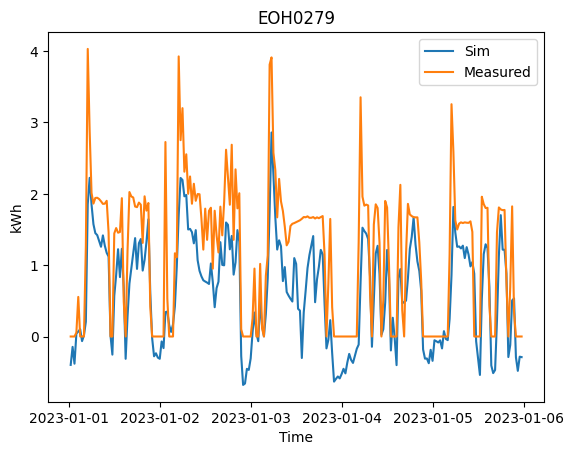

RMSE of q_hp: 0.6706408670630828


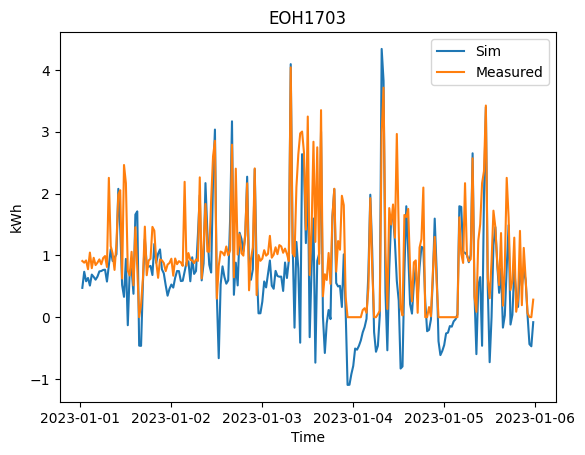

RMSE of q_hp: 1.2617716531018337


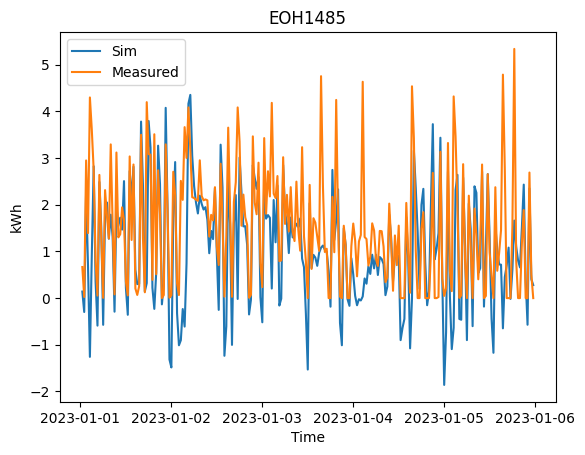

RMSE of q_hp: 0.8479175090557414


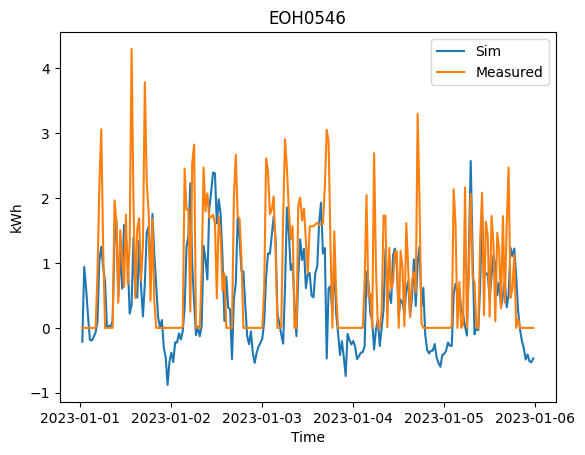

RMSE of q_hp: 1.8194434213537178


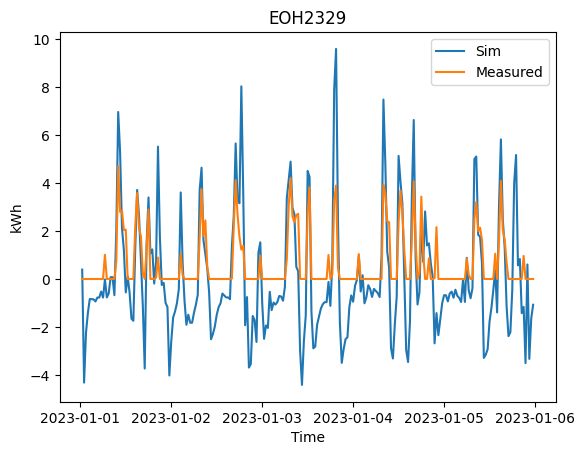

RMSE of q_hp: 1.3030456867053903


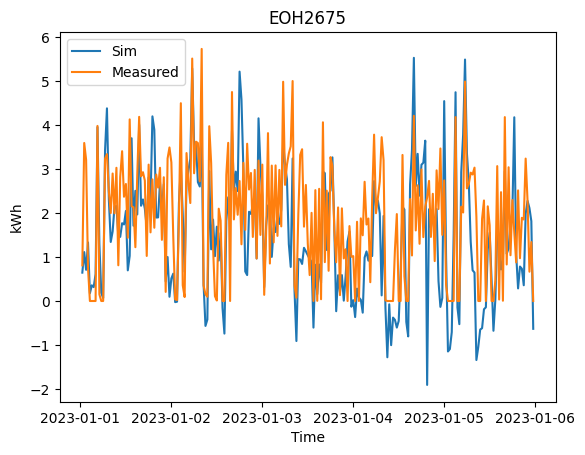

RMSE of q_hp: 0.9864762914987141


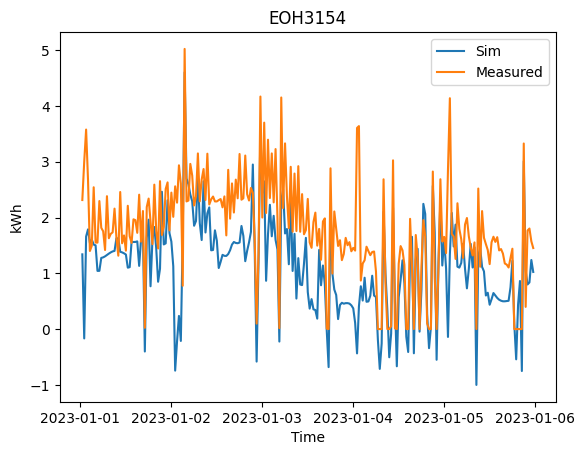

RMSE of q_hp: 0.9934181967051964


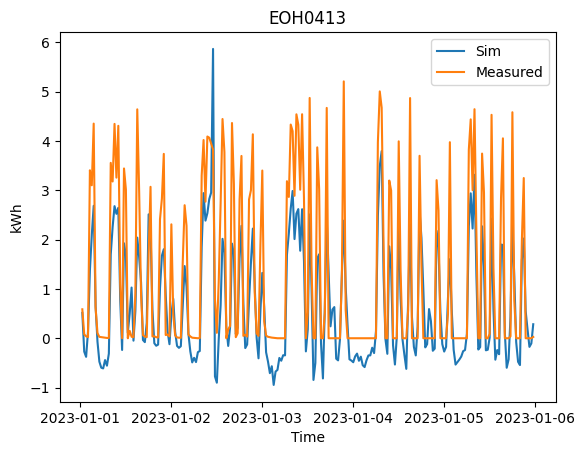

RMSE of q_hp: 1.7385910410814653


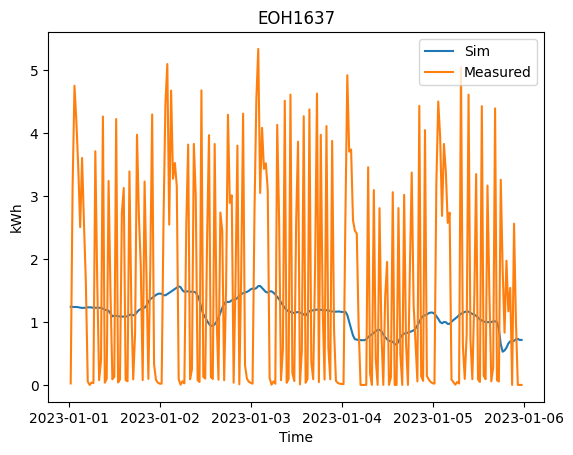

RMSE of q_hp: 0.9553039793432546


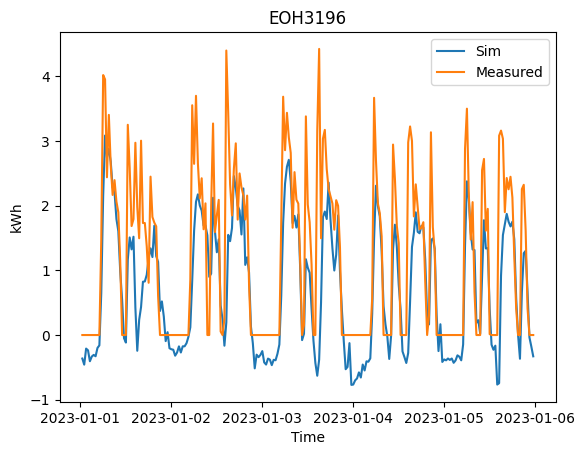

In [21]:
# ------- Look at heat supply performance in validation data ------

for id_use in unique_ids:
    df_id = trained_params[id_use].copy()
    C = df_id.C
    R_a = df_id.R_a
    w_s= df_id.w_s
    w = df_id.w
    
    
    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
    
    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] - 
         df_single["Internal_Air_Temperature"])
         
    
    
    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())
    
    df_single = df_single_cleaned
    
    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())
    
    # 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()
    
    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')
    
    df_single_interpolated = df_single.copy() 
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated
    
    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)
    
    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")
    
    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    
    t_start = pd.to_datetime("2023 01 01 00:00:00")
    t_end = pd.to_datetime("2023 01 05 23:59:00")
    df_q_opt = df_q_results[(df_q_results.index>=t_start) & (df_q_results.index<=t_end)]
    df_heating_val = df_heating_single[df_heating_single.index>=t_start]
    df_heating_val = df_heating_val[df_heating_val.index<=t_end]
    
    
    
    T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
                 .reset_index(drop=True).to_numpy()) 
    delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t) 
    q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy()) 
    q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy()) 
    v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy()) 
    
    
    
    q_hat_sim = (delta_T_i_val * C -  delta_T_a_val / R_a * delta_t  - w_s *  
            q_solar_val  - w * np.ones(len(T_a_val), )* delta_t )
    
    e_q = q_hat_sim - q_hp_val
    rmse_q_val = np.sqrt(np.mean(e_q**2))
    print(f"RMSE of q_hp: {rmse_q_val}")
    
    plt.plot(df_heating_val.index[1:],q_hat_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], q_hp_val, label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("kWh")
    plt.title(f"{id_use}")
    plt.show()

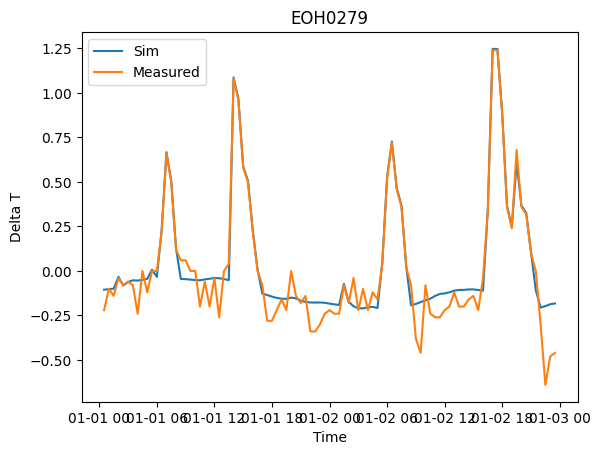

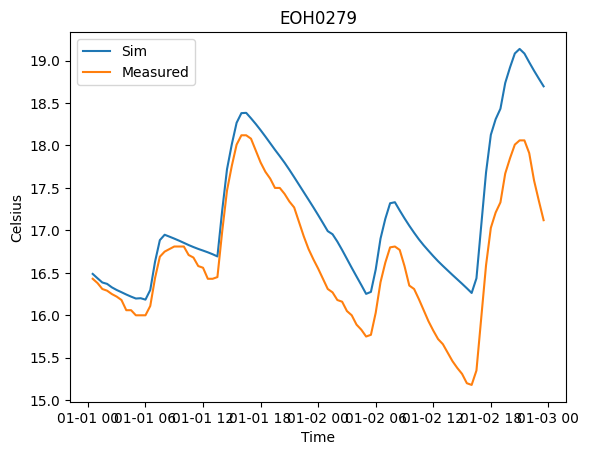

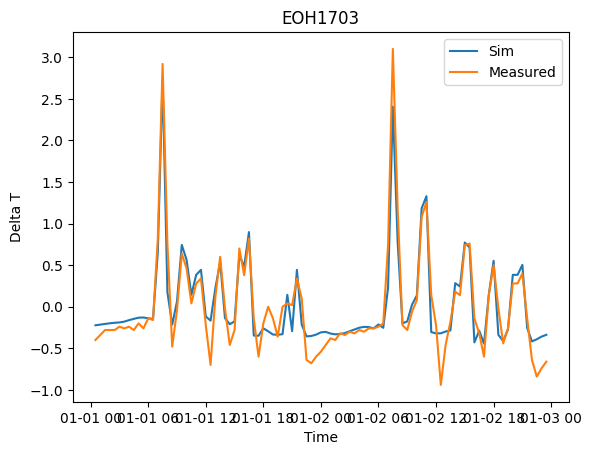

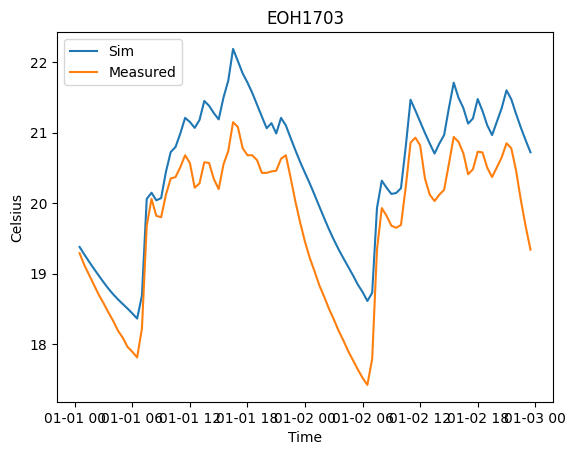

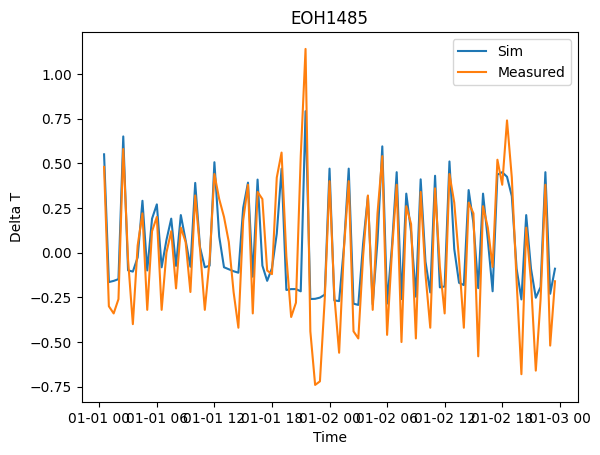

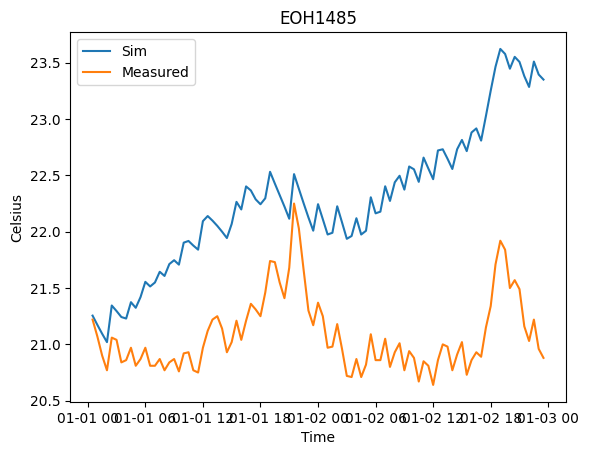

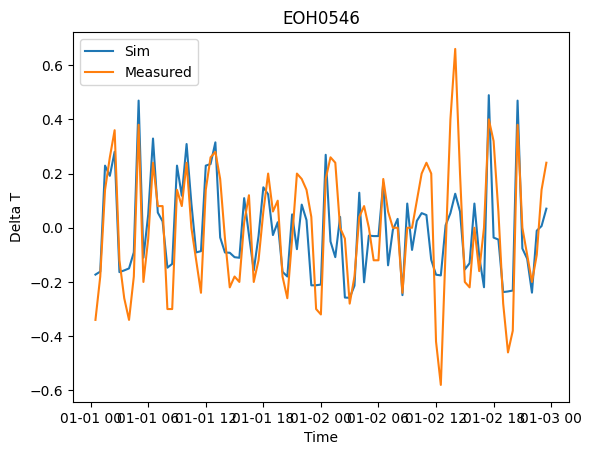

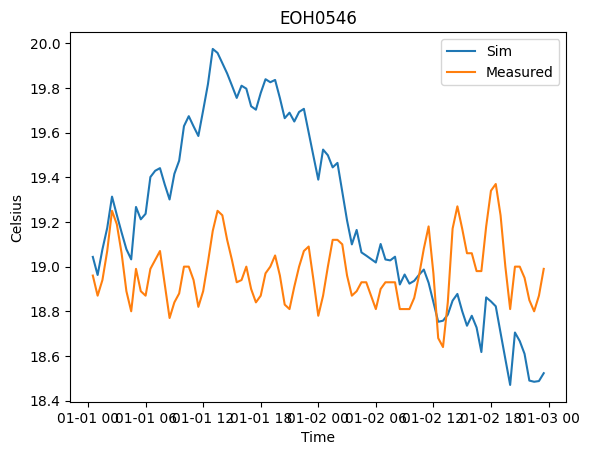

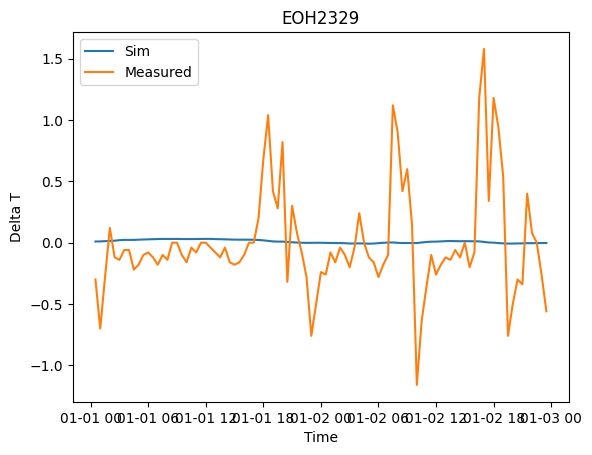

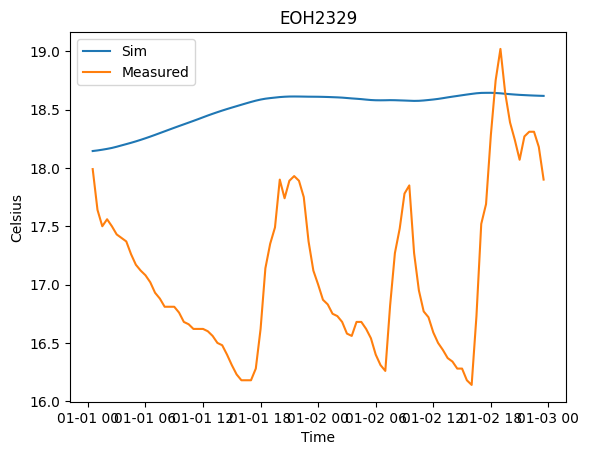

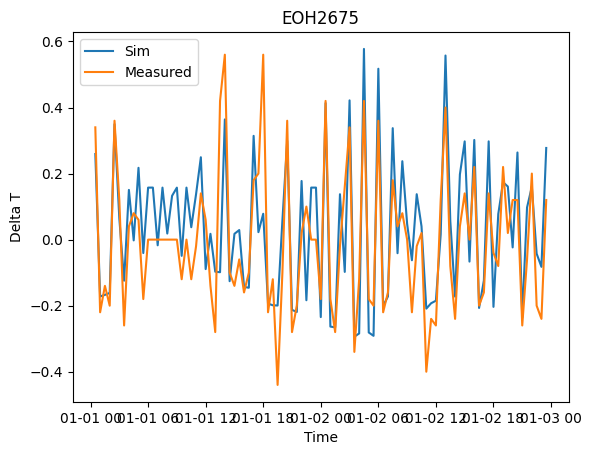

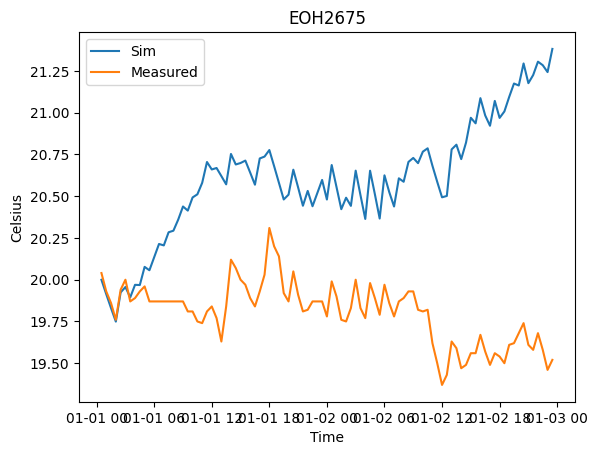

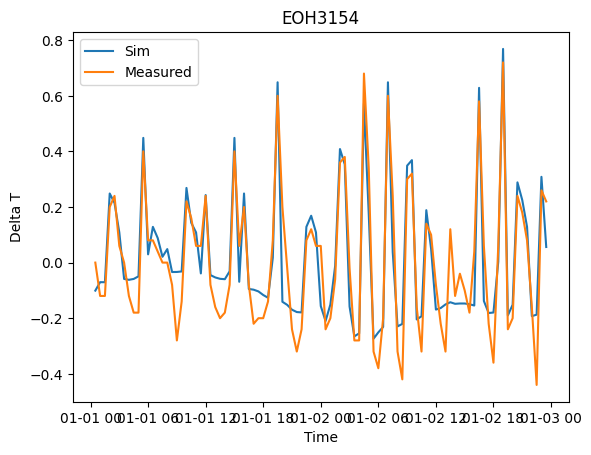

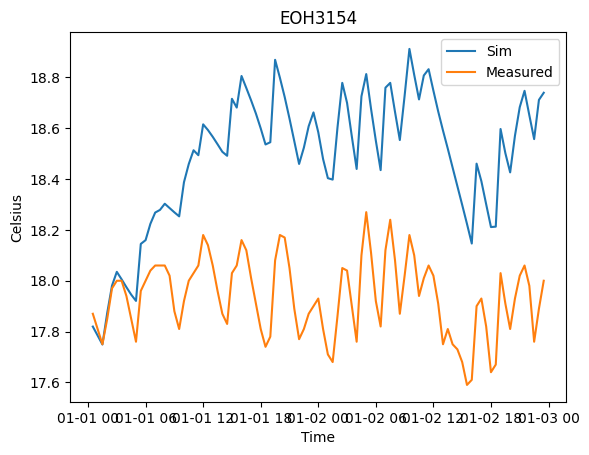

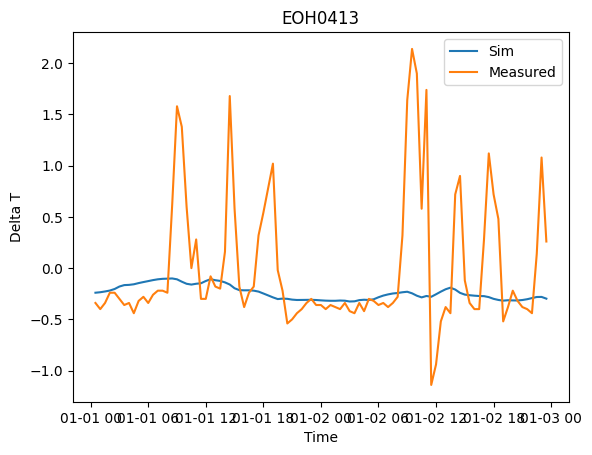

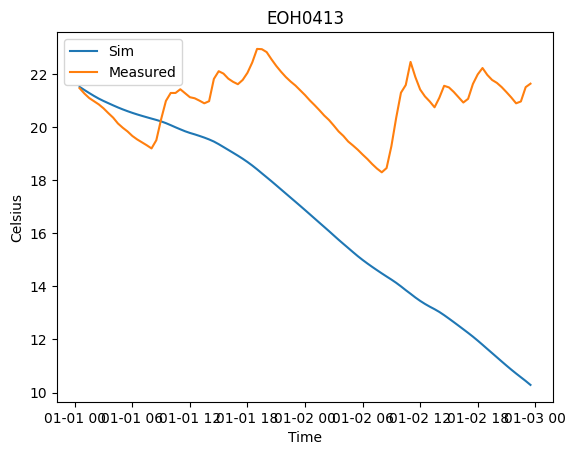

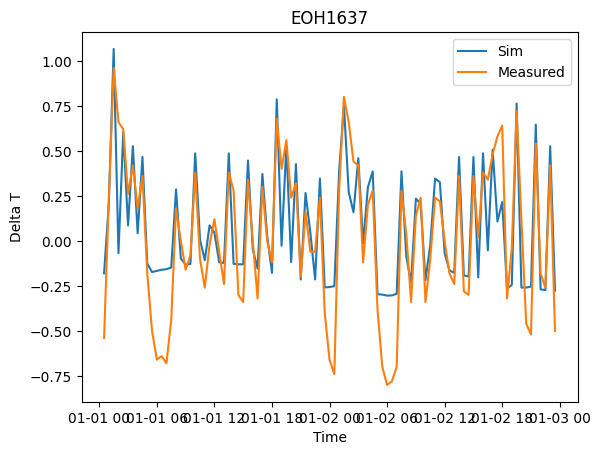

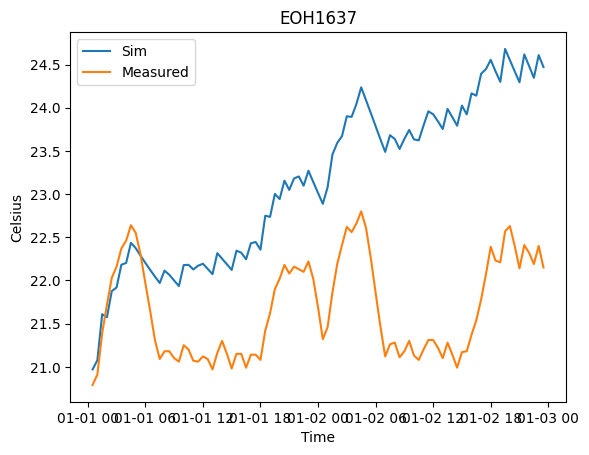

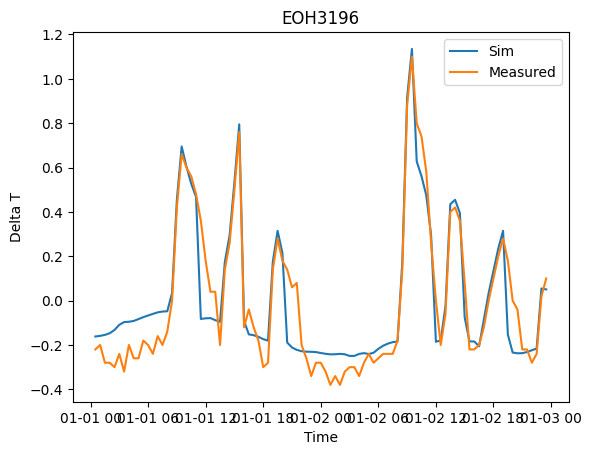

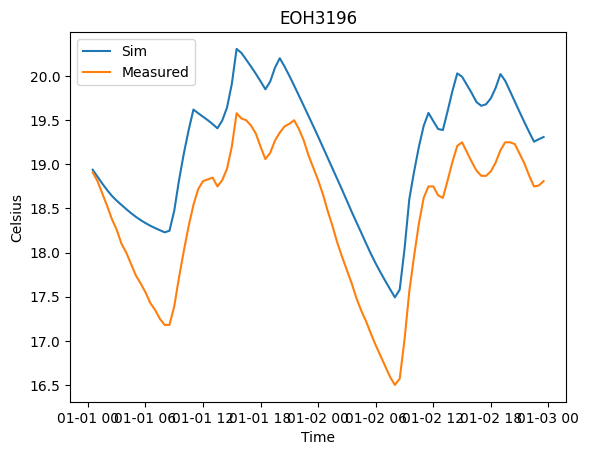

In [22]:
# -----Look at temperature tracking performance in the training --------------

for id_use in unique_ids:
    df_id = trained_params[id_use].copy()
    C = df_id.C
    R_a = df_id.R_a
    w_s= df_id.w_s
    w = df_id.w
    
    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
    
    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] - 
         df_single["Internal_Air_Temperature"])
         
    
    
    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())
    
    df_single = df_single_cleaned
    
    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())
    
    # 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()
    
    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')
    
    df_single_interpolated = df_single.copy() 
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated
    
    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)
    
    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")
    
    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    
    # Validate results
    t_start = pd.to_datetime("2022 01 01 00:00:00")
    t_end = pd.to_datetime("2022 01 02 23:59:00")
    df_q_id_use = df_q_id[(df_q_id.index>=t_start) & (df_q_id.index<=t_end)]
    df_heating_val = df_heating_single[df_heating_single.index>=t_start]
    df_heating_val = df_heating_val[df_heating_val.index<=t_end]
    
    
    
    T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
                 .reset_index(drop=True).to_numpy()) 
    delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t) 
    q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy()) 
    q_opt = df_q_id_use[id_use].iloc[:-1].reset_index(drop=True).to_numpy()
    q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy()) 
    v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy()) 
    
    
    delta_T_i_sim = (delta_T_a_val / R_a *delta_t + q_opt + w_s* q_solar_val + w
                     * np
                     .ones(len(T_a_val), )* delta_t) / C
    
    T_i_sim = np.zeros_like(T_i_val)
    T_i_prev = T_i_val[0]
    for i in range(len(delta_T_i_sim)):
        T_i_sim[i] = T_i_prev + delta_T_i_sim[i]*delta_t
        T_i_prev = T_i_sim[i]
    
    
    plt.plot(df_heating_val.index[1:],delta_T_i_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], delta_T_i_val, label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Delta T")
    plt.title(f"{id_use}")
    plt.show()
    
    plt.plot(df_heating_val.index[1:],T_i_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], df_heating_val["Internal_Air_Temperature"]
             .iloc[1:].reset_index
           (drop=True).to_numpy(), label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Celsius")
    plt.title(f"{id_use}")
    plt.show()